In [1]:
import pandas as pd
import numpy as np
import os
import accelerate
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree, naive_bayes
import numpy as np
import seaborn as sns
import re
from scipy.stats import chi2_contingency
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, StandardScaler
import graphviz
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score
import optuna
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import pandas as pd
from torch import nn
from torch.nn import functional as F
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn import naive_bayes
import wandb
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
[nltk_data] Downloading package punkt to /home/mvc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mvc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/mvc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#Random seed
torch.manual_seed(42)
if torch.cuda.is_available():
    print("Cuda is available")
    torch.cuda.manual_seed_all(42)  # For all GPUs

Cuda is available


In [3]:
import gc
torch.cuda.empty_cache()
gc.collect()

20

# Wandb login

In [4]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: bryan-constantine7. Use `wandb login --relogin` to force relogin


True

# acllmdb Dataset

## Convert to CSV

In [26]:
def unison_shuffled_copies(a, b, c, random_state=42):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    assert len(a) == len(b)
    assert len(a) == len(c)
    p = np.random.RandomState(seed=random_state).permutation(len(a))
    return a[p], b[p], c[p]

def read_contents_update_array(Dirname, filename, textArray, decimalLabelArray, integerLabelArray):
    originalLabel = filename.split("_")[1].split(".")[0]
    normalizedLabel = (int(originalLabel) - 1) / 9
    decimalLabelArray.append(normalizedLabel)
    integerLabelArray.append(round(normalizedLabel))
    
    with open(Dirname + filename, 'r', encoding='latin-1') as f:
        textArray.append(f.read())

    return textArray, decimalLabelArray, integerLabelArray

In [27]:
# group the supervised into train and test csv
# rating is 1 - 10
# for better scale, we normalize the data to between 0 - 1
textArray = []
decimalLabelArray = []
integerLabelArray = []
motherDir = "./aclImdb/"
for filename in os.listdir(motherDir + "train/pos"):
    textArray, decimalLabelArray, integerLabelArray = read_contents_update_array(motherDir + "train/pos/", filename, textArray, decimalLabelArray, integerLabelArray)
print("Reach here")
for filename in os.listdir(motherDir + "train/neg"):
    textArray, decimalLabelArray, integerLabelArray = read_contents_update_array(motherDir + "train/neg/", filename, textArray, decimalLabelArray, integerLabelArray)

textArray, decimalLabelArray, integerLabelArray = unison_shuffled_copies(textArray, decimalLabelArray, integerLabelArray)

Reach here


MemoryError: Unable to allocate 1.91 TiB for an array with shape (25000,) and data type <U20965212

In [ ]:
train_df = pd.DataFrame({'text': textArray, 'decimalLabel': decimalLabelArray, 'integerLabel': integerLabelArray})
train_df.to_csv("aclimdb/train.csv", index=False)

In [ ]:
# group the supervised into train and test csv
# rating is 1 - 10
# for better scale, we normalize the data to between 0 - 1
textArray = []
decimalLabelArray = []
integerLabelArray = []
motherDir = "./aclImdb/"
for filename in os.listdir(motherDir + "test/pos"):
    textArray, decimalLabelArray, integerLabelArray = read_contents_update_array(motherDir + "test/pos/", filename, textArray, decimalLabelArray, integerLabelArray)
print("Reach here")
for filename in os.listdir(motherDir + "test/neg"):
    textArray, decimalLabelArray, integerLabelArray = read_contents_update_array(motherDir + "test/neg/", filename, textArray, decimalLabelArray, integerLabelArray)

textArray, decimalLabelArray, integerLabelArray = unison_shuffled_copies(textArray, decimalLabelArray, integerLabelArray)

Reach here


In [ ]:
test_df = pd.DataFrame({'text': textArray, 'decimalLabel': decimalLabelArray, 'integerLabel': integerLabelArray})
test_df.to_csv("aclimdb/test.csv", index=False)

## Read CSV, create heuristic characteristic for analysis

In [ ]:
train_acl = pd.read_csv("aclimdb/train.csv")
test_acl = pd.read_csv("aclimdb/test.csv")

In [ ]:
#Try to extract several variables from text
#simple features
def splitSentenceInPredefinedSeparator(x):
    separators = [',', ' ', '.' , ';', ':', '!', '?', '"', "'", "<br />"]
    for separator in separators:
        x = x.replace(separator, ' ')
    return str(x).split()

#Count number of words
def numberOfWords(x):
    #return number of words that has been splitted including with ',', '.', ' '
    return len(splitSentenceInPredefinedSeparator(x))

def uniqueWords(x):
    #return number of unique words that has been splitted including with ',', '.', ' '
    return len(set(splitSentenceInPredefinedSeparator(x)))


train_acl['num-words'] = train_acl['text'].apply(lambda x: numberOfWords(x))
test_acl['num-words'] = test_acl['text'].apply(lambda x: numberOfWords(x))
#Count number of unique words
train_acl['num-unique-words'] = train_acl['text'].apply(lambda x: uniqueWords(x))
test_acl['num-unique-words'] = test_acl['text'].apply(lambda x: uniqueWords(x))
#Count number of punctuations
train_acl['num-punctuations'] = train_acl['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_acl['num-punctuations'] = test_acl['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#UniqueWordRatio
train_acl['unique-word-ratio'] = train_acl['num-unique-words'] / train_acl['num-words']
test_acl['unique-word-ratio'] = test_acl['num-unique-words'] / test_acl['num-words']
#PunctuationRatio
train_acl['punctuation-ratio'] = train_acl['num-punctuations'] / train_acl['num-words']
test_acl['punctuation-ratio'] = test_acl['num-punctuations'] / test_acl['num-words']
#Sentence Length
train_acl['sentence-length'] = train_acl['text'].apply(lambda x: len(x.split('.')))
test_acl['sentence-length'] = test_acl['text'].apply(lambda x: len(x.split('.')))
#Number of Words beginning with capital letters (Other than first word in a sentence after period)
train_acl['num-words-beginning-capital'] = train_acl['text'].apply(lambda x: len([w for w in x.split() if w[0].isupper() and w[0] not in ['.', '"', "'"]]))
test_acl['num-words-beginning-capital'] = test_acl['text'].apply(lambda x: len([w for w in x.split() if w[0].isupper() and w[0] not in ['.', '"', "'"]]))
# #Count Number of Nouns, and Nouns Ratio
# print("beginning noun extraction")
# train_acl['num-nouns'] = train_acl['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['NN', 'NNP']]))
# test_acl['num-nouns'] = test_acl['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['NN', 'NNP']]))
# train_acl['nouns-ratio'] = train_acl['num-nouns'] / train_acl['num-words']
# test_acl['nouns-ratio'] = test_acl['num-nouns'] / test_acl['num-words']
# #Count Number of Verbs, and Verbs Ratio
# print("beginning verb extraction")
# train_acl['num-verbs'] = train_acl['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]))
# test_acl['num-verbs'] = test_acl['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]))
# train_acl['verbs-ratio'] = train_acl['num-verbs'] / train_acl['num-words']
# test_acl['verbs-ratio'] = test_acl['num-verbs'] / test_acl['num-words']
# #Count Number of Adjectives, and Adjectives Ratio
# print("beginning adjective extraction")
# train_acl['num-adjectives'] = train_acl['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['JJ', 'JJR', 'JJS']]))
# test_acl['num-adjectives'] = test_acl['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['JJ', 'JJR', 'JJS']]))
# train_acl['adjectives-ratio'] = train_acl['num-adjectives'] / train_acl['num-words']
# test_acl['adjectives-ratio'] = test_acl['num-adjectives'] / test_acl['num-words']
# #Average Word Length
# train_acl['average-word-length'] = train_acl['text'].apply(lambda x: np.mean([len(w) for w in splitSentenceInPredefinedSeparator(x)]))
# test_acl['average-word-length'] = test_acl['text'].apply(lambda x: np.mean([len(w) for w in splitSentenceInPredefinedSeparator(x)]))
# #stopwords count
# train_acl['stopwords-count'] = train_acl['text'].apply(lambda x: len([w for w in splitSentenceInPredefinedSeparator(x) if w.lower() in nltk.corpus.stopwords.words('english')]))
# test_acl['stopwords-count'] = test_acl['text'].apply(lambda x: len([w for w in splitSentenceInPredefinedSeparator(x) if w.lower() in nltk.corpus.stopwords.words('english')]))
# train_acl['Stopwords-ratio'] = train_acl['stopwords-count'] / test_acl['num-words']
# test_acl['Stopwords-ratio'] = test_acl['stopwords-count'] / test_acl['num-words']

In [ ]:
#Noun extraction
print("beginning verb extraction")
train_num_verbs = []
test_num_verbs = []
for i in range(len(train_acl)):
    if i % 100 == 0:
        print(i)
    train_num_verbs.append(len([w for w in word_tokenize(train_acl['text'][i]) if pos_tag([w])[0][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]))
    test_num_verbs.append(len([w for w in word_tokenize(test_acl['text'][i]) if pos_tag([w])[0][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]))
train_acl['num-verbs'] = train_num_verbs
test_acl['num-verbs'] = test_num_verbs

beginning noun extraction
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000


In [ ]:
train_acl.head()

,text,decimalLabel,integerLabel,num-words,num-unique-words,num-punctuations,unique-word-ratio,punctuation-ratio,sentence-length,num-words-beginning-capital,num-nouns
0,In Panic In The Streets Richard Widmark plays ...,0.777778,1,466,258,78,0.553648,0.167382,27,94,57
1,If you ask me the first one was really better ...,0.000000,0,137,82,33,0.598540,0.240876,13,19,22
2,I am a big fan a Faerie Tale Theatre and I've ...,1.000000,1,146,81,22,0.554795,0.150685,11,24,15
3,I just finished reading a book about Dillinger...,0.000000,0,168,107,25,0.636905,0.148810,14,25,24
4,Greg Davis and Bryan Daly take some crazed sta...,0.111111,0,143,99,17,0.692308,0.118881,5,23,8


In [ ]:
train_acl = train_acl.rename(columns={'num-nouns': 'num-verbs'})
test_acl = test_acl.rename(columns={'num-nouns': 'num-verbs'})

In [ ]:
train_acl.head()

,text,decimalLabel,integerLabel,num-words,num-unique-words,num-punctuations,unique-word-ratio,punctuation-ratio,sentence-length,num-words-beginning-capital,num-verbs
0,In Panic In The Streets Richard Widmark plays ...,0.777778,1,466,258,78,0.553648,0.167382,27,94,57
1,If you ask me the first one was really better ...,0.000000,0,137,82,33,0.598540,0.240876,13,19,22
2,I am a big fan a Faerie Tale Theatre and I've ...,1.000000,1,146,81,22,0.554795,0.150685,11,24,15
3,I just finished reading a book about Dillinger...,0.000000,0,168,107,25,0.636905,0.148810,14,25,24
4,Greg Davis and Bryan Daly take some crazed sta...,0.111111,0,143,99,17,0.692308,0.118881,5,23,8


In [ ]:
train_acl['verbs-ratio'] = train_acl['num-verbs'] / train_acl['num-words']
test_acl['verbs-ratio'] = test_acl['num-verbs'] / test_acl['num-words']

In [ ]:
train_acl.to_csv("aclimdb/train_heuristic_verbs.csv", index=False)
test_acl.to_csv("aclimdb/test_heuristic_verbs.csv", index=False)

## Gather adjectives, and nouns counting result that is run on the other ipynb

In [ ]:
train_acl_nouns = pd.read_csv("aclimdb/train_heuristic_nouns.csv")
test_acl_nouns = pd.read_csv("aclimdb/train_heuristic_nouns.csv")
train_acl_adjs = pd.read_csv("aclimdb/train_heuristic_adjs.csv")
test_acl_adjs = pd.read_csv("aclimdb/train_heuristic_adjs.csv")

In [ ]:
train_acl["num-nouns"] = train_acl_nouns["num-nouns"]
test_acl["num-nouns"] = test_acl_nouns["num-nouns"]
train_acl["nouns-ratio"] = train_acl_nouns["nouns-ratio"]
test_acl["nouns-ratio"] = test_acl_nouns["nouns-ratio"]
train_acl["num-adjs"] = train_acl_adjs["num-adjs"]
test_acl["num-adjs"] = test_acl_adjs["num-adjs"]
train_acl["adjs-ratio"] = train_acl_adjs["adjs-ratio"]
test_acl["adjs-ratio"] = test_acl_adjs["adjs-ratio"]

In [ ]:
train_acl['average-word-length'] = train_acl['text'].apply(lambda x: np.mean([len(w) for w in splitSentenceInPredefinedSeparator(x)]))
test_acl['average-word-length'] = test_acl['text'].apply(lambda x: np.mean([len(w) for w in splitSentenceInPredefinedSeparator(x)]))

KeyboardInterrupt: 

In [ ]:
print("beginning stopwords extraction")
train_num_stopwords = []
test_num_stopwords = []
for i in range(len(train_acl)):
    if i % 100 == 0:
        print(i)
    train_num_stopwords.append(len([w for w in splitSentenceInPredefinedSeparator(train_acl["text"][i]) if w.lower() in nltk.corpus.stopwords.words('english')]))
    test_num_stopwords.append(len([w for w in splitSentenceInPredefinedSeparator(test_acl["text"][i]) if w.lower() in nltk.corpus.stopwords.words('english')]))

beginning stopwords extraction
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
1

KeyError: 'stopwords-count'

In [ ]:
train_acl['stopwords-count'] = train_num_stopwords
test_acl['stopwords-count'] = test_num_stopwords
train_acl['stopwords-ratio'] = train_acl['stopwords-count'] / test_acl['num-words']
test_acl['stopwords-ratio'] = test_acl['stopwords-count'] / test_acl['num-words']

In [ ]:
#make a new string column that maps integerLabel = 1 as "positive" and integerLabel = 0 as "negative"
train_acl['sentiment'] = train_acl['integerLabel'].map({1: "positive", 0: "negative"})

In [ ]:
train_acl.to_csv("aclimdb/train_heuristic.csv", index=False)
test_acl.to_csv("aclimdb/test_heuristic.csv", index=False)

## EDA on heuristic features

In [ ]:
categorical_amount = 0
continuous_amount = 0
for column, dtype in train_acl.dtypes.items():
    group = 'continuous' if dtype in ['int64', 'float64'] else 'categorical'
    if(group == 'categorical'):
        categorical_amount += 1
    else:
        continuous_amount += 1
    print(f"Column {column} has data type {dtype}/{group}")
print(f"Total categorical columns: {categorical_amount}")
print(f"Total continuous columns: {continuous_amount}")

Column text has data type object/categorical
Column decimalLabel has data type float64/continuous
Column integerLabel has data type int64/continuous
Column num-words has data type int64/continuous
Column num-unique-words has data type int64/continuous
Column num-punctuations has data type int64/continuous
Column unique-word-ratio has data type float64/continuous
Column punctuation-ratio has data type float64/continuous
Column sentence-length has data type int64/continuous
Column num-words-beginning-capital has data type int64/continuous
Column num-verbs has data type int64/continuous
Column verbs-ratio has data type float64/continuous
Column num-nouns has data type int64/continuous
Column nouns-ratio has data type float64/continuous
Column num-adjs has data type int64/continuous
Column adjs-ratio has data type float64/continuous
Column average-word-length has data type float64/continuous
Column stopwords-count has data type int64/continuous
Column stopwords-ratio has data type float64/

In [ ]:
#function for visualization
def describe_continuous_dataset(dataframe, column, target='sentiment'):
    #use violin plot to see the distribution of the data
    # Define figure size.
    plt.figure(figsize=(20, 7))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(dataframe[column], kde = True,color='r')
    plt.title('Histogram (Distribution)')

    plt.subplot(1, 3, 2)
    sns.violinplot(data=dataframe, x=column, y=target)
    plt.title('violinplot (Distribution respect to target)')
    
    
    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=dataframe[column],color = 'b')
    plt.title('Boxplot (More native approach to see distribution)')
    
    # barplot
    # plt.subplot(1, 4, 5)
    # sns.barplot(x = column, y = target, data = dataframe)   
    # plt.title('Barplot')
    
    
    plt.show()

def describe_target_dataset(dataframe, target):
    plt.figure(figsize=(20, 7))

    sns.countplot(data=dataframe, x=target, order=dataframe[target].value_counts().index)
    plt.title(f'Count of {target}')
    plt.ylabel('Count')

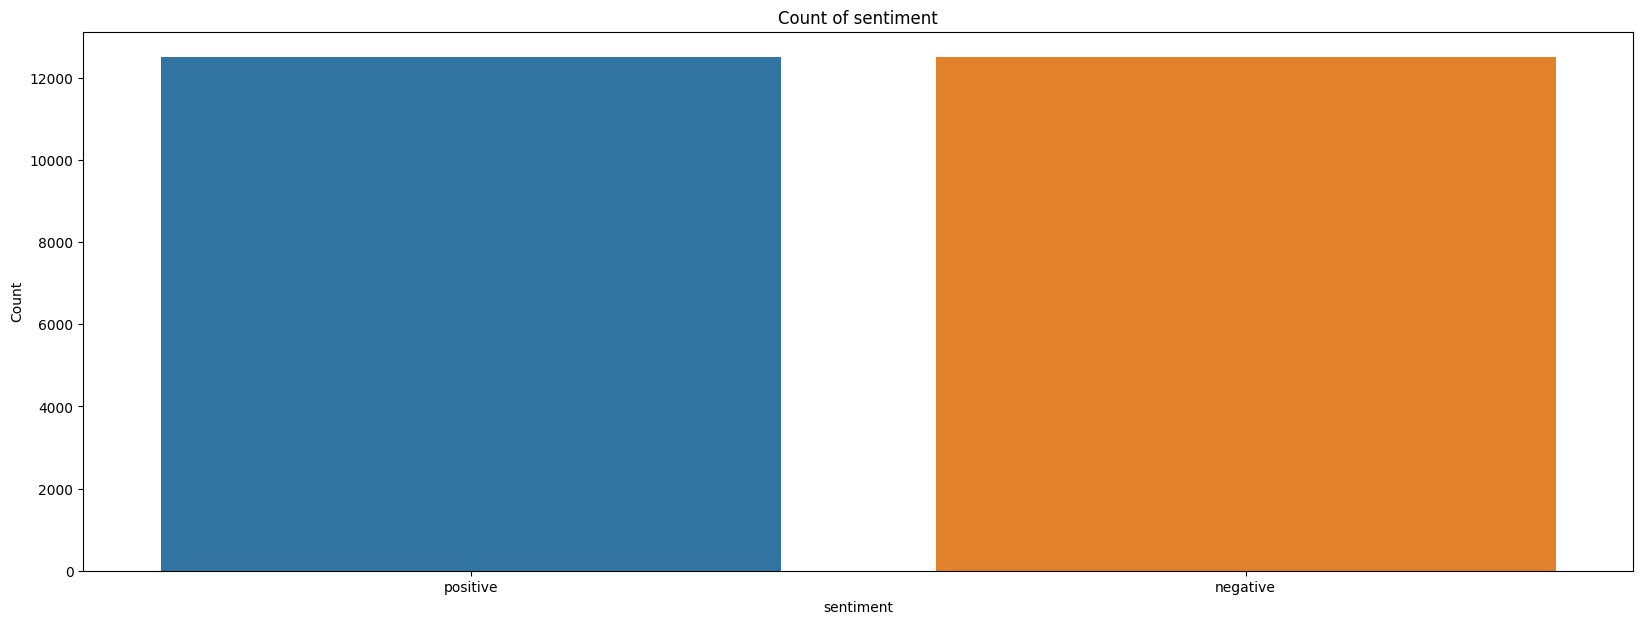

In [ ]:
describe_target_dataset(train_acl, "sentiment")

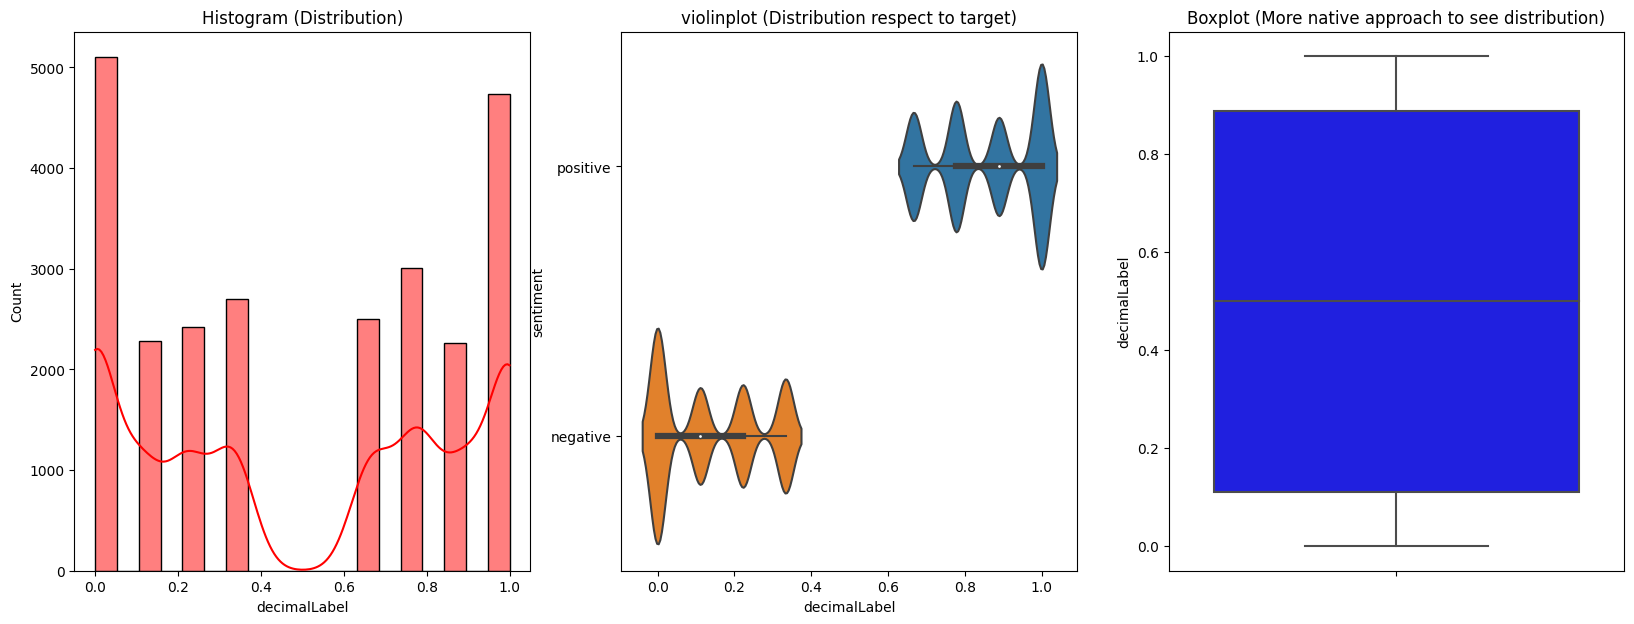

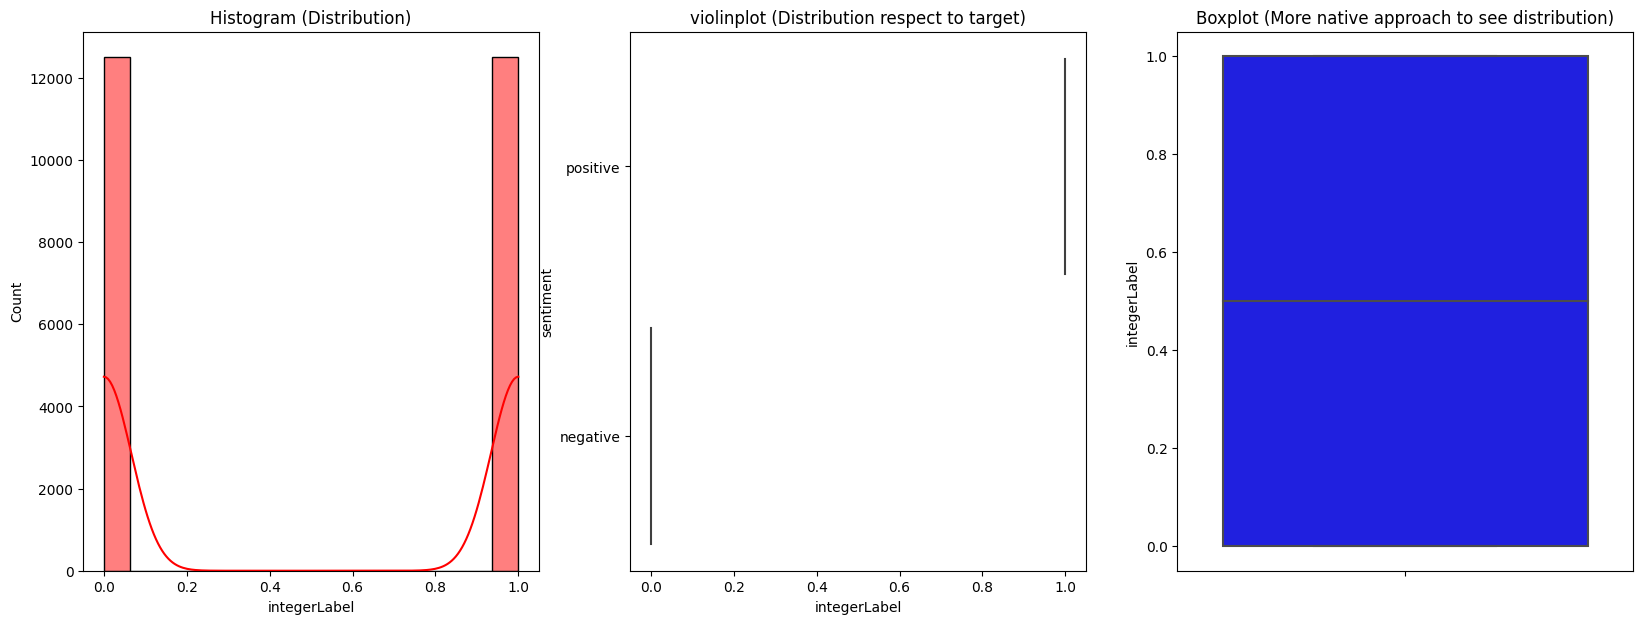

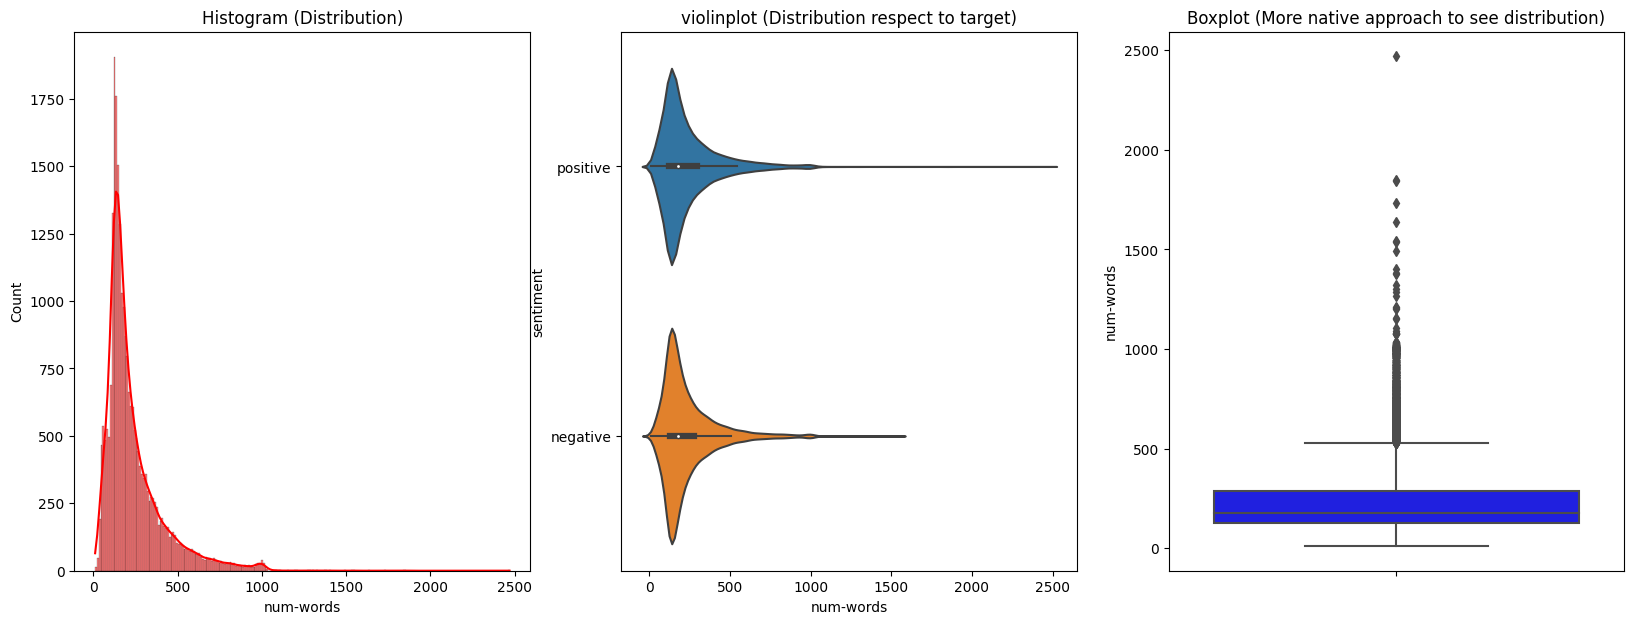

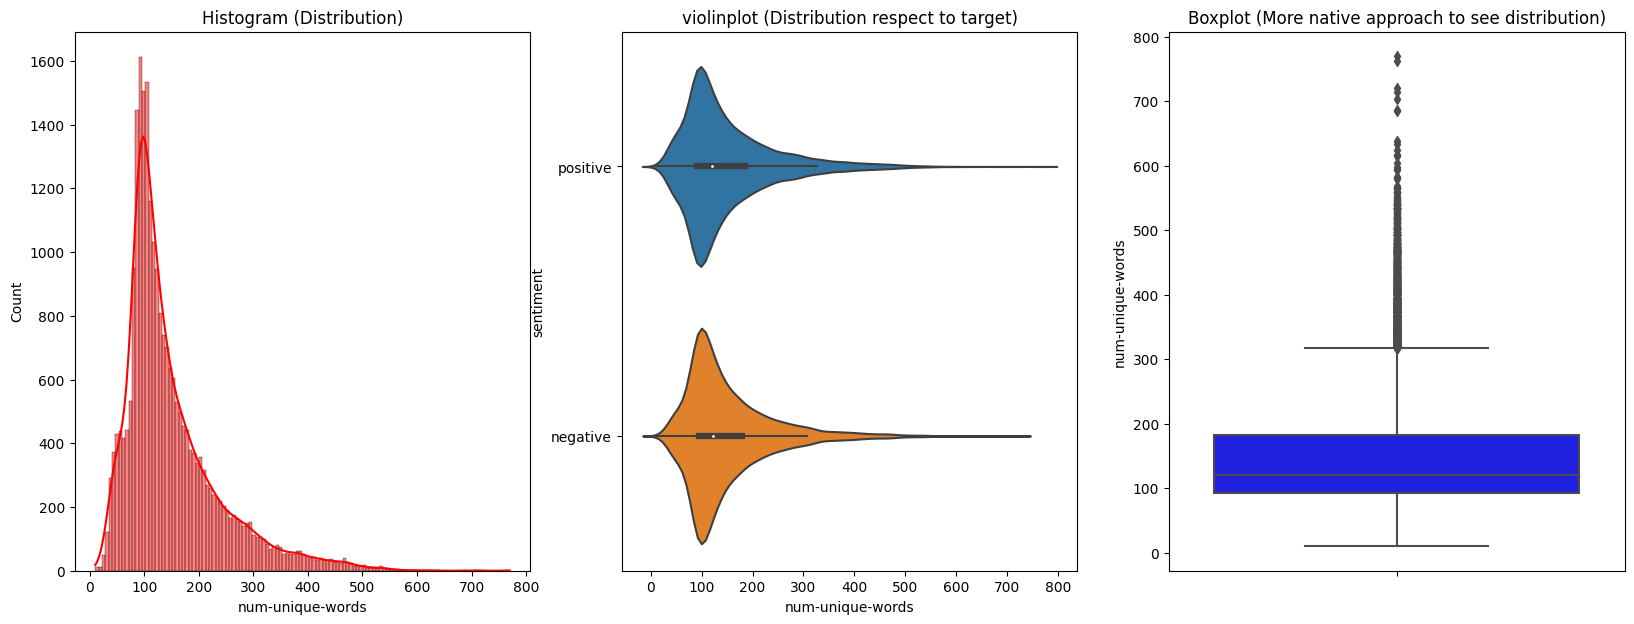

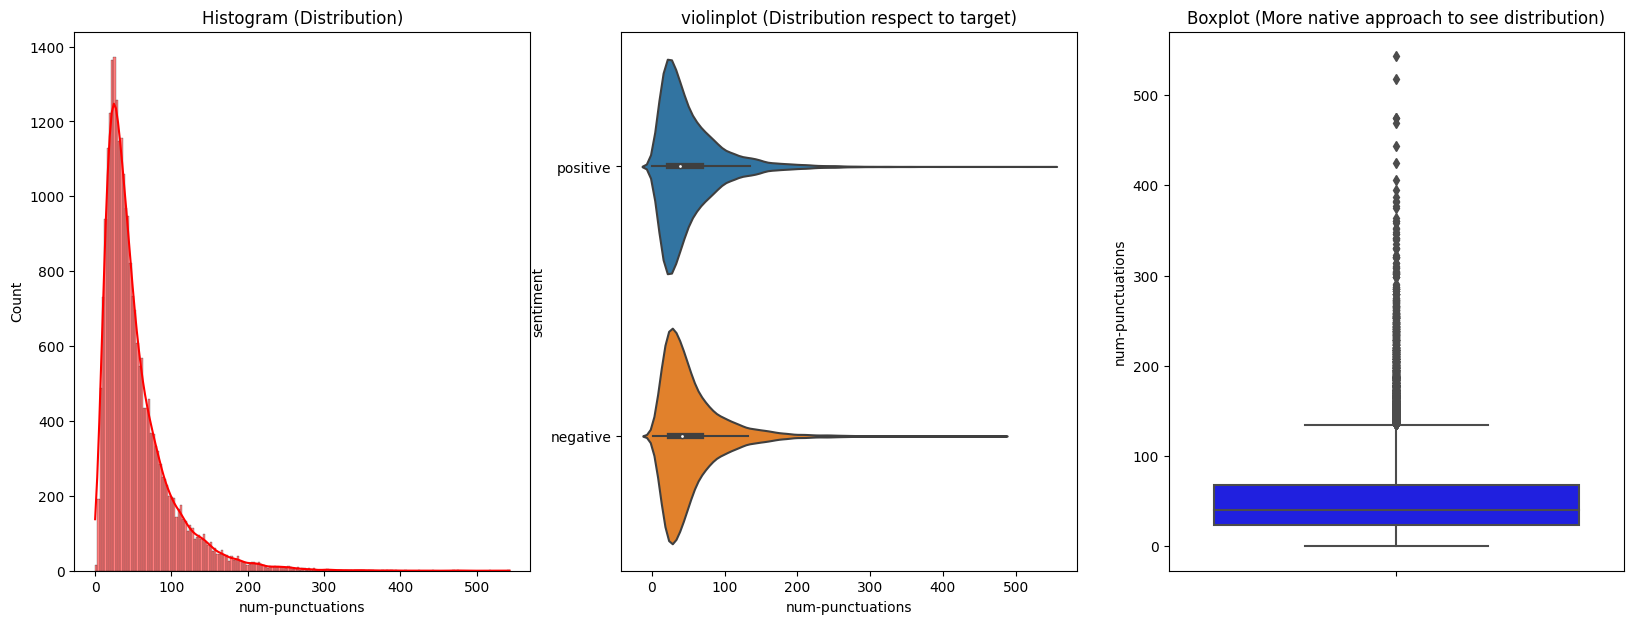

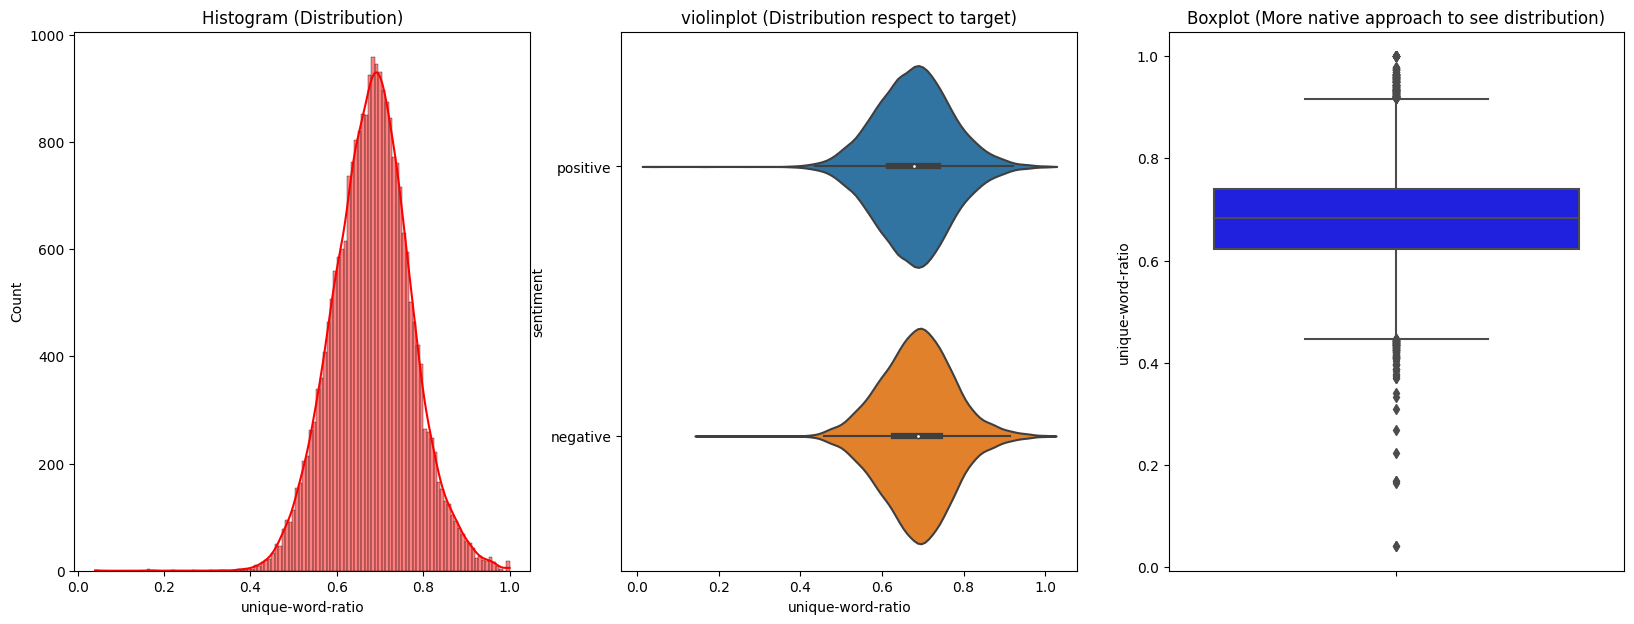

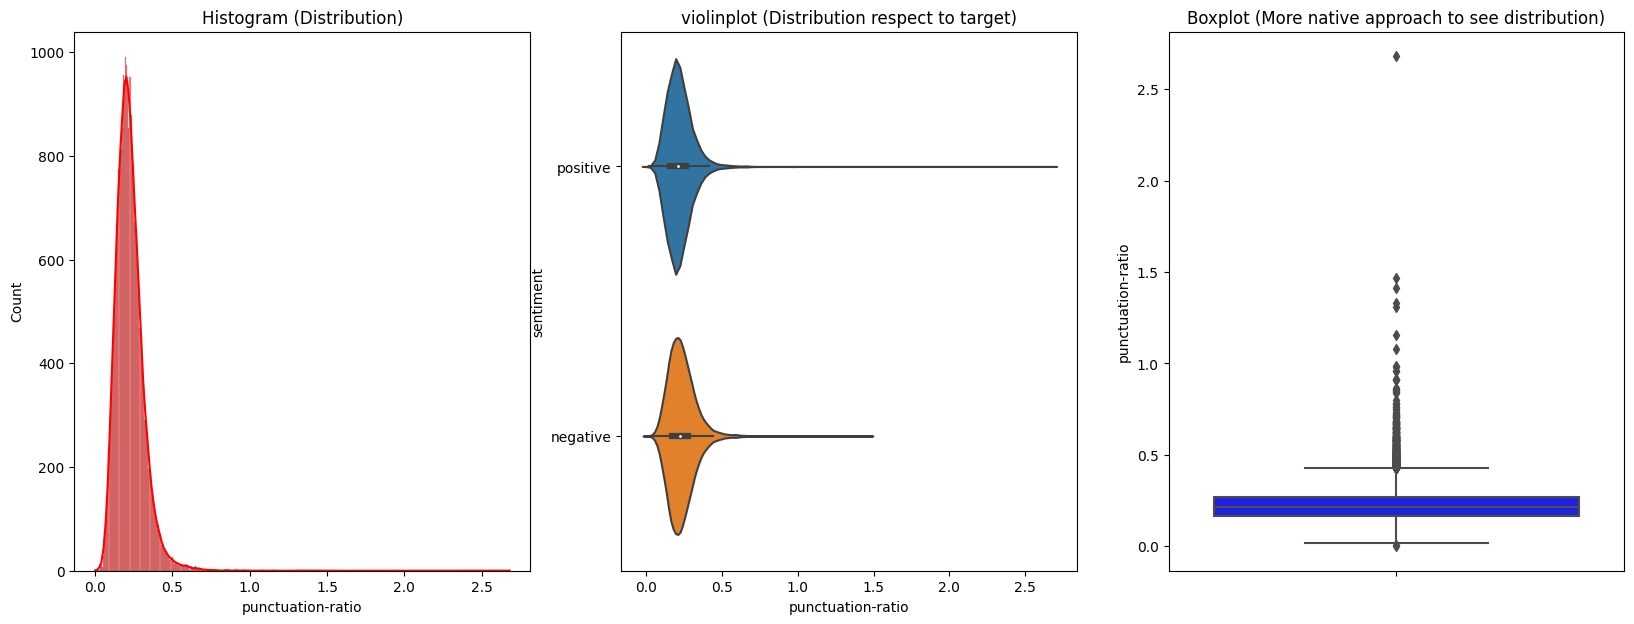

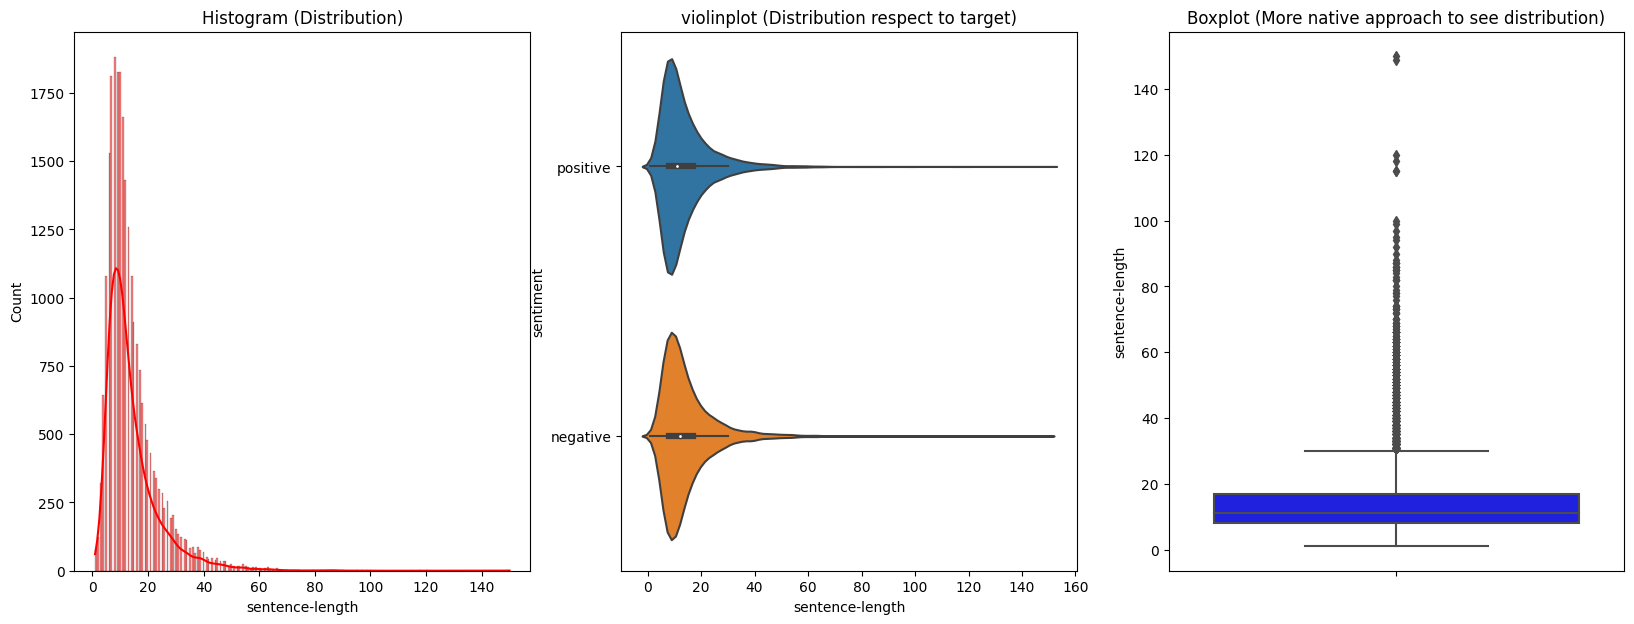

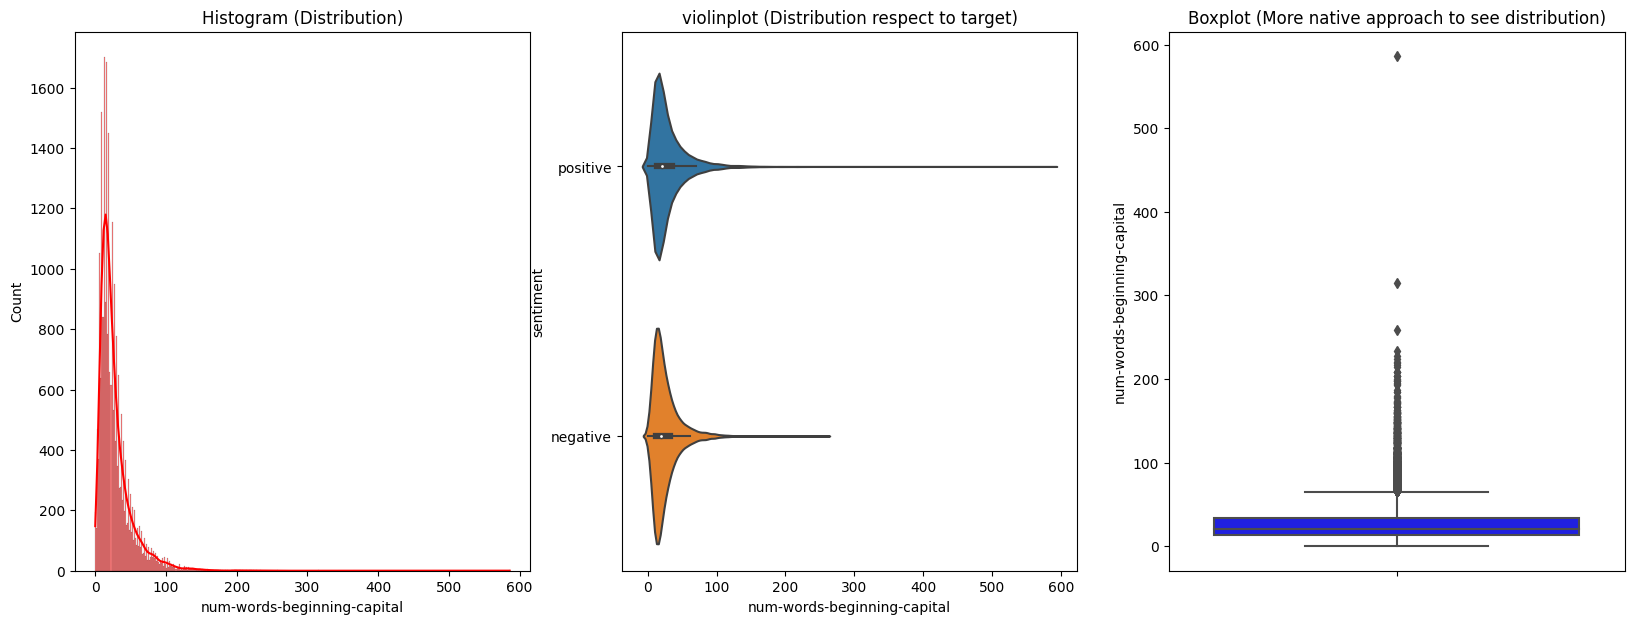

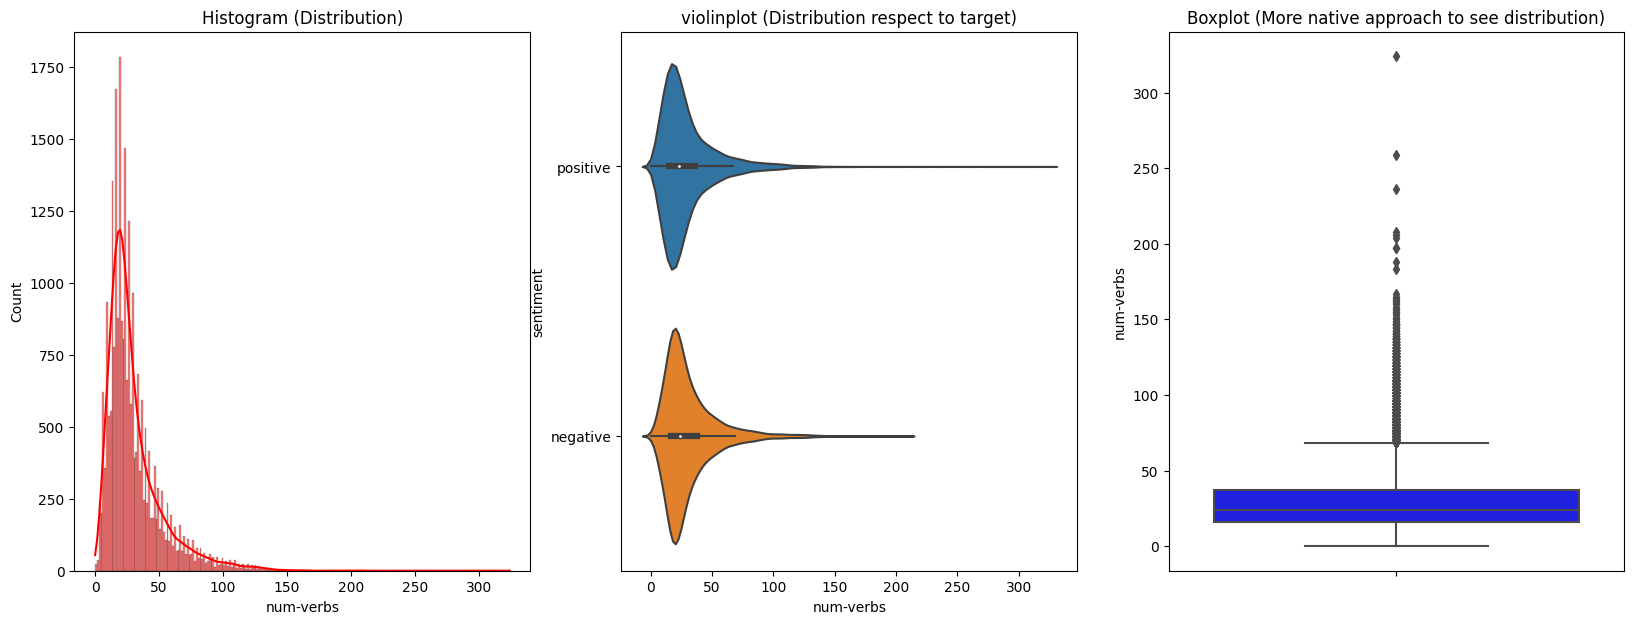

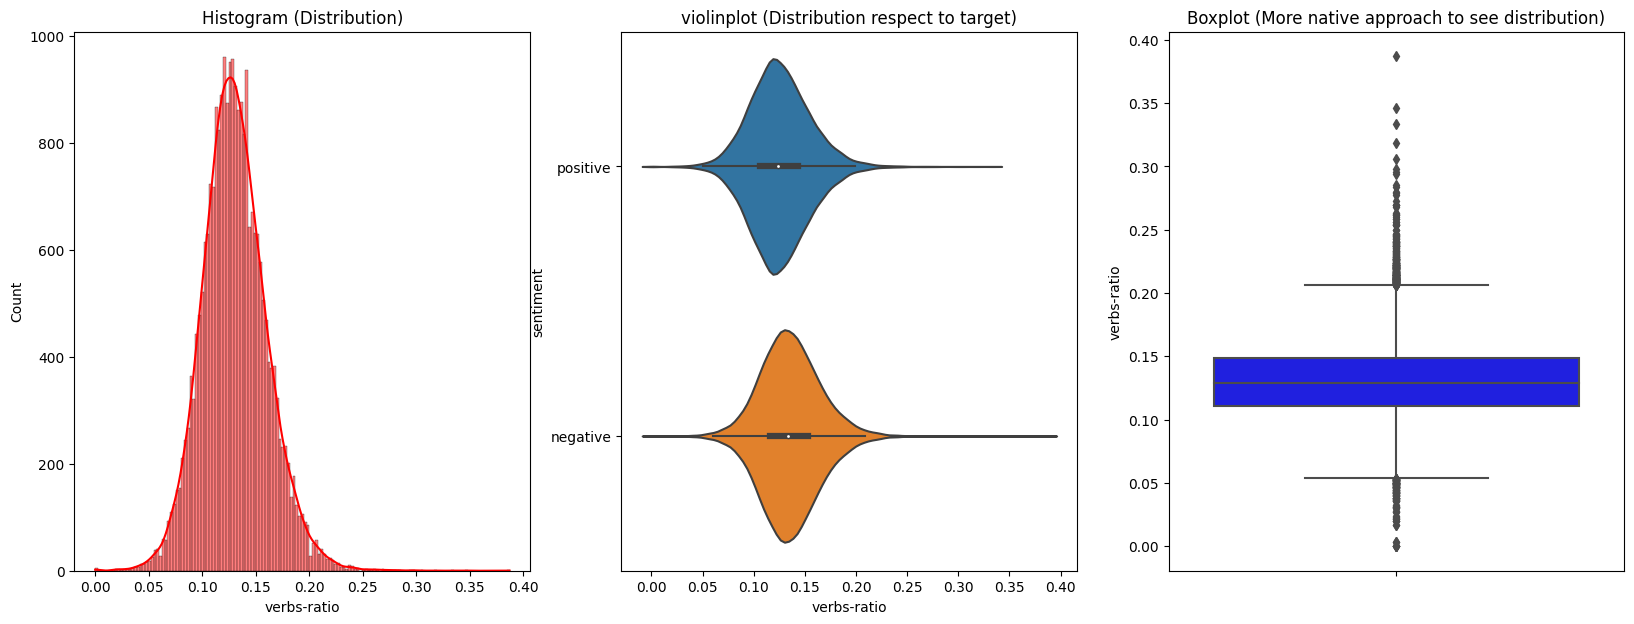

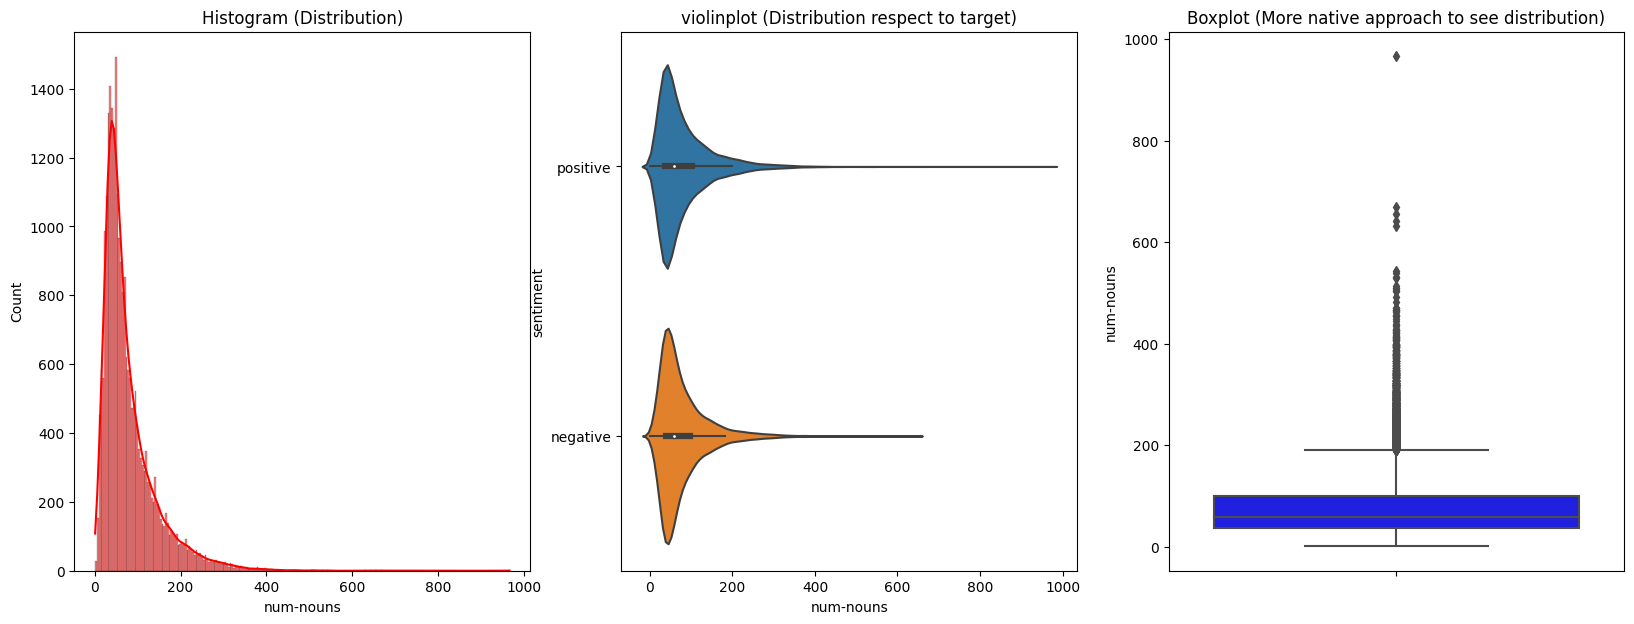

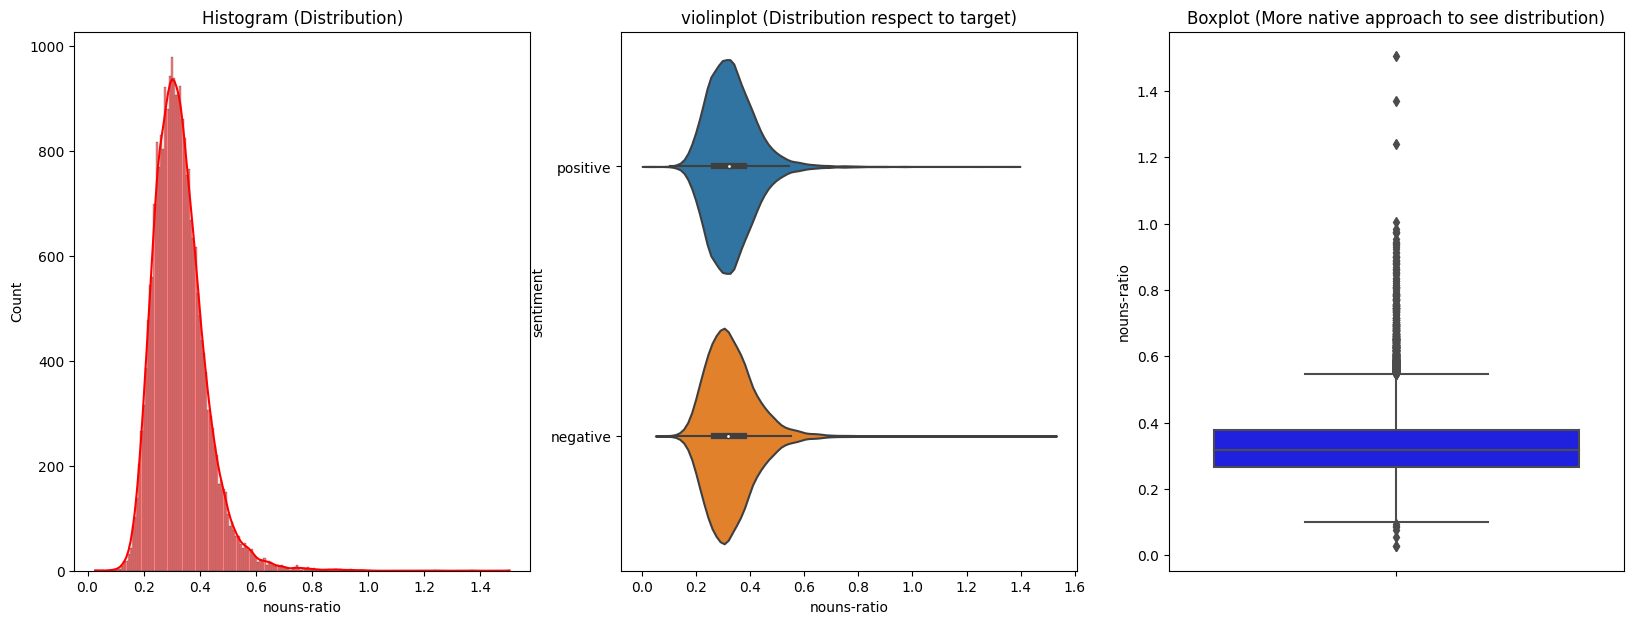

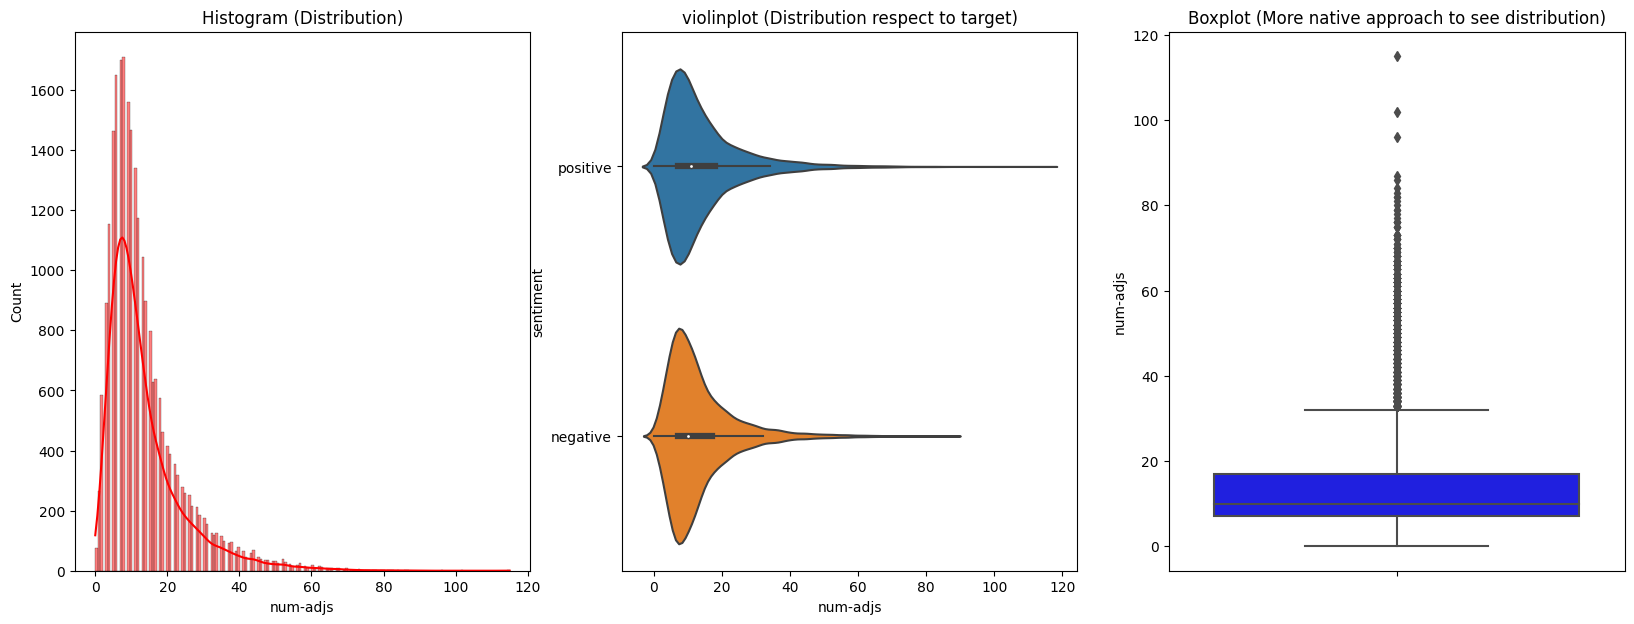

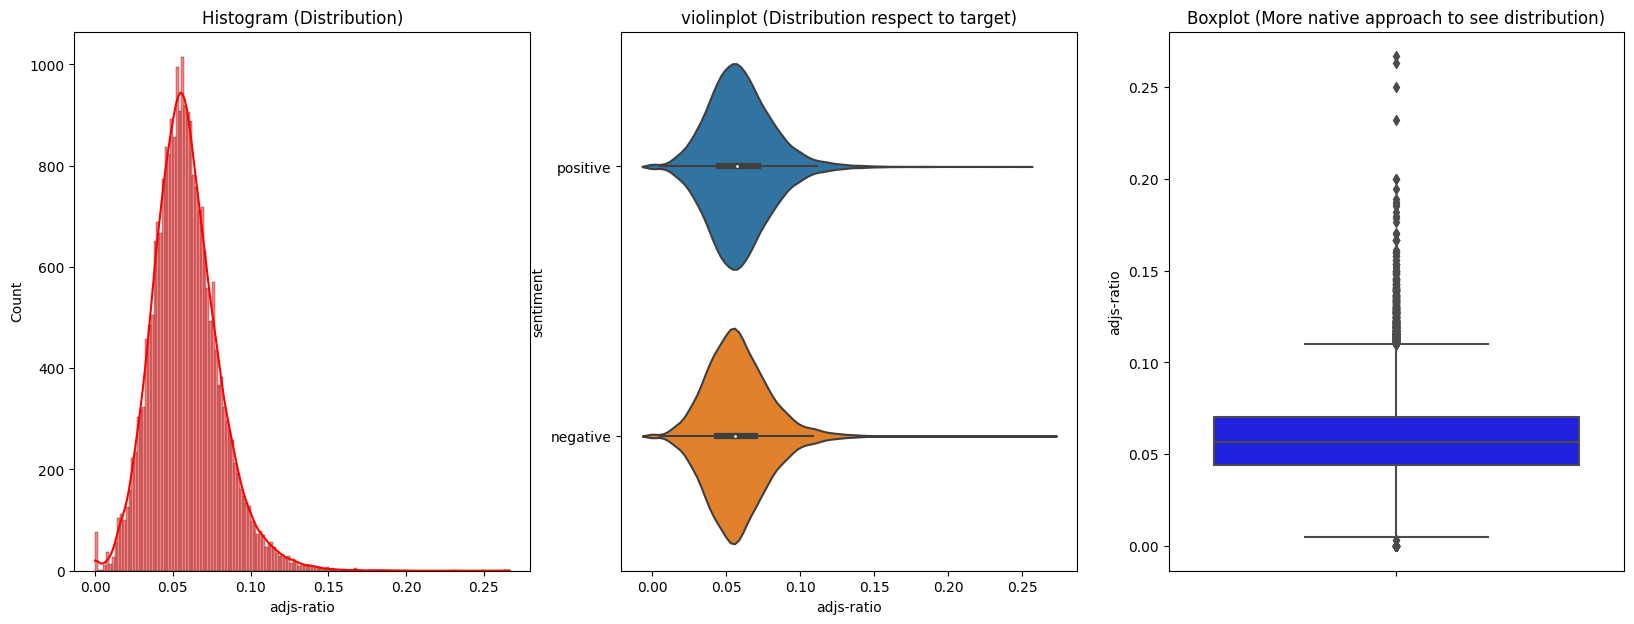

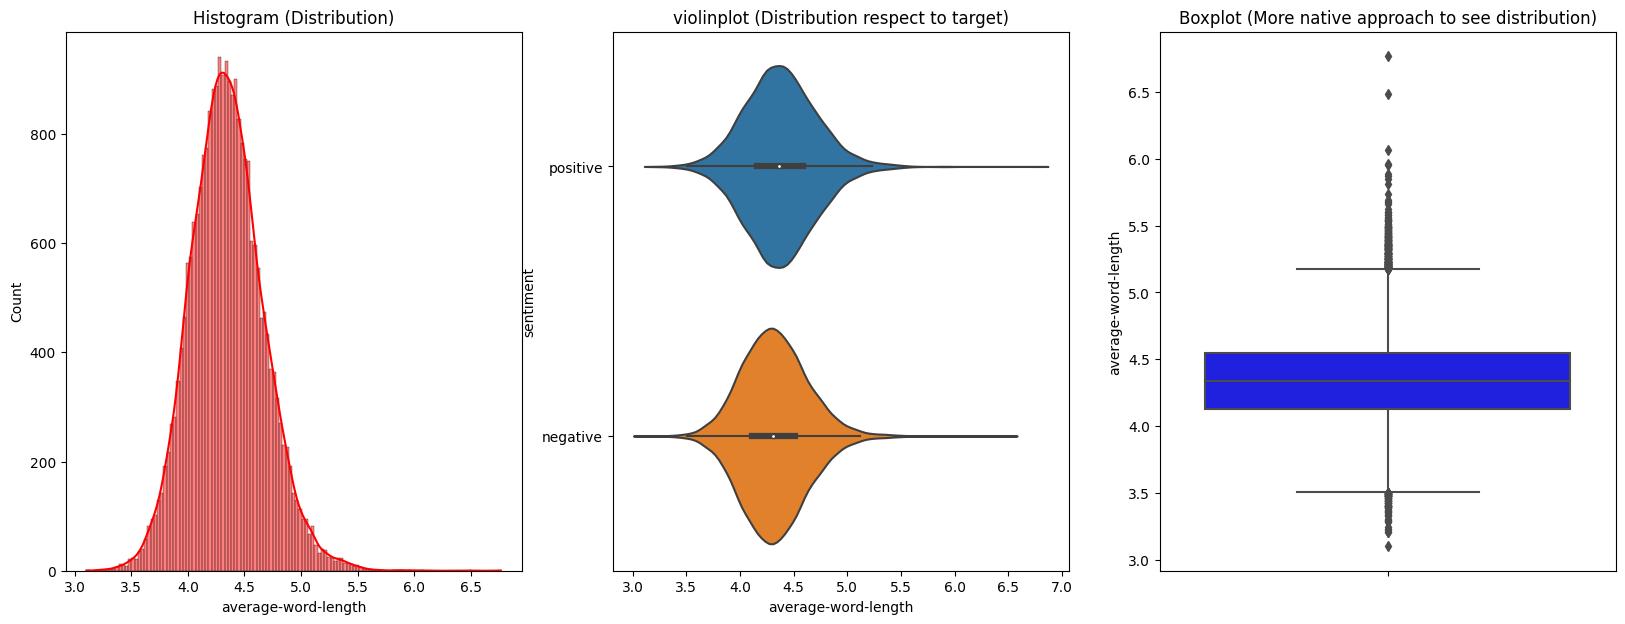

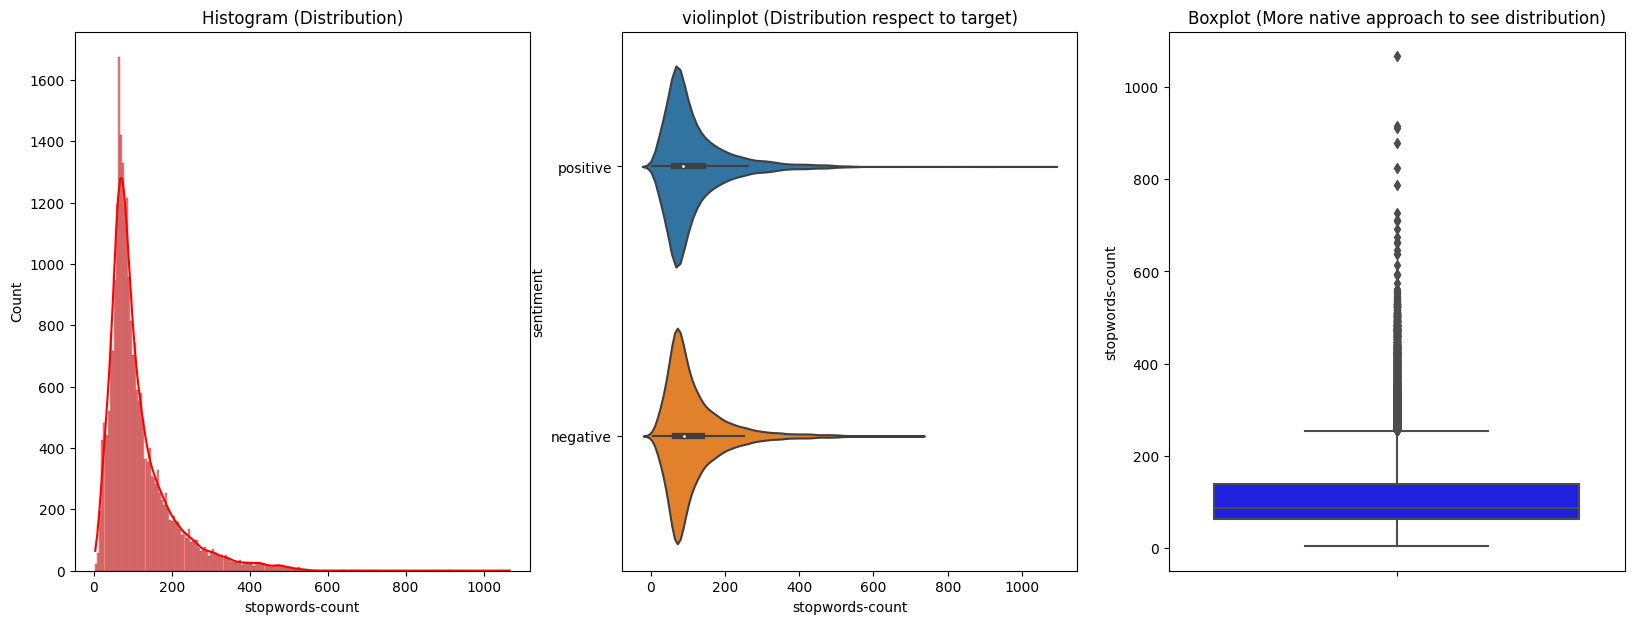

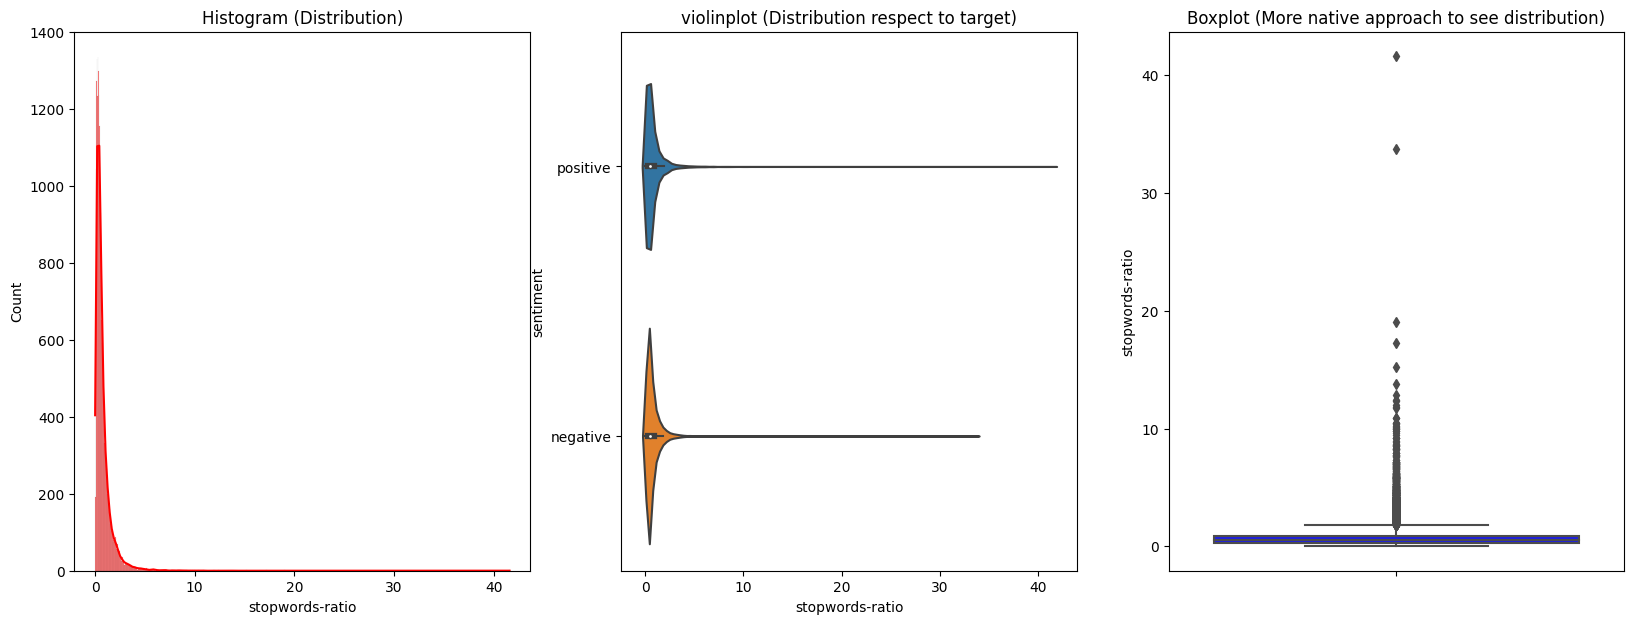

In [ ]:
continuous_vars = []
for column, dtype in train_acl.dtypes.items():
    if dtype in ['int64', 'float64']:
        continuous_vars.append(column)
#Evaluate Continuous Columns
for column in continuous_vars:
    describe_continuous_dataset(train_acl, column)

## Load CSV Data

In [5]:
train_acl = pd.read_csv("aclImdb/train_heuristic.csv", encoding="utf-8")
test_acl = pd.read_csv("aclImdb/test_heuristic.csv")

In [6]:
#use this to rename the first column if pandas can;t read the first column name
if 'Unnamed: 0' in train_acl.columns:
    print("entering")
    train_acl=train_acl.rename({"Unnamed: 0" : "text"}, axis=1)
if 'Unnamed: 0' in test_acl.columns:
    print("entering")
    test_acl=test_acl.rename({"Unnamed: 0" : "text"}, axis=1)

entering
entering


## Load the CSV that gathers train and test for cross validation

In [7]:
# Select only the 'text' and 'integerLabel' columns from each dataframe
train_acl_extracted = train_acl[['text', 'integerLabel']]
test_acl_extracted = test_acl[['text', 'integerLabel']]

# Concatenate the dataframes
combined_df = pd.concat([train_acl_extracted, test_acl_extracted])

# Shuffle the combined dataframe
shuffled_acl = combined_df.sample(frac=1, random_state=42)  # Replace 42 with your specific seed

# Save the shuffled dataframe to a new CSV file
shuffled_acl.to_csv("aclImdb/combined_data_shuffled.csv", index=False)

## Feature Engineering: Stemming and Lemmatizaton

### Remove HTML Token, emoji, Square Special Characters

In [ ]:
# fucntion to removes pattern in the input text.

# def remove_pattern(inputrain_acl = pd.read_csv("aclImdb/train_heuristic.csv", encoding="utf-8")
test_acl = pd.read_csv("aclImdb/test_heuristic.csv")
#         input_txt = re.sub(word, "", input_txt)
#     return input_txt

# imdb['review'] = np.vectorize(remove_pattern)(imdb['review'], "@[\w]*")

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing emojis
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols                                                                         
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

# Text-encoding: UTF-8 encoder
def to_unicode(text):
    if isinstance(text, float):
        text = str(text)
    if isinstance(text, int):
        text = str(text)
    if not isinstance(text, str):
        text = text.decode('utf-8', 'ignore')
    return text

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# Removing the noisy text
def denoise_text(text):
    # text = to_unicode(text)
    text = strip_html(text)
    text = re.sub(r"http\S+", "", text)
    text = deEmojify(text)
    # text = text.encode('ascii', 'ignore')
    # text = to_unicode(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    text = text.lower() # lower case 
    return text

def denoise_text_cased(text):
    # text = to_unicode(text)
    text = strip_html(text)
    text = re.sub(r"http\S+", "", text)
    text = deEmojify(text)
    # text = text.encode('ascii', 'ignore')
    # text = to_unicode(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    return text


In [ ]:
train_acl['denoised_text']=train_acl['text'].apply(denoise_text)
test_acl["denoised_text"]=test_acl["text"].apply(denoise_text)
train_acl["denoised_text_cased"]=train_acl['text'].apply(denoise_text)
test_acl["denoised_text_cased"]=test_acl["text"].apply(denoise_text)

/tmp/ipykernel_365785/3495575864.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
/tmp/ipykernel_365785/3495575864.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
/tmp/ipykernel_365785/3495575864.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
/tmp/ipykernel_365785/3495575864.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
print(train_acl["denoised_text"][0]) #notice the HTML TOken is now gone

in panic in the streets richard widmark plays us navy doctor who has his week rudely interrupted with a corpse that contains plague as cop paul douglas properly points out the guy died from two bullets in the chest thats not the issue here the two of them become unwilling partners in an effort to find the killers and anyone else exposed to the diseaseas was pointed out by any number of people for some reason director elia kazan did not bother to cast the small parts with anyone that sounds like theyre from louisiana having been to new orleans where the story takes place i can personally attest to that richard widmark and his wife barbara bel geddes can be excused because as a navy doctor he could be assigned there but for those that are natives it doesnt workbut with plague out there and the news being kept a secret the new orleans pd starts a dragnet of the citys underworld the dead guy came off a ship from europe and he had underworld connections a new orleans wise guy played by jack

## From the Denoised Text, do Stemming and Lemmatization

## Feature Engineering: Bag of Words

## Feature Engineering: TF-IDF

In [13]:
tfidf_transformer = TfidfVectorizer(stop_words = "english")
tfidf_transformer.fit(train_acl['text'])
Train_tfidf = tfidf_transformer.transform(x for x in train_acl['text'])
Test_tfidf = tfidf_transformer.transform(x for x in test_acl["text"])
print(Train_tfidf)
print(Test_tfidf)

  (0, 75002)	0.13779463098698344
  (0, 74541)	0.030470584833899625
  (0, 73999)	0.025381761671365036
  (0, 73872)	0.03259213093576724
  (0, 73663)	0.045487842614498813
  (0, 73404)	0.0320661462704852
  (0, 73380)	0.17476344723395157
  (0, 72885)	0.05365304668274575
  (0, 72839)	0.04389114232495023
  (0, 72665)	0.2023472350403845
  (0, 70879)	0.031835449727359424
  (0, 70878)	0.03221625315816238
  (0, 70679)	0.06419610984346139
  (0, 69804)	0.11892760401794163
  (0, 68771)	0.029519485803934317
  (0, 67890)	0.043418795300811955
  (0, 67474)	0.08943571248709789
  (0, 67270)	0.035174035194523584
  (0, 65687)	0.030492671824813602
  (0, 65439)	0.07216405158198833
  (0, 63919)	0.19565100028751617
  (0, 63760)	0.018757761070654515
  (0, 63244)	0.07112079150012007
  (0, 63237)	0.0473246488452222
  (0, 62919)	0.07755245762280949
  :	:
  (24999, 58823)	0.2343869522445355
  (24999, 57992)	0.10201770544217
  (24999, 54264)	0.15273614010662576
  (24999, 54049)	0.14854127278724363
  (24999, 49636)	0.

In [14]:
#Using Naive bayes to summarize the TF-IDF
def runMNB(Xtrain, Ytrain, Xtest, Ytest):
    model = naive_bayes.MultinomialNB()
    model.fit(Xtrain, Ytrain)
    print("Accuracy: " , accuracy_score(model.predict(Xtest), Ytest))
    print("Balanced Accuracy: " , balanced_accuracy_score(model.predict(Xtest), Ytest))
    return model

# def runMNBWithCrossValidation(Xtrain, Ytrain):
#     model = naive_bayes.MultinomialNB()
#     return cross_val_score(model, Xtrain, Ytrain, cv=10, scoring='balanced_accuracy').mean()

modelMNB = runMNB(Train_tfidf, train_acl['integerLabel'], Test_tfidf, test_acl["integerLabel"])
# print("10 Cross Validation MNB Balanced Accuracy: ", cross_val_score(runMNB(Train_tfidf, train_acl['integerLabel']), Train_tfidf, train_acl['integerLabel'], cv=10, scoring='balanced_accuracy').mean())

# print("Training Accuracy: ", accuracy_score(modelMNB.predict(Train_tfidf), SpookyTrain['author'])) #when using Multinomial bayes, TF-IDF gets high accuracy score

Accuracy:  0.82996
Balanced Accuracy:  0.8330343622214565


## Preparing the Data
As to make learning simpler, I will make it all to two classes only: 0 or 1 for the sentiment analysis

Split the test dataset to:
Eval: 15 000
Test: 10 000

Data that will be prepared: 
1. Normal Text Dataset --> Feed to Transformer model with their predefined tokenizers
2. Heuristic Extracted Dataset --> Feed to Traditional ML Models such as Log Reg
3. Text Dataset, but with stopwords removed

In [8]:
val_acl, final_test_acl = train_test_split(test_acl, test_size=0.4, stratify=test_acl["integerLabel"],random_state=42) #due to we want to have 10 cross vals

## Finetuning Model Quick Pipeline (For Transformer)

In [9]:
class QuickSentimentAnalysisFinetuningModel:
    def __init__(self, model_name, learning_rate, num_epochs, batch_size, wandb_run_name = None, warmup_steps = 500, weight_decay = 0.01, checkpoint_path = "./Bryan_model_checkpoints/", logging_dir =  "./logs/", metrics_for_best_model = "loss", train_only_last_layer = False):
        self.model_name = model_name
        self.wandb_run_name = wandb_run_name
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.weight_decay = weight_decay
        self.model_initialized = False
        self.checkpoint_path = checkpoint_path
        self.logging_dir = logging_dir

        self.id2label = {0: "negative", 1: "positive"}
        self.label2id = {"negative": 0, "positive": 1}
        

        #=========== Neccesity During Training ===========
        self.model = None
        self.tokenizer = None
        self.text_column_name = None
        self.label_column_name = None
        self.data_collator = None
        self.metrics_for_best_model = metrics_for_best_model
        assert metrics_for_best_model in ["loss", "accuracy", "balanced_accuracy", "precision", "recall", "f1"]
        if(metrics_for_best_model in ["loss"]):
            self.greater_is_better = False
        else:
            self.greater_is_better = True
        self.train_only_last_layer = train_only_last_layer
    def set_wandb_run_name(self):
        if(self.wandb_run_name == None):
            return self.formulate_model_name()
        else:
            return self.wandb_run_name
    def formulate_model_name(self):
        return self.model_name + "_lr" + str(self.learning_rate) + "_epoch" + str(self.num_epochs) + "_batch" + str(self.batch_size)+ "_trainOnlyLast" + str(self.train_only_last_layer) + "_warmup" + str(self.warmup_steps) + "_weightDecay" + str(self.weight_decay)
    def formulate_tokenizer_name(self):
        return "tokenizer_"+ self.model_name + "_lr" + str(self.learning_rate) + "_epoch" + str(self.num_epochs) + "_batch" + str(self.batch_size)+ "_trainOnlyLast" + str(self.train_only_last_layer) + "_warmup" + str(self.warmup_steps) + "_weightDecay" + str(self.weight_decay)
    def save_models_and_tokenizer(self, path):
        self.model.save_pretrained(path + "/"+ self.formulate_model_name() + "/")
        self.tokenizer.save_pretrained(path + "/"+ self.formulate_tokenizer_name() + "/")
    def load_models_and_tokenizer(self, path):
        self.model_initialized = True
        self.model = AutoModelForSequenceClassification.from_pretrained(
            path + "/"+ self.formulate_model_name() + "/", num_labels=2, id2label=self.id2label, label2id=self.label2id)
        self.tokenizer = AutoTokenizer.from_pretrained(
            path + "/"+ self.formulate_tokenizer_name() + "/", num_labels=2, id2label=self.id2label, label2id=self.label2id)
    def load_checkpoints(self, path):
        self.model_initialized = True
        self.model = AutoModelForSequenceClassification.from_pretrained(
            path +"/", num_labels=2, id2label=self.id2label, label2id=self.label2id)
        self.tokenizer = AutoTokenizer.from_pretrained(
            path + "/", num_labels=2, id2label=self.id2label, label2id=self.label2id)
    def initialize_model(self):
        self.model_initialized = True
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=2, id2label=self.id2label, label2id=self.label2id)
    def compute_metrics(self, pred):
        predictions, labels = pred
        predictions = np.argmax(predictions, axis=1)
        return {
            'accuracy': accuracy_score(labels, predictions),
            'balanced_accuracy': balanced_accuracy_score(labels, predictions),
            'precision': precision_score(labels, predictions),
            'recall': recall_score(labels, predictions),
            'f1': f1_score(labels, predictions)
        }
    def confusion_matrix(self, pred):
        predictions, labels = pred
        predictions = np.argmax(predictions, axis=1)
        return confusion_matrix(labels, predictions)
    def preprocess_function(self, train_df):
        tokenized_output = self.tokenizer(train_df[self.text_column_name], truncation=True)
        return {
            'input_ids': tokenized_output['input_ids'],
            'attention_mask': tokenized_output['attention_mask'],
            'labels': train_df[self.label_column_name]
        }
    def set_data_collator(self):
        assert self.tokenizer != None
        self.data_collator = DataCollatorWithPadding(self.tokenizer)
    def set_training_arguments(self):
        return TrainingArguments(
            output_dir=self.checkpoint_path,
            learning_rate=self.learning_rate,
            per_device_train_batch_size=self.batch_size,
            per_device_eval_batch_size=self.batch_size,
            warmup_steps=self.warmup_steps,
            num_train_epochs=self.num_epochs,
            weight_decay=self.weight_decay,
            logging_dir=self.logging_dir,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model=self.metrics_for_best_model,  # This tells the Trainer to use the accuracy metric to determine the best model.
            greater_is_better=self.greater_is_better,  # This tells the Trainer that higher values of the specified metric are better.
            save_total_limit=1,
            push_to_hub=False,
            report_to="wandb",
            run_name=self.set_wandb_run_name(),  # Name of the wandb run
        )
    def set_trainer(self, training_args, train_dataset, test_dataset):
        return Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            tokenizer=self.tokenizer,
            data_collator=self.data_collator,
            compute_metrics=self.compute_metrics,
        )
    def inference_models(self, inferenced_df, text_column_name, label_column_name):
        assert self.model_initialized
        self.set_data_collator()
        self.text_column_name = text_column_name
        self.label_column_name = label_column_name
        tokened_inferenced_dictionary = inferenced_df.apply(self.preprocess_function, axis=1, result_type = 'expand')
        inferenced_dataset = Dataset.from_pandas(tokened_inferenced_dictionary)
        trainer = self.set_trainer(self.set_training_arguments(), inferenced_dataset, inferenced_dataset)
        predictions = trainer.evaluate(inferenced_dataset)
        print("Inferenced results: ")
        print(predictions)
        print("===========")
        wandb.finish()
        return predictions
    def train_model(self, train_df, val_df, test_df, text_column_name, label_column_name):
        if not self.model_initialized:
            print("==== Model not initialized, initializing models with model name: " + self.model_name + " ====")
            self.model_initialized = True
            self.initialize_model()
        self.set_data_collator()
        self.text_column_name = text_column_name
        self.label_column_name = label_column_name
        tokened_train_dictionary = train_df.apply(self.preprocess_function, axis=1, result_type = 'expand')
        tokened_val_dictionary = val_df.apply(self.preprocess_function, axis=1, result_type = 'expand')
        tokened_test_dictionary = test_df.apply(self.preprocess_function, axis=1, result_type = 'expand')
        train_dataset = Dataset.from_pandas(tokened_train_dictionary)
        val_dataset = Dataset.from_pandas(tokened_val_dictionary)  
        test_dataset = Dataset.from_pandas(tokened_test_dictionary)

        training_args = self.set_training_arguments()

        trainer = self.set_trainer(training_args, train_dataset, val_dataset)

        trainer.train()
        predictions = trainer.evaluate(test_dataset)
        wandb.finish()
        print("Test results: ")
        print(predictions)
        print("===========")
        return self.model, self.tokenizer
    def cross_validate(self, df, text_column_name, label_column_name, k=5):
        kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        results = {
            'accuracy': [],
            'balanced_accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }

        for train_index, val_test_index in kf.split(df, df[label_column_name]):
            train_df = df.iloc[train_index]
            val_test_df = df.iloc[val_test_index]

            # Further split the val_test_df into validation and test sets
            val_df = val_test_df.sample(frac=0.5, random_state=42)
            test_df = val_test_df.drop(val_df.index)

            # Reinitialize the model for each fold
            self.initialize_model()

            # Train and validate the model
            self.train_model(train_df, val_df, test_df, text_column_name, label_column_name)

            # Evaluate the model on the validation set
            test_performance = self.evaluate_model(val_df, text_column_name, label_column_name)
            for key, value in test_performance:
                results[key].append(value)
                
            # Clear memory after each fold
            del self.model  # Replace 'self.model' with your actual model attribute
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # Calculate average performance across all folds
        #avg_performance = pd.DataFrame(results).mean().to_dict()
        return results

Recommendation of BERT Parameters
* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

In [ ]:
baseline_transformer_trial = QuickSentimentAnalysisFinetuningModel("distilbert-base-cased", 2e-5, 2, 8, metrics_for_best_model = "accuracy")
baseline_transformer_trial.train_model(train_acl, val_acl, final_test_acl, "text", "integerLabel")

==== Model not initialized, initializing models with model name: distilbert-base-cased ====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: bryan-constantine7. Use `wandb login --relogin` to force relogin


  8%|▊         | 500/6250 [02:11<26:53,  3.56it/s]

{'loss': 0.4972, 'learning_rate': 2e-05, 'epoch': 0.16}


 16%|█▌        | 1000/6250 [04:28<24:28,  3.58it/s]

{'loss': 0.3499, 'learning_rate': 1.8260869565217393e-05, 'epoch': 0.32}


 24%|██▍       | 1500/6250 [06:46<20:42,  3.82it/s]

{'loss': 0.3186, 'learning_rate': 1.6521739130434785e-05, 'epoch': 0.48}


 32%|███▏      | 2000/6250 [09:05<19:54,  3.56it/s]

{'loss': 0.3048, 'learning_rate': 1.4782608695652174e-05, 'epoch': 0.64}


 40%|████      | 2500/6250 [11:23<16:26,  3.80it/s]

{'loss': 0.2901, 'learning_rate': 1.3043478260869566e-05, 'epoch': 0.8}


 48%|████▊     | 3000/6250 [13:41<14:47,  3.66it/s]

{'loss': 0.2846, 'learning_rate': 1.1304347826086957e-05, 'epoch': 0.96}


                                                   
 50%|█████     | 3125/6250 [17:03<14:31,  3.59it/s]

{'eval_loss': 0.25406283140182495, 'eval_accuracy': 0.9139333333333334, 'eval_balanced_accuracy': 0.9139333333333333, 'eval_precision': 0.9391710284340077, 'eval_recall': 0.8852, 'eval_f1': 0.9113871919829776, 'eval_runtime': 167.7846, 'eval_samples_per_second': 89.4, 'eval_steps_per_second': 11.175, 'epoch': 1.0}


 56%|█████▌    | 3500/6250 [18:52<13:19,  3.44it/s]   

{'loss': 0.2222, 'learning_rate': 9.565217391304349e-06, 'epoch': 1.12}


 64%|██████▍   | 4000/6250 [21:16<10:34,  3.55it/s]

{'loss': 0.2005, 'learning_rate': 7.82608695652174e-06, 'epoch': 1.28}


 72%|███████▏  | 4500/6250 [23:38<08:29,  3.43it/s]

{'loss': 0.192, 'learning_rate': 6.086956521739132e-06, 'epoch': 1.44}


 80%|████████  | 5000/6250 [25:57<05:00,  4.16it/s]

{'loss': 0.2183, 'learning_rate': 4.347826086956522e-06, 'epoch': 1.6}


 88%|████████▊ | 5500/6250 [28:17<02:56,  4.25it/s]

{'loss': 0.1992, 'learning_rate': 2.6086956521739132e-06, 'epoch': 1.76}


 96%|█████████▌| 6000/6250 [30:36<01:09,  3.60it/s]

{'loss': 0.1701, 'learning_rate': 8.695652173913044e-07, 'epoch': 1.92}


                                                   
100%|██████████| 6250/6250 [36:09<00:00,  3.64it/s]

{'eval_loss': 0.30723097920417786, 'eval_accuracy': 0.9243333333333333, 'eval_balanced_accuracy': 0.9243333333333333, 'eval_precision': 0.9197994987468672, 'eval_recall': 0.9297333333333333, 'eval_f1': 0.9247397387441151, 'eval_runtime': 262.3173, 'eval_samples_per_second': 57.183, 'eval_steps_per_second': 7.148, 'epoch': 2.0}


100%|██████████| 6250/6250 [36:10<00:00,  2.88it/s]


{'train_runtime': 2171.8629, 'train_samples_per_second': 23.022, 'train_steps_per_second': 2.878, 'train_loss': 0.2676874768066406, 'epoch': 2.0}


eval/accuracy,▁█
eval/balanced_accuracy,▁█
eval/f1,▁█
eval/loss,▁█
eval/precision,█▁
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▄▄▅▅▆▆▇███


100%|██████████| 1250/1250 [03:22<00:00,  7.53it/s]

Error: You must call wandb.init() before wandb.log()

In [ ]:
baseline_transformer_trial.inference_models(final_test_acl, "text", "integerLabel")

100%|██████████| 1250/1250 [08:24<00:00,  2.48it/s]

Inferenced results: 
{'eval_loss': 0.3098478317260742, 'eval_accuracy': 0.9238, 'eval_balanced_accuracy': 0.9238, 'eval_precision': 0.918940292605773, 'eval_recall': 0.9296, 'eval_f1': 0.9242394114138, 'eval_runtime': 503.095, 'eval_samples_per_second': 19.877, 'eval_steps_per_second': 2.485}


{'eval_loss': 0.3098478317260742,
 'eval_accuracy': 0.9238,
 'eval_balanced_accuracy': 0.9238,
 'eval_precision': 0.918940292605773,
 'eval_recall': 0.9296,
 'eval_f1': 0.9242394114138,
 'eval_runtime': 503.095,
 'eval_samples_per_second': 19.877,
 'eval_steps_per_second': 2.485}

In [ ]:
baseline_transformer_trial.save_models_and_tokenizer("Bryan_model_checkpoints/")

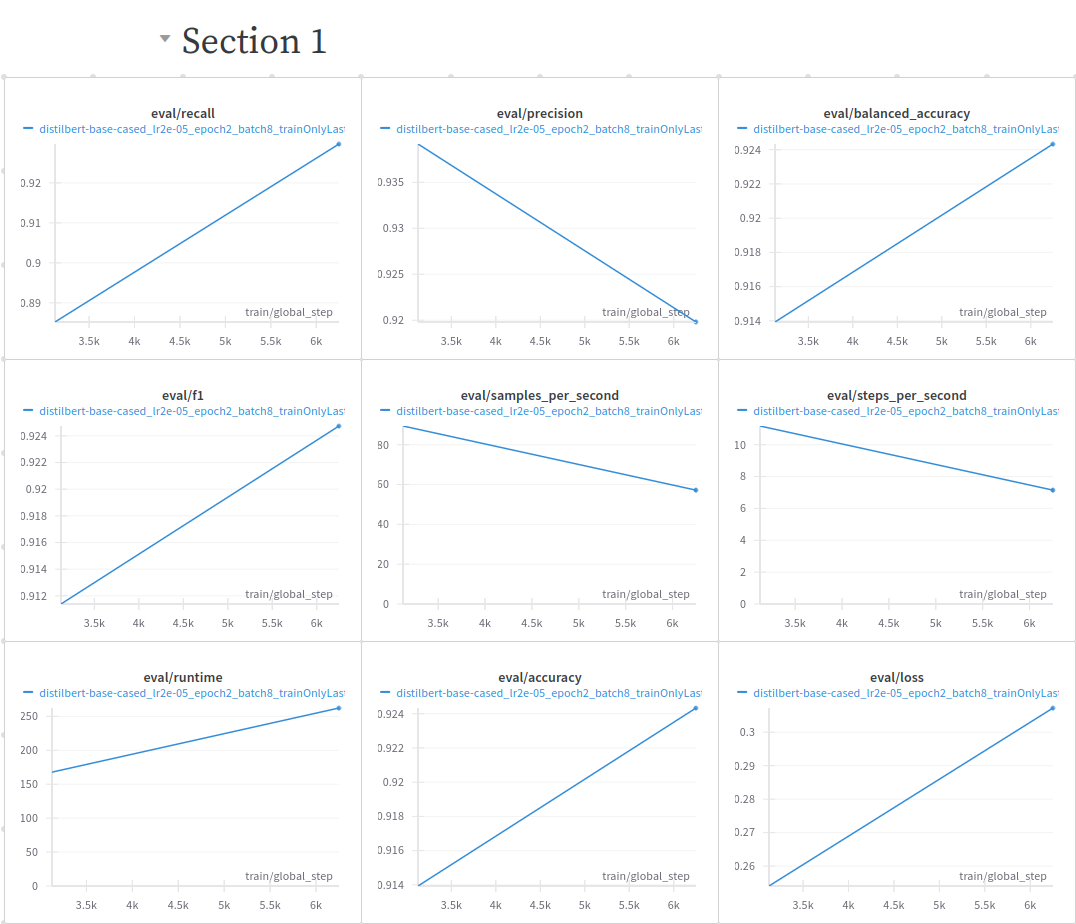
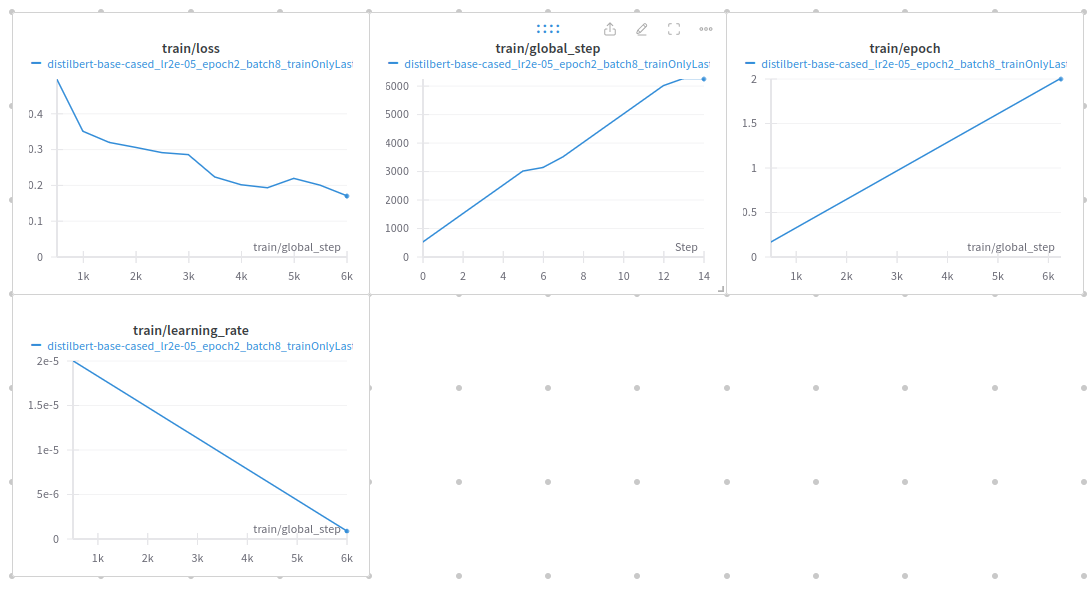

1 epoch = 3125 steps

### Make the training time longer with the same models, to see any change in performance

In [ ]:
baseline_transformer_longertraining = QuickSentimentAnalysisFinetuningModel("distilbert-base-cased", learning_rate=2e-5, num_epochs=6, batch_size=8, metrics_for_best_model = "accuracy")
baseline_transformer_longertraining.train_model(train_acl, val_acl, final_test_acl, "text", "integerLabel")

==== Model not initialized, initializing models with model name: distilbert-base-cased ====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: bryan-constantine7. Use `wandb login --relogin` to force relogin


  3%|▎         | 501/18750 [01:27<55:31,  5.48it/s]

{'loss': 0.4906, 'learning_rate': 2e-05, 'epoch': 0.16}


  5%|▌         | 1001/18750 [02:54<51:11,  5.78it/s]

{'loss': 0.3519, 'learning_rate': 1.945205479452055e-05, 'epoch': 0.32}


  8%|▊         | 1501/18750 [04:21<50:09,  5.73it/s]

{'loss': 0.3304, 'learning_rate': 1.8904109589041096e-05, 'epoch': 0.48}


 11%|█         | 2001/18750 [05:50<47:32,  5.87it/s]

{'loss': 0.3045, 'learning_rate': 1.8356164383561645e-05, 'epoch': 0.64}


 13%|█▎        | 2501/18750 [07:18<48:15,  5.61it/s]

{'loss': 0.3132, 'learning_rate': 1.7808219178082194e-05, 'epoch': 0.8}


 16%|█▌        | 3001/18750 [08:48<47:44,  5.50it/s]

{'loss': 0.2995, 'learning_rate': 1.726027397260274e-05, 'epoch': 0.96}


                                                    
 17%|█▋        | 3125/18750 [11:00<45:43,  5.69it/s]

{'eval_loss': 0.25089696049690247, 'eval_accuracy': 0.9186, 'eval_balanced_accuracy': 0.9186000000000001, 'eval_precision': 0.9293039792150964, 'eval_recall': 0.9061333333333333, 'eval_f1': 0.9175724026193208, 'eval_runtime': 109.5851, 'eval_samples_per_second': 136.88, 'eval_steps_per_second': 17.11, 'epoch': 1.0}


 19%|█▊        | 3501/18750 [12:07<47:03,  5.40it/s]    

{'loss': 0.2362, 'learning_rate': 1.671232876712329e-05, 'epoch': 1.12}


 21%|██▏       | 4001/18750 [13:36<45:19,  5.42it/s]

{'loss': 0.2162, 'learning_rate': 1.6164383561643838e-05, 'epoch': 1.28}


 24%|██▍       | 4501/18750 [15:06<42:29,  5.59it/s]

{'loss': 0.2117, 'learning_rate': 1.5616438356164384e-05, 'epoch': 1.44}


 27%|██▋       | 5001/18750 [16:34<37:32,  6.10it/s]

{'loss': 0.2315, 'learning_rate': 1.5068493150684933e-05, 'epoch': 1.6}


 29%|██▉       | 5501/18750 [18:03<35:45,  6.18it/s]

{'loss': 0.2313, 'learning_rate': 1.4520547945205482e-05, 'epoch': 1.76}


 32%|███▏      | 6001/18750 [19:32<38:55,  5.46it/s]

{'loss': 0.1948, 'learning_rate': 1.3972602739726029e-05, 'epoch': 1.92}


                                                    
 33%|███▎      | 6250/18750 [22:06<36:37,  5.69it/s]

{'eval_loss': 0.26588761806488037, 'eval_accuracy': 0.9212, 'eval_balanced_accuracy': 0.9212, 'eval_precision': 0.9357241379310345, 'eval_recall': 0.9045333333333333, 'eval_f1': 0.919864406779661, 'eval_runtime': 109.6352, 'eval_samples_per_second': 136.817, 'eval_steps_per_second': 17.102, 'epoch': 2.0}


 35%|███▍      | 6501/18750 [22:52<38:24,  5.32it/s]    

{'loss': 0.1718, 'learning_rate': 1.3424657534246576e-05, 'epoch': 2.08}


 37%|███▋      | 7001/18750 [24:21<36:37,  5.35it/s]

{'loss': 0.1048, 'learning_rate': 1.2876712328767125e-05, 'epoch': 2.24}


 40%|████      | 7501/18750 [25:50<35:12,  5.32it/s]

{'loss': 0.1312, 'learning_rate': 1.2328767123287673e-05, 'epoch': 2.4}


 43%|████▎     | 8001/18750 [27:20<30:28,  5.88it/s]

{'loss': 0.1293, 'learning_rate': 1.178082191780822e-05, 'epoch': 2.56}


 45%|████▌     | 8501/18750 [28:47<30:55,  5.52it/s]

{'loss': 0.1168, 'learning_rate': 1.1232876712328769e-05, 'epoch': 2.72}


 48%|████▊     | 9001/18750 [30:17<28:28,  5.70it/s]

{'loss': 0.1392, 'learning_rate': 1.0684931506849316e-05, 'epoch': 2.88}


                                                    
 50%|█████     | 9375/18750 [33:14<28:27,  5.49it/s]

{'eval_loss': 0.3720533847808838, 'eval_accuracy': 0.9244, 'eval_balanced_accuracy': 0.9244, 'eval_precision': 0.9111340738827176, 'eval_recall': 0.9405333333333333, 'eval_f1': 0.925600314919302, 'eval_runtime': 109.5738, 'eval_samples_per_second': 136.894, 'eval_steps_per_second': 17.112, 'epoch': 3.0}


 51%|█████     | 9501/18750 [33:38<27:25,  5.62it/s]   

{'loss': 0.1204, 'learning_rate': 1.0136986301369864e-05, 'epoch': 3.04}


 53%|█████▎    | 10001/18750 [35:07<23:48,  6.13it/s]

{'loss': 0.0686, 'learning_rate': 9.589041095890411e-06, 'epoch': 3.2}


 56%|█████▌    | 10501/18750 [36:36<24:59,  5.50it/s]

{'loss': 0.0692, 'learning_rate': 9.04109589041096e-06, 'epoch': 3.36}


 59%|█████▊    | 11001/18750 [38:06<21:56,  5.88it/s]

{'loss': 0.0622, 'learning_rate': 8.493150684931507e-06, 'epoch': 3.52}


 61%|██████▏   | 11501/18750 [39:34<20:49,  5.80it/s]

{'loss': 0.064, 'learning_rate': 7.945205479452055e-06, 'epoch': 3.68}


 64%|██████▍   | 12001/18750 [41:04<18:59,  5.93it/s]

{'loss': 0.077, 'learning_rate': 7.397260273972603e-06, 'epoch': 3.84}


 67%|██████▋   | 12500/18750 [42:33<19:15,  5.41it/s]

{'loss': 0.0704, 'learning_rate': 6.849315068493151e-06, 'epoch': 4.0}


                                                     
 67%|██████▋   | 12500/18750 [44:23<19:15,  5.41it/s]

{'eval_loss': 0.48536062240600586, 'eval_accuracy': 0.9184, 'eval_balanced_accuracy': 0.9184, 'eval_precision': 0.9371691278907773, 'eval_recall': 0.8969333333333334, 'eval_f1': 0.9166098923559068, 'eval_runtime': 109.6909, 'eval_samples_per_second': 136.748, 'eval_steps_per_second': 17.093, 'epoch': 4.0}


 69%|██████▉   | 13001/18750 [45:53<17:30,  5.47it/s]   

{'loss': 0.021, 'learning_rate': 6.301369863013699e-06, 'epoch': 4.16}


 72%|███████▏  | 13501/18750 [47:22<15:44,  5.56it/s]

{'loss': 0.0377, 'learning_rate': 5.753424657534246e-06, 'epoch': 4.32}


 75%|███████▍  | 14001/18750 [48:51<14:28,  5.47it/s]

{'loss': 0.0279, 'learning_rate': 5.2054794520547945e-06, 'epoch': 4.48}


 77%|███████▋  | 14501/18750 [50:20<12:47,  5.54it/s]

{'loss': 0.0402, 'learning_rate': 4.657534246575343e-06, 'epoch': 4.64}


 80%|████████  | 15001/18750 [51:49<11:37,  5.37it/s]

{'loss': 0.0276, 'learning_rate': 4.109589041095891e-06, 'epoch': 4.8}


 83%|████████▎ | 15501/18750 [53:19<10:13,  5.29it/s]

{'loss': 0.0204, 'learning_rate': 3.5616438356164386e-06, 'epoch': 4.96}


                                                     
 83%|████████▎ | 15625/18750 [55:31<09:45,  5.34it/s]

{'eval_loss': 0.6063114404678345, 'eval_accuracy': 0.9198, 'eval_balanced_accuracy': 0.9198, 'eval_precision': 0.9355374187301149, 'eval_recall': 0.9017333333333334, 'eval_f1': 0.9183243940525495, 'eval_runtime': 109.7273, 'eval_samples_per_second': 136.703, 'eval_steps_per_second': 17.088, 'epoch': 5.0}


 85%|████████▌ | 16001/18750 [56:39<08:26,  5.43it/s]   

{'loss': 0.0106, 'learning_rate': 3.0136986301369864e-06, 'epoch': 5.12}


 88%|████████▊ | 16501/18750 [58:07<06:03,  6.19it/s]

{'loss': 0.0146, 'learning_rate': 2.4657534246575345e-06, 'epoch': 5.28}


 91%|█████████ | 17001/18750 [59:36<05:09,  5.65it/s]

{'loss': 0.0158, 'learning_rate': 1.9178082191780823e-06, 'epoch': 5.44}


 93%|█████████▎| 17501/18750 [1:01:05<03:54,  5.32it/s]

{'loss': 0.0197, 'learning_rate': 1.3698630136986302e-06, 'epoch': 5.6}


 96%|█████████▌| 18001/18750 [1:02:34<02:08,  5.82it/s]

{'loss': 0.0127, 'learning_rate': 8.219178082191781e-07, 'epoch': 5.76}


 99%|█████████▊| 18501/18750 [1:04:03<00:42,  5.82it/s]

{'loss': 0.0095, 'learning_rate': 2.73972602739726e-07, 'epoch': 5.92}


                                                       
100%|██████████| 18750/18750 [1:06:37<00:00,  5.63it/s]

{'eval_loss': 0.6099664568901062, 'eval_accuracy': 0.9236, 'eval_balanced_accuracy': 0.9236, 'eval_precision': 0.9184668071654373, 'eval_recall': 0.9297333333333333, 'eval_f1': 0.9240657301881792, 'eval_runtime': 109.5899, 'eval_samples_per_second': 136.874, 'eval_steps_per_second': 17.109, 'epoch': 6.0}


Could not locate the best model at ./Bryan_model_checkpoints/checkpoint-9375/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.
100%|██████████| 18750/18750 [1:06:38<00:00,  5.63it/s]

{'train_runtime': 4000.0648, 'train_samples_per_second': 37.499, 'train_steps_per_second': 4.687, 'train_loss': 0.13332897495269774, 'epoch': 6.0}


FileNotFoundError: [Errno 2] No such file or directory: './Bryan_model_checkpoints/checkpoint-9375'

After 3 epochs, the model performance drops, so we have to stop at max 3 iteration
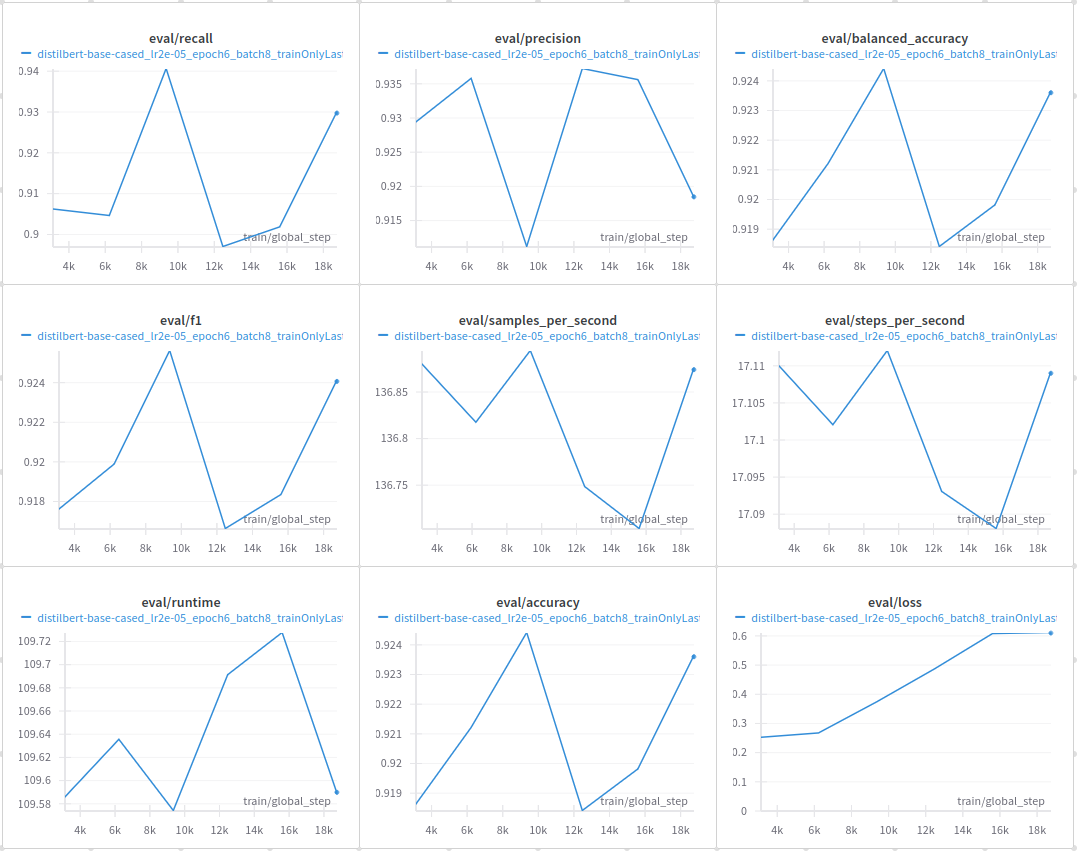
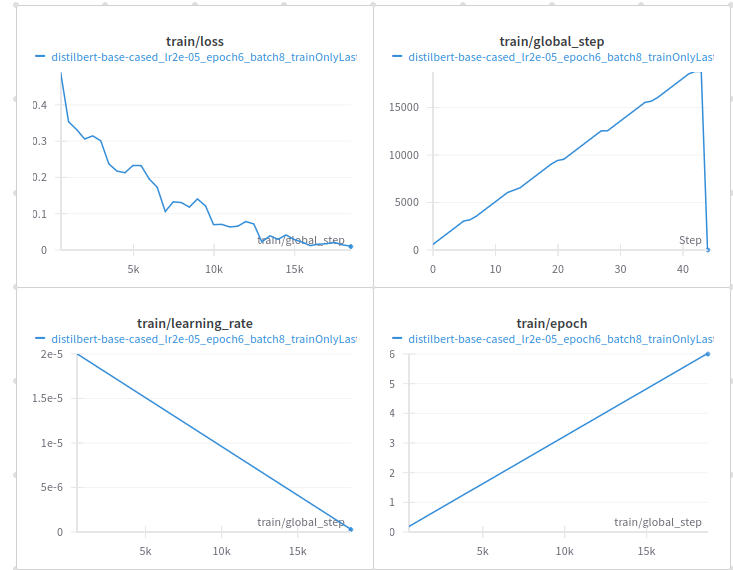

In [ ]:
baseline_transformer_longertraining.load_checkpoints("Bryan_model_checkpoints/checkpoint-9375")

In [ ]:
baseline_transformer_longertraining.inference_models(final_test_acl, "text", "integerLabel")

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 1250/1250 [01:09<00:00, 17.88it/s]

Inferenced results: 
{'eval_loss': 0.3786012828350067, 'eval_accuracy': 0.9231, 'eval_balanced_accuracy': 0.9231, 'eval_precision': 0.9124585689218171, 'eval_recall': 0.936, 'eval_f1': 0.9240793760489684, 'eval_runtime': 69.9907, 'eval_samples_per_second': 142.876, 'eval_steps_per_second': 17.86}


{'eval_loss': 0.3786012828350067,
 'eval_accuracy': 0.9231,
 'eval_balanced_accuracy': 0.9231,
 'eval_precision': 0.9124585689218171,
 'eval_recall': 0.936,
 'eval_f1': 0.9240793760489684,
 'eval_runtime': 69.9907,
 'eval_samples_per_second': 142.876,
 'eval_steps_per_second': 17.86}

In [ ]:
#save the models
baseline_transformer_longertraining.save_models_and_tokenizer("Bryan_model_checkpoints/")

In [ ]:
baseline_transformer_uncased = QuickSentimentAnalysisFinetuningModel("distilbert-base-uncased", learning_rate=2e-5, num_epochs=4, batch_size=8, metrics_for_best_model = "accuracy")
baseline_transformer_uncased.train_model(train_acl, val_acl, final_test_acl, "text", "integerLabel")

==== Model not initialized, initializing models with model name: distilbert-base-uncased ====


tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 65.1kB/s]
config.json: 100%|██████████| 483/483 [00:00<00:00, 246kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 620kB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 2.05MB/s]
model.safetensors: 100%|██████████| 268M/268M [00:08<00:00, 32.7MB/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mvc/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2163: UserWarning: Run (lohg6sop) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
100%|██████████| 18750/18750 [1:18:

  4%|▍         | 501/12500 [01:25<36:43,  5.45it/s]

{'loss': 0.452, 'learning_rate': 2e-05, 'epoch': 0.16}


  8%|▊         | 1001/12500 [02:52<33:24,  5.74it/s]

{'loss': 0.328, 'learning_rate': 1.916666666666667e-05, 'epoch': 0.32}


 12%|█▏        | 1501/12500 [04:20<31:59,  5.73it/s]

{'loss': 0.2967, 'learning_rate': 1.8333333333333333e-05, 'epoch': 0.48}


 16%|█▌        | 2001/12500 [05:48<29:34,  5.92it/s]

{'loss': 0.2948, 'learning_rate': 1.7500000000000002e-05, 'epoch': 0.64}


 20%|██        | 2501/12500 [07:16<29:25,  5.66it/s]

{'loss': 0.2774, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.8}


 24%|██▍       | 3001/12500 [08:45<28:45,  5.50it/s]

{'loss': 0.2704, 'learning_rate': 1.5833333333333333e-05, 'epoch': 0.96}


 25%|██▌       | 3125/12500 [10:54<27:30,  5.68it/s]

{'eval_loss': 0.20810599625110626, 'eval_accuracy': 0.9260666666666667, 'eval_balanced_accuracy': 0.9260666666666666, 'eval_precision': 0.9207373271889401, 'eval_recall': 0.9324, 'eval_f1': 0.926531964226565, 'eval_runtime': 106.8612, 'eval_samples_per_second': 140.369, 'eval_steps_per_second': 17.546, 'epoch': 1.0}


 28%|██▊       | 3501/12500 [12:01<27:26,  5.46it/s]   

{'loss': 0.1977, 'learning_rate': 1.5000000000000002e-05, 'epoch': 1.12}


 32%|███▏      | 4001/12500 [13:29<25:34,  5.54it/s]

{'loss': 0.1906, 'learning_rate': 1.416666666666667e-05, 'epoch': 1.28}


 36%|███▌      | 4501/12500 [14:58<23:19,  5.71it/s]

{'loss': 0.1906, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.44}


 40%|████      | 5001/12500 [16:25<20:21,  6.14it/s]

{'loss': 0.1974, 'learning_rate': 1.25e-05, 'epoch': 1.6}


 44%|████▍     | 5501/12500 [17:54<18:31,  6.30it/s]

{'loss': 0.2039, 'learning_rate': 1.1666666666666668e-05, 'epoch': 1.76}


 48%|████▊     | 6001/12500 [19:21<19:41,  5.50it/s]

{'loss': 0.1661, 'learning_rate': 1.0833333333333334e-05, 'epoch': 1.92}


 50%|█████     | 6250/12500 [21:53<17:43,  5.88it/s]

{'eval_loss': 0.29529204964637756, 'eval_accuracy': 0.9156666666666666, 'eval_balanced_accuracy': 0.9156666666666666, 'eval_precision': 0.9577154602848333, 'eval_recall': 0.8697333333333334, 'eval_f1': 0.9116064565718678, 'eval_runtime': 107.3418, 'eval_samples_per_second': 139.741, 'eval_steps_per_second': 17.468, 'epoch': 2.0}


 52%|█████▏    | 6501/12500 [22:38<18:38,  5.36it/s]   

{'loss': 0.1424, 'learning_rate': 1e-05, 'epoch': 2.08}


 56%|█████▌    | 7001/12500 [24:06<17:02,  5.38it/s]

{'loss': 0.0985, 'learning_rate': 9.166666666666666e-06, 'epoch': 2.24}


 60%|██████    | 7501/12500 [25:35<15:26,  5.39it/s]

{'loss': 0.0978, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.4}


 64%|██████▍   | 8001/12500 [27:03<12:42,  5.90it/s]

{'loss': 0.0909, 'learning_rate': 7.500000000000001e-06, 'epoch': 2.56}


 68%|██████▊   | 8501/12500 [28:31<11:57,  5.58it/s]

{'loss': 0.108, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.72}


 72%|███████▏  | 9001/12500 [30:00<10:21,  5.63it/s]

{'loss': 0.0919, 'learning_rate': 5.833333333333334e-06, 'epoch': 2.88}


 75%|███████▌  | 9375/12500 [32:55<09:19,  5.59it/s]

{'eval_loss': 0.3277478516101837, 'eval_accuracy': 0.9288, 'eval_balanced_accuracy': 0.9288, 'eval_precision': 0.9106230847803881, 'eval_recall': 0.9509333333333333, 'eval_f1': 0.9303417688494651, 'eval_runtime': 108.1829, 'eval_samples_per_second': 138.654, 'eval_steps_per_second': 17.332, 'epoch': 3.0}


 76%|███████▌  | 9501/12500 [33:18<08:43,  5.73it/s]   

{'loss': 0.0904, 'learning_rate': 5e-06, 'epoch': 3.04}


 80%|████████  | 10001/12500 [34:47<06:46,  6.15it/s]

{'loss': 0.0551, 'learning_rate': 4.166666666666667e-06, 'epoch': 3.2}


 84%|████████▍ | 10501/12500 [36:17<06:00,  5.54it/s]

{'loss': 0.0524, 'learning_rate': 3.3333333333333333e-06, 'epoch': 3.36}


 88%|████████▊ | 11001/12500 [37:46<04:06,  6.07it/s]

{'loss': 0.0525, 'learning_rate': 2.5e-06, 'epoch': 3.52}


 92%|█████████▏| 11501/12500 [39:15<02:49,  5.90it/s]

{'loss': 0.0392, 'learning_rate': 1.6666666666666667e-06, 'epoch': 3.68}


 96%|█████████▌| 12001/12500 [40:44<01:25,  5.85it/s]

{'loss': 0.0439, 'learning_rate': 8.333333333333333e-07, 'epoch': 3.84}


100%|██████████| 12500/12500 [42:13<00:00,  5.54it/s]

{'loss': 0.0484, 'learning_rate': 0.0, 'epoch': 4.0}



100%|██████████| 12500/12500 [44:01<00:00,  5.54it/s]

{'eval_loss': 0.38673627376556396, 'eval_accuracy': 0.9320666666666667, 'eval_balanced_accuracy': 0.9320666666666667, 'eval_precision': 0.9259892204548442, 'eval_recall': 0.9392, 'eval_f1': 0.9325478255113524, 'eval_runtime': 108.1361, 'eval_samples_per_second': 138.714, 'eval_steps_per_second': 17.339, 'epoch': 4.0}


100%|██████████| 12500/12500 [44:02<00:00,  4.73it/s]


{'train_runtime': 2643.6097, 'train_samples_per_second': 37.827, 'train_steps_per_second': 4.728, 'train_loss': 0.1630699914550781, 'epoch': 4.0}


100%|██████████| 1250/1250 [01:11<00:00, 17.48it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▅▁▆▇█
eval/balanced_accuracy,▅▁▆▇█
eval/f1,▆▁▇██
eval/loss,▁▄▆██
eval/precision,▃█▁▃▃
eval/recall,▆▁█▇▇
eval/runtime,████▁
eval/samples_per_second,█▅▁▁▅
eval/steps_per_second,█▅▁▁▅
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇█████
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████


Test results: 
{'eval_loss': 0.38096776604652405, 'eval_accuracy': 0.9334, 'eval_balanced_accuracy': 0.9334, 'eval_precision': 0.9262391817466562, 'eval_recall': 0.9418, 'eval_f1': 0.9339547798492661, 'eval_runtime': 71.5788, 'eval_samples_per_second': 139.706, 'eval_steps_per_second': 17.463, 'epoch': 4.0}


(DistilBertForSequenceClassification(
   (distilbert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0-5): 6 x TransformerBlock(
           (attention): MultiHeadSelfAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=True)
           )
           (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
           (ffn): FFN(
             (dropout): Dropout(p=

In [ ]:
baseline_transformer_uncased.inference_models(val_acl, "text", "integerLabel")

100%|██████████| 1875/1875 [01:43<00:00, 17.68it/s]

100%|██████████| 1875/1875 [01:43<00:00, 18.04it/s]


Inferenced results: 
{'eval_loss': 0.38673627376556396, 'eval_accuracy': 0.9320666666666667, 'eval_balanced_accuracy': 0.9320666666666667, 'eval_precision': 0.9259892204548442, 'eval_recall': 0.9392, 'eval_f1': 0.9325478255113524, 'eval_runtime': 103.1282, 'eval_samples_per_second': 145.45, 'eval_steps_per_second': 18.181}


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁
eval/balanced_accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/global_step,▁
eval/accuracy,0.93207


{'eval_loss': 0.38673627376556396,
 'eval_accuracy': 0.9320666666666667,
 'eval_balanced_accuracy': 0.9320666666666667,
 'eval_precision': 0.9259892204548442,
 'eval_recall': 0.9392,
 'eval_f1': 0.9325478255113524,
 'eval_runtime': 103.1282,
 'eval_samples_per_second': 145.45,
 'eval_steps_per_second': 18.181}

In [ ]:
baseline_transformer_uncased.inference_models(final_test_acl, "text", "integerLabel")

100%|██████████| 1250/1250 [01:09<00:00, 17.47it/s]

100%|██████████| 1250/1250 [01:10<00:00, 17.67it/s]


Inferenced results: 
{'eval_loss': 0.38096776604652405, 'eval_accuracy': 0.9334, 'eval_balanced_accuracy': 0.9334, 'eval_precision': 0.9262391817466562, 'eval_recall': 0.9418, 'eval_f1': 0.9339547798492661, 'eval_runtime': 69.8877, 'eval_samples_per_second': 143.087, 'eval_steps_per_second': 17.886}


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁
eval/balanced_accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/global_step,▁
eval/accuracy,0.9334


{'eval_loss': 0.38096776604652405,
 'eval_accuracy': 0.9334,
 'eval_balanced_accuracy': 0.9334,
 'eval_precision': 0.9262391817466562,
 'eval_recall': 0.9418,
 'eval_f1': 0.9339547798492661,
 'eval_runtime': 69.8877,
 'eval_samples_per_second': 143.087,
 'eval_steps_per_second': 17.886}

In [ ]:
baseline_transformer_uncased.save_models_and_tokenizer("Bryan_model_checkpoints/")

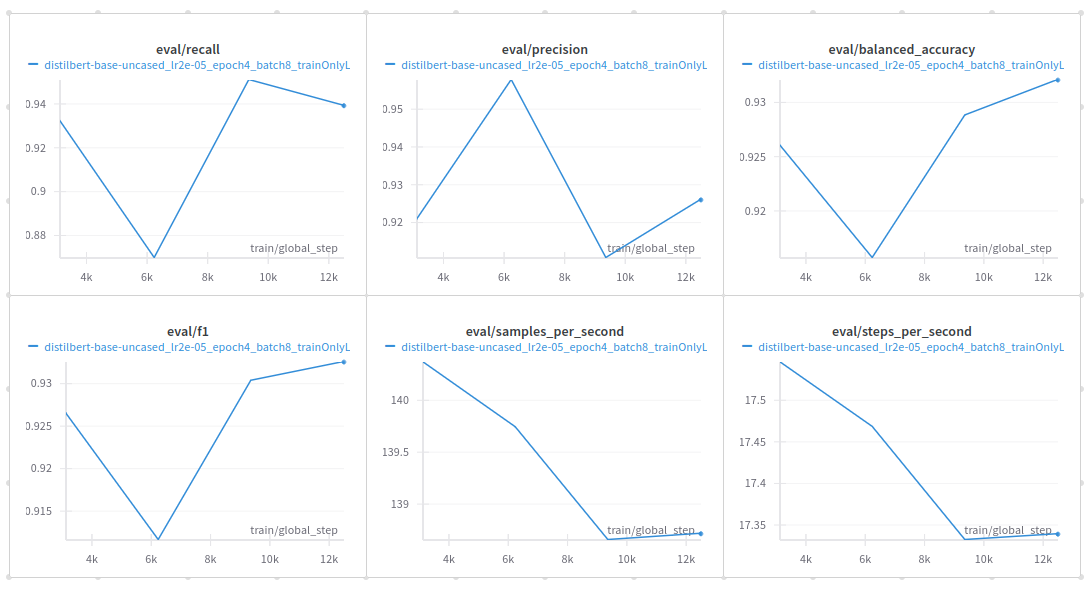
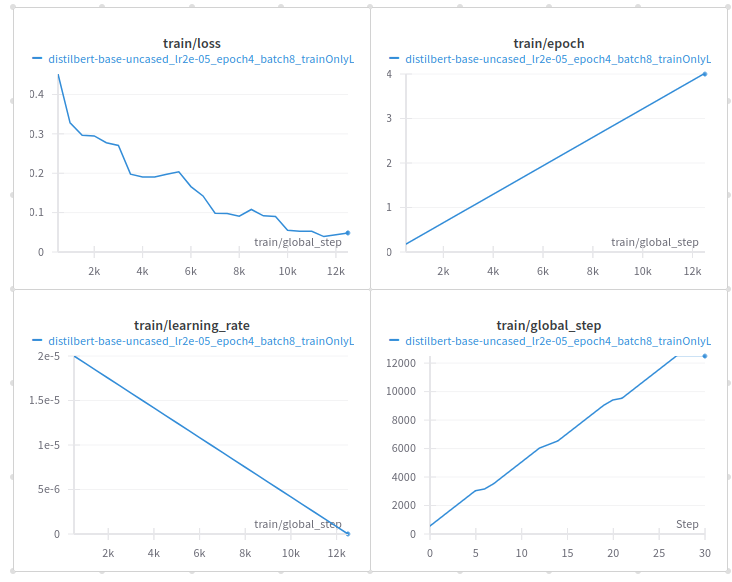

## Try with bigger model, which is currently the SOTA: XLNet

In [ ]:
XLNet_cased = QuickSentimentAnalysisFinetuningModel("xlnet-base-cased", learning_rate=2e-5, num_epochs=8, batch_size=8, metrics_for_best_model = "accuracy")
XLNet_cased.train_model(train_acl, val_acl, final_test_acl, "text", "integerLabel")

==== Model not initialized, initializing models with model name: xlnet-base-cased ====


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/25000 [00:00<?, ?it/s]You're using a XLNetTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


OutOfMemoryError: CUDA out of memory. Tried to allocate 216.00 MiB (GPU 0; 7.79 GiB total capacity; 7.42 GiB already allocated; 119.62 MiB free; 7.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

model can't fit to my PC

## Try Original BERT (Uncased, because we already know that uncased works much better in distilled version)

In [ ]:
BERT_uncased = QuickSentimentAnalysisFinetuningModel("bert-base-uncased", learning_rate=2e-5, num_epochs=8, batch_size=8, metrics_for_best_model = "accuracy")
BERT_uncased.train_model(train_acl, val_acl, final_test_acl, "text", "integerLabel")

==== Model not initialized, initializing models with model name: bert-base-uncased ====


tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 40.9kB/s]
config.json: 100%|██████████| 570/570 [00:00<00:00, 419kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 600kB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 801kB/s]
model.safetensors: 100%|██████████| 440M/440M [00:03<00:00, 112MB/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.79 GiB total capacity; 7.57 GiB already allocated; 19.62 MiB free; 7.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Can't Fit to my PC Either

## Try RoBERTa

In [ ]:
RoBERTa = QuickSentimentAnalysisFinetuningModel("roberta-base", learning_rate=2e-5, num_epochs=8, batch_size=8, metrics_for_best_model = "accuracy")
RoBERTa.train_model(train_acl, val_acl, final_test_acl, "text", "integerLabel")

==== Model not initialized, initializing models with model name: roberta-base ====


config.json: 100%|██████████| 481/481 [00:00<00:00, 1.19MB/s]
vocab.json: 100%|██████████| 899k/899k [00:00<00:00, 1.54MB/s]
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 781kB/s]
tokenizer.json: 100%|██████████| 1.36M/1.36M [00:00<00:00, 1.38MB/s]
model.safetensors: 100%|██████████| 499M/499M [00:27<00:00, 17.9MB/s] 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  2%|▏         | 500/25000 [02:43<2:20:33,  2.91it/s]

{'loss': 0.4675, 'learning_rate': 2e-05, 'epoch': 0.16}


  4%|▍         | 1000/25000 [05:30<2:16:08,  2.94it/s]

{'loss': 0.3282, 'learning_rate': 1.9591836734693877e-05, 'epoch': 0.32}


  6%|▌         | 1500/25000 [08:17<2:04:12,  3.15it/s]

{'loss': 0.2985, 'learning_rate': 1.9183673469387756e-05, 'epoch': 0.48}


  8%|▊         | 2000/25000 [11:07<2:09:56,  2.95it/s]

{'loss': 0.2631, 'learning_rate': 1.8775510204081636e-05, 'epoch': 0.64}


 10%|█         | 2500/25000 [13:55<2:04:13,  3.02it/s]

{'loss': 0.2689, 'learning_rate': 1.836734693877551e-05, 'epoch': 0.8}


 12%|█▏        | 3000/25000 [16:46<2:04:53,  2.94it/s]

{'loss': 0.2784, 'learning_rate': 1.795918367346939e-05, 'epoch': 0.96}


                                                      
 12%|█▎        | 3125/25000 [20:51<2:04:38,  2.93it/s]

{'eval_loss': 0.209447979927063, 'eval_accuracy': 0.9462666666666667, 'eval_balanced_accuracy': 0.9462666666666666, 'eval_precision': 0.9496238581407845, 'eval_recall': 0.9425333333333333, 'eval_f1': 0.9460653104925053, 'eval_runtime': 202.3532, 'eval_samples_per_second': 74.128, 'eval_steps_per_second': 9.266, 'epoch': 1.0}


 14%|█▍        | 3500/25000 [22:58<2:01:53,  2.94it/s]  

{'loss': 0.1799, 'learning_rate': 1.7551020408163266e-05, 'epoch': 1.12}


 16%|█▌        | 4000/25000 [25:48<1:59:34,  2.93it/s]

{'loss': 0.1896, 'learning_rate': 1.7142857142857142e-05, 'epoch': 1.28}


 18%|█▊        | 4500/25000 [28:39<2:01:49,  2.80it/s]

{'loss': 0.1722, 'learning_rate': 1.673469387755102e-05, 'epoch': 1.44}


 20%|██        | 5000/25000 [31:26<1:37:09,  3.43it/s]

{'loss': 0.1924, 'learning_rate': 1.63265306122449e-05, 'epoch': 1.6}


 22%|██▏       | 5500/25000 [34:16<1:33:09,  3.49it/s]

{'loss': 0.1996, 'learning_rate': 1.5918367346938776e-05, 'epoch': 1.76}


 24%|██▍       | 6000/25000 [37:05<1:48:52,  2.91it/s]

{'loss': 0.1791, 'learning_rate': 1.5510204081632655e-05, 'epoch': 1.92}


                                                      
 25%|██▌       | 6250/25000 [41:53<1:41:56,  3.07it/s]

{'eval_loss': 0.2660180926322937, 'eval_accuracy': 0.9451333333333334, 'eval_balanced_accuracy': 0.9451333333333334, 'eval_precision': 0.9614374568071873, 'eval_recall': 0.9274666666666667, 'eval_f1': 0.9441465897522905, 'eval_runtime': 203.3798, 'eval_samples_per_second': 73.754, 'eval_steps_per_second': 9.219, 'epoch': 2.0}


 26%|██▌       | 6500/25000 [43:19<1:50:45,  2.78it/s]  

{'loss': 0.1481, 'learning_rate': 1.510204081632653e-05, 'epoch': 2.08}


 28%|██▊       | 7000/25000 [46:09<1:47:06,  2.80it/s]

{'loss': 0.1029, 'learning_rate': 1.469387755102041e-05, 'epoch': 2.24}


 30%|███       | 7500/25000 [48:58<1:44:00,  2.80it/s]

{'loss': 0.0889, 'learning_rate': 1.4285714285714287e-05, 'epoch': 2.4}


 32%|███▏      | 8000/25000 [51:49<1:26:55,  3.26it/s]

{'loss': 0.1125, 'learning_rate': 1.3877551020408165e-05, 'epoch': 2.56}


 34%|███▍      | 8500/25000 [54:36<1:30:41,  3.03it/s]

{'loss': 0.1003, 'learning_rate': 1.3469387755102042e-05, 'epoch': 2.72}


 36%|███▌      | 9000/25000 [57:27<1:27:40,  3.04it/s]

{'loss': 0.1004, 'learning_rate': 1.3061224489795918e-05, 'epoch': 2.88}


                                                      
 38%|███▊      | 9375/25000 [1:02:58<1:28:13,  2.95it/s]

{'eval_loss': 0.32136958837509155, 'eval_accuracy': 0.9475333333333333, 'eval_balanced_accuracy': 0.9475333333333333, 'eval_precision': 0.9493908153701968, 'eval_recall': 0.9454666666666667, 'eval_f1': 0.9474246776671789, 'eval_runtime': 203.2593, 'eval_samples_per_second': 73.797, 'eval_steps_per_second': 9.225, 'epoch': 3.0}


 38%|███▊      | 9500/25000 [1:03:42<1:24:08,  3.07it/s]  

{'loss': 0.0974, 'learning_rate': 1.2653061224489798e-05, 'epoch': 3.04}


 40%|████      | 10001/25000 [1:06:33<1:17:20,  3.23it/s]

{'loss': 0.068, 'learning_rate': 1.2244897959183674e-05, 'epoch': 3.2}


 42%|████▏     | 10500/25000 [1:09:23<1:20:37,  3.00it/s]

{'loss': 0.0387, 'learning_rate': 1.1836734693877552e-05, 'epoch': 3.36}


 44%|████▍     | 11000/25000 [1:12:14<1:09:42,  3.35it/s]

{'loss': 0.0726, 'learning_rate': 1.1428571428571429e-05, 'epoch': 3.52}


 46%|████▌     | 11500/25000 [1:15:03<1:08:59,  3.26it/s]

{'loss': 0.0588, 'learning_rate': 1.1020408163265306e-05, 'epoch': 3.68}


 48%|████▊     | 12000/25000 [1:17:54<1:17:39,  2.79it/s]

{'loss': 0.0755, 'learning_rate': 1.0612244897959186e-05, 'epoch': 3.84}


 50%|█████     | 12500/25000 [1:20:44<1:12:43,  2.86it/s]

{'loss': 0.052, 'learning_rate': 1.0204081632653063e-05, 'epoch': 4.0}


                                                         
 50%|█████     | 12500/25000 [1:24:07<1:12:43,  2.86it/s]

{'eval_loss': 0.3548499345779419, 'eval_accuracy': 0.9484, 'eval_balanced_accuracy': 0.9483999999999999, 'eval_precision': 0.952502691065662, 'eval_recall': 0.9438666666666666, 'eval_f1': 0.9481650147334583, 'eval_runtime': 203.1855, 'eval_samples_per_second': 73.824, 'eval_steps_per_second': 9.228, 'epoch': 4.0}


 52%|█████▏    | 13000/25000 [1:26:59<1:07:59,  2.94it/s]  

{'loss': 0.0364, 'learning_rate': 9.795918367346939e-06, 'epoch': 4.16}


 54%|█████▍    | 13500/25000 [1:29:48<1:03:42,  3.01it/s]

{'loss': 0.0389, 'learning_rate': 9.387755102040818e-06, 'epoch': 4.32}


 56%|█████▌    | 14000/25000 [1:32:38<1:04:32,  2.84it/s]

{'loss': 0.0276, 'learning_rate': 8.979591836734695e-06, 'epoch': 4.48}


 58%|█████▊    | 14500/25000 [1:35:26<1:00:20,  2.90it/s]

{'loss': 0.0574, 'learning_rate': 8.571428571428571e-06, 'epoch': 4.64}


 60%|██████    | 15000/25000 [1:38:15<59:27,  2.80it/s]  

{'loss': 0.047, 'learning_rate': 8.16326530612245e-06, 'epoch': 4.8}


 62%|██████▏   | 15500/25000 [1:41:07<56:26,  2.81it/s]  

{'loss': 0.0393, 'learning_rate': 7.755102040816327e-06, 'epoch': 4.96}


                                                       
 62%|██████▎   | 15625/25000 [1:45:14<55:00,  2.84it/s]

{'eval_loss': 0.3513631820678711, 'eval_accuracy': 0.9476666666666667, 'eval_balanced_accuracy': 0.9476666666666667, 'eval_precision': 0.9517018700390152, 'eval_recall': 0.9432, 'eval_f1': 0.9474318623183553, 'eval_runtime': 204.1038, 'eval_samples_per_second': 73.492, 'eval_steps_per_second': 9.187, 'epoch': 5.0}


 64%|██████▍   | 16000/25000 [1:47:23<52:52,  2.84it/s]    

{'loss': 0.0255, 'learning_rate': 7.346938775510205e-06, 'epoch': 5.12}


 66%|██████▌   | 16500/25000 [1:50:12<40:47,  3.47it/s]

{'loss': 0.0246, 'learning_rate': 6.938775510204082e-06, 'epoch': 5.28}


 68%|██████▊   | 17000/25000 [1:53:01<43:48,  3.04it/s]

{'loss': 0.0345, 'learning_rate': 6.530612244897959e-06, 'epoch': 5.44}


 70%|███████   | 17500/25000 [1:55:52<45:15,  2.76it/s]

{'loss': 0.0225, 'learning_rate': 6.122448979591837e-06, 'epoch': 5.6}


 72%|███████▏  | 18000/25000 [1:58:41<35:13,  3.31it/s]

{'loss': 0.0194, 'learning_rate': 5.7142857142857145e-06, 'epoch': 5.76}


 74%|███████▍  | 18500/25000 [2:01:32<36:56,  2.93it/s]

{'loss': 0.0297, 'learning_rate': 5.306122448979593e-06, 'epoch': 5.92}


                                                       
 75%|███████▌  | 18750/25000 [2:06:19<35:20,  2.95it/s]

{'eval_loss': 0.37847110629081726, 'eval_accuracy': 0.9473333333333334, 'eval_balanced_accuracy': 0.9473333333333334, 'eval_precision': 0.9276064236553658, 'eval_recall': 0.9704, 'eval_f1': 0.9485207871758112, 'eval_runtime': 203.5151, 'eval_samples_per_second': 73.705, 'eval_steps_per_second': 9.213, 'epoch': 6.0}


 76%|███████▌  | 19000/25000 [2:07:45<35:55,  2.78it/s]    

{'loss': 0.0182, 'learning_rate': 4.897959183673469e-06, 'epoch': 6.08}


 78%|███████▊  | 19500/25000 [2:10:34<31:02,  2.95it/s]

{'loss': 0.0211, 'learning_rate': 4.489795918367348e-06, 'epoch': 6.24}


 80%|████████  | 20000/25000 [2:13:24<25:30,  3.27it/s]

{'loss': 0.0168, 'learning_rate': 4.081632653061225e-06, 'epoch': 6.4}


 82%|████████▏ | 20500/25000 [2:16:14<24:37,  3.05it/s]

{'loss': 0.0159, 'learning_rate': 3.6734693877551024e-06, 'epoch': 6.56}


 84%|████████▍ | 21000/25000 [2:19:04<20:44,  3.21it/s]

{'loss': 0.0174, 'learning_rate': 3.2653061224489794e-06, 'epoch': 6.72}


 86%|████████▌ | 21500/25000 [2:21:51<20:32,  2.84it/s]

{'loss': 0.0191, 'learning_rate': 2.8571428571428573e-06, 'epoch': 6.88}


                                                       
 88%|████████▊ | 21875/25000 [2:27:21<14:53,  3.50it/s]

{'eval_loss': 0.3614543676376343, 'eval_accuracy': 0.951, 'eval_balanced_accuracy': 0.951, 'eval_precision': 0.9386590584878745, 'eval_recall': 0.9650666666666666, 'eval_f1': 0.9516797054763001, 'eval_runtime': 203.2938, 'eval_samples_per_second': 73.785, 'eval_steps_per_second': 9.223, 'epoch': 7.0}


 88%|████████▊ | 22000/25000 [2:28:06<17:33,  2.85it/s]   

{'loss': 0.0157, 'learning_rate': 2.4489795918367347e-06, 'epoch': 7.04}


 90%|█████████ | 22500/25000 [2:30:54<15:07,  2.76it/s]

{'loss': 0.0123, 'learning_rate': 2.0408163265306125e-06, 'epoch': 7.2}


 92%|█████████▏| 23000/25000 [2:33:43<11:09,  2.99it/s]

{'loss': 0.0039, 'learning_rate': 1.6326530612244897e-06, 'epoch': 7.36}


 94%|█████████▍| 23500/25000 [2:36:34<09:00,  2.78it/s]

{'loss': 0.018, 'learning_rate': 1.2244897959183673e-06, 'epoch': 7.52}


 96%|█████████▌| 24001/25000 [2:39:24<04:56,  3.37it/s]

{'loss': 0.006, 'learning_rate': 8.163265306122449e-07, 'epoch': 7.68}


 98%|█████████▊| 24500/25000 [2:42:14<02:48,  2.96it/s]

{'loss': 0.0111, 'learning_rate': 4.0816326530612243e-07, 'epoch': 7.84}


100%|██████████| 25000/25000 [2:45:05<00:00,  2.91it/s]

{'loss': 0.0143, 'learning_rate': 0.0, 'epoch': 8.0}


                                                       
100%|██████████| 25000/25000 [2:48:28<00:00,  2.91it/s]

{'eval_loss': 0.3712219297885895, 'eval_accuracy': 0.9515333333333333, 'eval_balanced_accuracy': 0.9515333333333333, 'eval_precision': 0.9427376127598379, 'eval_recall': 0.9614666666666667, 'eval_f1': 0.9520100336655885, 'eval_runtime': 203.4465, 'eval_samples_per_second': 73.729, 'eval_steps_per_second': 9.216, 'epoch': 8.0}


100%|██████████| 25000/25000 [2:48:30<00:00,  2.47it/s]


{'train_runtime': 10111.5263, 'train_samples_per_second': 19.779, 'train_steps_per_second': 2.472, 'train_loss': 0.09451708050251006, 'epoch': 8.0}


100%|██████████| 1250/1250 [02:14<00:00,  9.30it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▂▁▄▅▄▃▇█▇
eval/balanced_accuracy,▂▁▄▅▄▃▇█▇
eval/f1,▃▁▄▅▄▅██▇
eval/loss,▁▃▆▇▇█▇██
eval/precision,▆█▆▆▆▁▃▄▅
eval/recall,▃▁▄▄▄█▇▇▆
eval/runtime,████████▁
eval/samples_per_second,▇▃▄▄▁▃▄▃█
eval/steps_per_second,▇▃▄▄▁▃▄▃█
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████


Test results: 
{'eval_loss': 0.3724908232688904, 'eval_accuracy': 0.9508, 'eval_balanced_accuracy': 0.9508, 'eval_precision': 0.9454545454545454, 'eval_recall': 0.9568, 'eval_f1': 0.9510934393638171, 'eval_runtime': 134.5935, 'eval_samples_per_second': 74.298, 'eval_steps_per_second': 9.287, 'epoch': 8.0}


(RobertaForSequenceClassification(
   (roberta): RobertaModel(
     (embeddings): RobertaEmbeddings(
       (word_embeddings): Embedding(50265, 768, padding_idx=1)
       (position_embeddings): Embedding(514, 768, padding_idx=1)
       (token_type_embeddings): Embedding(1, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): RobertaEncoder(
       (layer): ModuleList(
         (0-11): 12 x RobertaLayer(
           (attention): RobertaAttention(
             (self): RobertaSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): RobertaSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bia

In [ ]:
## Store Roberta
RoBERTa.save_models_and_tokenizer("Bryan_model_checkpoints/")

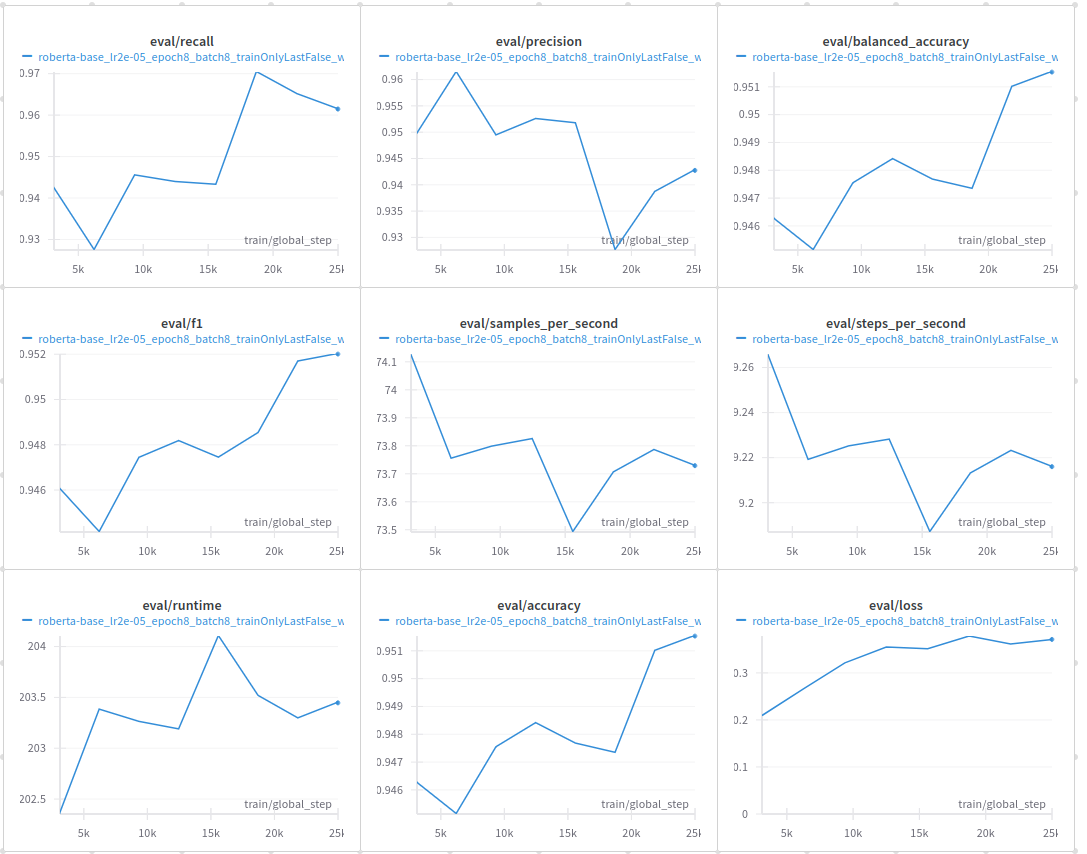
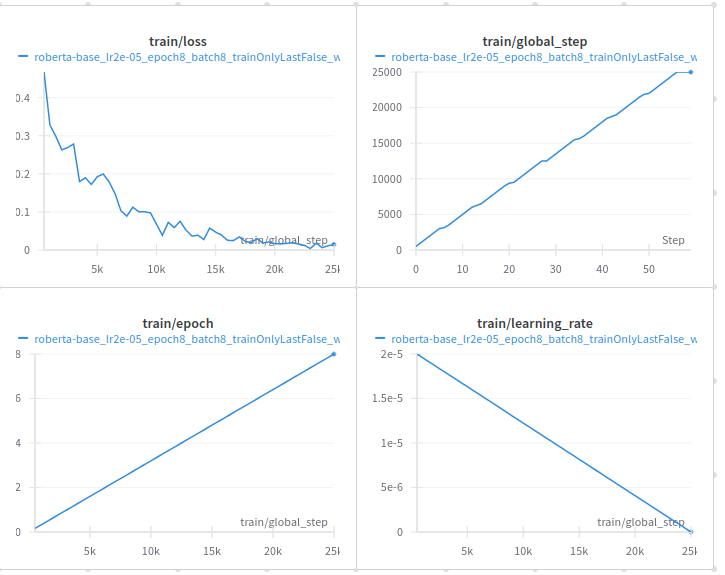

## Try Roberta once more but with denoised_text

In [ ]:
RoBERTa_denoised_text = QuickSentimentAnalysisFinetuningModel("roberta-base", learning_rate=2e-5, num_epochs=8, batch_size=8, metrics_for_best_model = "accuracy", checkpoint_path="denoised_text_checkpoints")
RoBERTa_denoised_text.train_model(train_acl, val_acl, final_test_acl, "denoised_text", "integerLabel")

==== Model not initialized, initializing models with model name: roberta-base ====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  2%|▏         | 500/25000 [02:36<2:09:50,  3.14it/s]

{'loss': 0.4588, 'learning_rate': 2e-05, 'epoch': 0.16}


  4%|▍         | 1000/25000 [05:16<2:08:16,  3.12it/s]

{'loss': 0.3649, 'learning_rate': 1.9591836734693877e-05, 'epoch': 0.32}


  6%|▌         | 1500/25000 [07:56<1:55:21,  3.40it/s]

{'loss': 0.3027, 'learning_rate': 1.9183673469387756e-05, 'epoch': 0.48}


  8%|▊         | 2000/25000 [10:38<1:57:28,  3.26it/s]

{'loss': 0.2938, 'learning_rate': 1.8775510204081636e-05, 'epoch': 0.64}


 10%|█         | 2500/25000 [13:19<2:00:51,  3.10it/s]

{'loss': 0.2848, 'learning_rate': 1.836734693877551e-05, 'epoch': 0.8}


 12%|█▏        | 3000/25000 [16:03<1:59:52,  3.06it/s]

{'loss': 0.2831, 'learning_rate': 1.795918367346939e-05, 'epoch': 0.96}


                                                      
 12%|█▎        | 3125/25000 [19:57<2:02:38,  2.97it/s]

{'eval_loss': 0.246129110455513, 'eval_accuracy': 0.9361333333333334, 'eval_balanced_accuracy': 0.9361333333333333, 'eval_precision': 0.9473468271334792, 'eval_recall': 0.9236, 'eval_f1': 0.9353227113151499, 'eval_runtime': 193.9398, 'eval_samples_per_second': 77.344, 'eval_steps_per_second': 9.668, 'epoch': 1.0}


 14%|█▍        | 3500/25000 [21:59<1:50:53,  3.23it/s]  

{'loss': 0.2091, 'learning_rate': 1.7551020408163266e-05, 'epoch': 1.12}


 16%|█▌        | 4000/25000 [24:42<1:58:20,  2.96it/s]

{'loss': 0.2114, 'learning_rate': 1.7142857142857142e-05, 'epoch': 1.28}


 18%|█▊        | 4500/25000 [27:26<2:01:05,  2.82it/s]

{'loss': 0.1999, 'learning_rate': 1.673469387755102e-05, 'epoch': 1.44}


 20%|██        | 5000/25000 [30:07<1:31:02,  3.66it/s]

{'loss': 0.2123, 'learning_rate': 1.63265306122449e-05, 'epoch': 1.6}


 22%|██▏       | 5500/25000 [32:48<1:25:50,  3.79it/s]

{'loss': 0.2156, 'learning_rate': 1.5918367346938776e-05, 'epoch': 1.76}


 24%|██▍       | 6000/25000 [35:31<1:47:43,  2.94it/s]

{'loss': 0.2115, 'learning_rate': 1.5510204081632655e-05, 'epoch': 1.92}


                                                      
 25%|██▌       | 6250/25000 [40:05<1:39:40,  3.14it/s]

{'eval_loss': 0.30173397064208984, 'eval_accuracy': 0.9386666666666666, 'eval_balanced_accuracy': 0.9386666666666668, 'eval_precision': 0.9574527252502781, 'eval_recall': 0.9181333333333334, 'eval_f1': 0.9373808875578546, 'eval_runtime': 193.8672, 'eval_samples_per_second': 77.373, 'eval_steps_per_second': 9.672, 'epoch': 2.0}


 26%|██▌       | 6500/25000 [41:28<1:50:15,  2.80it/s]  

{'loss': 0.1635, 'learning_rate': 1.510204081632653e-05, 'epoch': 2.08}


 28%|██▊       | 7000/25000 [44:12<1:46:02,  2.83it/s]

{'loss': 0.1222, 'learning_rate': 1.469387755102041e-05, 'epoch': 2.24}


 30%|███       | 7500/25000 [46:54<1:38:20,  2.97it/s]

{'loss': 0.1312, 'learning_rate': 1.4285714285714287e-05, 'epoch': 2.4}


 32%|███▏      | 8000/25000 [49:37<1:24:01,  3.37it/s]

{'loss': 0.1237, 'learning_rate': 1.3877551020408165e-05, 'epoch': 2.56}


 34%|███▍      | 8500/25000 [52:18<1:27:18,  3.15it/s]

{'loss': 0.1151, 'learning_rate': 1.3469387755102042e-05, 'epoch': 2.72}


 36%|███▌      | 9000/25000 [55:02<1:25:37,  3.11it/s]

{'loss': 0.1279, 'learning_rate': 1.3061224489795918e-05, 'epoch': 2.88}


                                                      
 38%|███▊      | 9375/25000 [1:00:20<1:23:50,  3.11it/s]

{'eval_loss': 0.28295958042144775, 'eval_accuracy': 0.943, 'eval_balanced_accuracy': 0.9430000000000001, 'eval_precision': 0.9533360622185837, 'eval_recall': 0.9316, 'eval_f1': 0.9423427068581832, 'eval_runtime': 194.1248, 'eval_samples_per_second': 77.27, 'eval_steps_per_second': 9.659, 'epoch': 3.0}


 38%|███▊      | 9500/25000 [1:01:02<1:20:39,  3.20it/s]  

{'loss': 0.1353, 'learning_rate': 1.2653061224489798e-05, 'epoch': 3.04}


 40%|████      | 10001/25000 [1:03:46<1:13:25,  3.40it/s]

{'loss': 0.0678, 'learning_rate': 1.2244897959183674e-05, 'epoch': 3.2}


 42%|████▏     | 10500/25000 [1:06:30<1:15:47,  3.19it/s]

{'loss': 0.0676, 'learning_rate': 1.1836734693877552e-05, 'epoch': 3.36}


 44%|████▍     | 11000/25000 [1:09:14<1:03:28,  3.68it/s]

{'loss': 0.0669, 'learning_rate': 1.1428571428571429e-05, 'epoch': 3.52}


 46%|████▌     | 11500/25000 [1:11:56<1:02:48,  3.58it/s]

{'loss': 0.0817, 'learning_rate': 1.1020408163265306e-05, 'epoch': 3.68}


 48%|████▊     | 12001/25000 [1:14:40<1:06:56,  3.24it/s]

{'loss': 0.0715, 'learning_rate': 1.0612244897959186e-05, 'epoch': 3.84}


 50%|█████     | 12500/25000 [1:17:23<1:08:58,  3.02it/s]

{'loss': 0.0999, 'learning_rate': 1.0204081632653063e-05, 'epoch': 4.0}


                                                         
 50%|█████     | 12500/25000 [1:20:37<1:08:58,  3.02it/s]

{'eval_loss': 0.3353825509548187, 'eval_accuracy': 0.9434, 'eval_balanced_accuracy': 0.9434, 'eval_precision': 0.9429865458905022, 'eval_recall': 0.9438666666666666, 'eval_f1': 0.9434264010128607, 'eval_runtime': 194.117, 'eval_samples_per_second': 77.273, 'eval_steps_per_second': 9.659, 'epoch': 4.0}


 52%|█████▏    | 13000/25000 [1:23:23<1:06:58,  2.99it/s]  

{'loss': 0.0408, 'learning_rate': 9.795918367346939e-06, 'epoch': 4.16}


 54%|█████▍    | 13500/25000 [1:26:05<1:02:27,  3.07it/s]

{'loss': 0.0517, 'learning_rate': 9.387755102040818e-06, 'epoch': 4.32}


 56%|█████▌    | 14000/25000 [1:28:49<1:02:09,  2.95it/s]

{'loss': 0.0434, 'learning_rate': 8.979591836734695e-06, 'epoch': 4.48}


 58%|█████▊    | 14500/25000 [1:31:30<1:00:03,  2.91it/s]

{'loss': 0.0476, 'learning_rate': 8.571428571428571e-06, 'epoch': 4.64}


 60%|██████    | 15000/25000 [1:34:13<59:23,  2.81it/s]  

{'loss': 0.0434, 'learning_rate': 8.16326530612245e-06, 'epoch': 4.8}


 62%|██████▏   | 15500/25000 [1:36:58<56:11,  2.82it/s]  

{'loss': 0.0408, 'learning_rate': 7.755102040816327e-06, 'epoch': 4.96}


                                                       
 62%|██████▎   | 15625/25000 [1:40:54<53:08,  2.94it/s]

{'eval_loss': 0.3720192015171051, 'eval_accuracy': 0.9398, 'eval_balanced_accuracy': 0.9398, 'eval_precision': 0.9567926879933527, 'eval_recall': 0.9212, 'eval_f1': 0.9386590584878745, 'eval_runtime': 194.4737, 'eval_samples_per_second': 77.131, 'eval_steps_per_second': 9.641, 'epoch': 5.0}


 64%|██████▍   | 16000/25000 [1:42:58<51:43,  2.90it/s]    

{'loss': 0.0441, 'learning_rate': 7.346938775510205e-06, 'epoch': 5.12}


 66%|██████▌   | 16500/25000 [1:45:41<38:42,  3.66it/s]

{'loss': 0.0355, 'learning_rate': 6.938775510204082e-06, 'epoch': 5.28}


 68%|██████▊   | 17000/25000 [1:48:22<42:02,  3.17it/s]

{'loss': 0.0347, 'learning_rate': 6.530612244897959e-06, 'epoch': 5.44}


 70%|███████   | 17500/25000 [1:51:07<45:06,  2.77it/s]

{'loss': 0.0198, 'learning_rate': 6.122448979591837e-06, 'epoch': 5.6}


 72%|███████▏  | 18000/25000 [1:53:49<33:23,  3.49it/s]

{'loss': 0.0305, 'learning_rate': 5.7142857142857145e-06, 'epoch': 5.76}


 74%|███████▍  | 18500/25000 [1:56:33<32:56,  3.29it/s]

{'loss': 0.0406, 'learning_rate': 5.306122448979593e-06, 'epoch': 5.92}


                                                       
 75%|███████▌  | 18750/25000 [2:01:08<34:06,  3.05it/s]

{'eval_loss': 0.37443608045578003, 'eval_accuracy': 0.9427333333333333, 'eval_balanced_accuracy': 0.9427333333333333, 'eval_precision': 0.9479293133684068, 'eval_recall': 0.9369333333333333, 'eval_f1': 0.9423992489774022, 'eval_runtime': 194.5461, 'eval_samples_per_second': 77.103, 'eval_steps_per_second': 9.638, 'epoch': 6.0}


 76%|███████▌  | 19000/25000 [2:02:32<35:47,  2.79it/s]    

{'loss': 0.0229, 'learning_rate': 4.897959183673469e-06, 'epoch': 6.08}


 78%|███████▊  | 19500/25000 [2:05:14<28:02,  3.27it/s]

{'loss': 0.0167, 'learning_rate': 4.489795918367348e-06, 'epoch': 6.24}


 80%|████████  | 20000/25000 [2:07:58<23:37,  3.53it/s]

{'loss': 0.0198, 'learning_rate': 4.081632653061225e-06, 'epoch': 6.4}


 82%|████████▏ | 20500/25000 [2:10:41<23:18,  3.22it/s]

{'loss': 0.0168, 'learning_rate': 3.6734693877551024e-06, 'epoch': 6.56}


 84%|████████▍ | 21000/25000 [2:13:25<18:25,  3.62it/s]

{'loss': 0.019, 'learning_rate': 3.2653061224489794e-06, 'epoch': 6.72}


 86%|████████▌ | 21500/25000 [2:16:05<20:17,  2.87it/s]

{'loss': 0.0207, 'learning_rate': 2.8571428571428573e-06, 'epoch': 6.88}


                                                       
 88%|████████▊ | 21875/25000 [2:21:22<13:59,  3.72it/s]

{'eval_loss': 0.4272337853908539, 'eval_accuracy': 0.9437333333333333, 'eval_balanced_accuracy': 0.9437333333333333, 'eval_precision': 0.9350326797385621, 'eval_recall': 0.9537333333333333, 'eval_f1': 0.9442904290429043, 'eval_runtime': 194.4139, 'eval_samples_per_second': 77.155, 'eval_steps_per_second': 9.644, 'epoch': 7.0}


 88%|████████▊ | 22000/25000 [2:22:05<16:50,  2.97it/s]   

{'loss': 0.0168, 'learning_rate': 2.4489795918367347e-06, 'epoch': 7.04}


 90%|█████████ | 22500/25000 [2:24:46<15:00,  2.78it/s]

{'loss': 0.008, 'learning_rate': 2.0408163265306125e-06, 'epoch': 7.2}


 92%|█████████▏| 23000/25000 [2:27:29<10:46,  3.09it/s]

{'loss': 0.0096, 'learning_rate': 1.6326530612244897e-06, 'epoch': 7.36}


 94%|█████████▍| 23500/25000 [2:30:13<08:28,  2.95it/s]

{'loss': 0.0184, 'learning_rate': 1.2244897959183673e-06, 'epoch': 7.52}


 96%|█████████▌| 24001/25000 [2:32:57<04:49,  3.45it/s]

{'loss': 0.0103, 'learning_rate': 8.163265306122449e-07, 'epoch': 7.68}


 98%|█████████▊| 24500/25000 [2:35:41<02:33,  3.26it/s]

{'loss': 0.0208, 'learning_rate': 4.0816326530612243e-07, 'epoch': 7.84}


100%|██████████| 25000/25000 [2:38:26<00:00,  3.02it/s]

{'loss': 0.0099, 'learning_rate': 0.0, 'epoch': 8.0}


                                                       
100%|██████████| 25000/25000 [2:41:41<00:00,  3.02it/s]

{'eval_loss': 0.43048879504203796, 'eval_accuracy': 0.9454666666666667, 'eval_balanced_accuracy': 0.9454666666666667, 'eval_precision': 0.9436918990703851, 'eval_recall': 0.9474666666666667, 'eval_f1': 0.9455755156353958, 'eval_runtime': 195.2463, 'eval_samples_per_second': 76.826, 'eval_steps_per_second': 9.603, 'epoch': 8.0}


100%|██████████| 25000/25000 [2:41:43<00:00,  2.58it/s]


{'train_runtime': 9705.0578, 'train_samples_per_second': 20.608, 'train_steps_per_second': 2.576, 'train_loss': 0.10609539281845093, 'epoch': 8.0}


100%|██████████| 1250/1250 [02:08<00:00,  9.72it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁▃▅▆▃▅▆▇█
eval/balanced_accuracy,▁▃▅▆▃▅▆▇█
eval/f1,▁▂▅▆▃▅▆▇█
eval/loss,▁▃▂▄▆▆███
eval/precision,▅█▇▃█▅▁▄▅
eval/recall,▂▁▄▆▂▅█▇▇
eval/runtime,████████▁
eval/samples_per_second,▅▆▅▅▄▃▄▁█
eval/steps_per_second,▅▆▅▅▄▃▄▁█
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████


Test results: 
{'eval_loss': 0.41899654269218445, 'eval_accuracy': 0.9469, 'eval_balanced_accuracy': 0.9469000000000001, 'eval_precision': 0.9475265371520128, 'eval_recall': 0.9462, 'eval_f1': 0.946862803962774, 'eval_runtime': 128.7661, 'eval_samples_per_second': 77.66, 'eval_steps_per_second': 9.708, 'epoch': 8.0}


(RobertaForSequenceClassification(
   (roberta): RobertaModel(
     (embeddings): RobertaEmbeddings(
       (word_embeddings): Embedding(50265, 768, padding_idx=1)
       (position_embeddings): Embedding(514, 768, padding_idx=1)
       (token_type_embeddings): Embedding(1, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): RobertaEncoder(
       (layer): ModuleList(
         (0-11): 12 x RobertaLayer(
           (attention): RobertaAttention(
             (self): RobertaSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): RobertaSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bia

Result is a bit worse

## Try Roberta Once more but with denoised text (cased)

In [ ]:
RoBERTa_denoised_text_cased = QuickSentimentAnalysisFinetuningModel("roberta-base", learning_rate=2e-5, num_epochs=8, batch_size=8, metrics_for_best_model = "accuracy", checkpoint_path="denoised_text_cased_checkpoints")
RoBERTa_denoised_text_cased.train_model(train_acl, val_acl, final_test_acl, "denoised_text_cased", "integerLabel")

==== Model not initialized, initializing models with model name: roberta-base ====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  2%|▏         | 500/25000 [02:36<2:10:20,  3.13it/s]

{'loss': 0.4588, 'learning_rate': 2e-05, 'epoch': 0.16}


  4%|▍         | 1000/25000 [05:17<2:09:39,  3.09it/s]

{'loss': 0.3649, 'learning_rate': 1.9591836734693877e-05, 'epoch': 0.32}


  6%|▌         | 1500/25000 [07:58<1:56:01,  3.38it/s]

{'loss': 0.3027, 'learning_rate': 1.9183673469387756e-05, 'epoch': 0.48}


  8%|▊         | 2000/25000 [10:40<1:58:07,  3.25it/s]

{'loss': 0.2938, 'learning_rate': 1.8775510204081636e-05, 'epoch': 0.64}


 10%|█         | 2500/25000 [13:22<2:00:32,  3.11it/s]

{'loss': 0.2848, 'learning_rate': 1.836734693877551e-05, 'epoch': 0.8}


 12%|█▏        | 3000/25000 [16:07<2:00:13,  3.05it/s]

{'loss': 0.2831, 'learning_rate': 1.795918367346939e-05, 'epoch': 0.96}


                                                      
 12%|█▎        | 3125/25000 [20:03<2:03:19,  2.96it/s]

{'eval_loss': 0.246129110455513, 'eval_accuracy': 0.9361333333333334, 'eval_balanced_accuracy': 0.9361333333333333, 'eval_precision': 0.9473468271334792, 'eval_recall': 0.9236, 'eval_f1': 0.9353227113151499, 'eval_runtime': 194.9178, 'eval_samples_per_second': 76.956, 'eval_steps_per_second': 9.619, 'epoch': 1.0}


 14%|█▍        | 3500/25000 [22:05<1:52:14,  3.19it/s]  

{'loss': 0.2091, 'learning_rate': 1.7551020408163266e-05, 'epoch': 1.12}


 16%|█▌        | 4000/25000 [24:49<1:59:18,  2.93it/s]

{'loss': 0.2114, 'learning_rate': 1.7142857142857142e-05, 'epoch': 1.28}


 18%|█▊        | 4500/25000 [27:34<2:02:11,  2.80it/s]

{'loss': 0.1999, 'learning_rate': 1.673469387755102e-05, 'epoch': 1.44}


 20%|██        | 5000/25000 [30:16<1:31:25,  3.65it/s]

{'loss': 0.2123, 'learning_rate': 1.63265306122449e-05, 'epoch': 1.6}


 22%|██▏       | 5500/25000 [32:58<1:25:45,  3.79it/s]

{'loss': 0.2156, 'learning_rate': 1.5918367346938776e-05, 'epoch': 1.76}


 24%|██▍       | 6000/25000 [35:41<1:48:00,  2.93it/s]

{'loss': 0.2115, 'learning_rate': 1.5510204081632655e-05, 'epoch': 1.92}


                                                      
 25%|██▌       | 6250/25000 [40:17<1:40:57,  3.10it/s]

{'eval_loss': 0.30173397064208984, 'eval_accuracy': 0.9386666666666666, 'eval_balanced_accuracy': 0.9386666666666668, 'eval_precision': 0.9574527252502781, 'eval_recall': 0.9181333333333334, 'eval_f1': 0.9373808875578546, 'eval_runtime': 194.7529, 'eval_samples_per_second': 77.021, 'eval_steps_per_second': 9.628, 'epoch': 2.0}


 26%|██▌       | 6500/25000 [41:40<1:49:58,  2.80it/s]  

{'loss': 0.1635, 'learning_rate': 1.510204081632653e-05, 'epoch': 2.08}


 28%|██▊       | 7000/25000 [44:24<1:45:29,  2.84it/s]

{'loss': 0.1222, 'learning_rate': 1.469387755102041e-05, 'epoch': 2.24}


 30%|███       | 7500/25000 [47:07<1:38:45,  2.95it/s]

{'loss': 0.1312, 'learning_rate': 1.4285714285714287e-05, 'epoch': 2.4}


 32%|███▏      | 8000/25000 [49:50<1:24:24,  3.36it/s]

{'loss': 0.1237, 'learning_rate': 1.3877551020408165e-05, 'epoch': 2.56}


 34%|███▍      | 8500/25000 [52:30<1:27:41,  3.14it/s]

{'loss': 0.1151, 'learning_rate': 1.3469387755102042e-05, 'epoch': 2.72}


 36%|███▌      | 9000/25000 [55:15<1:26:19,  3.09it/s]

{'loss': 0.1279, 'learning_rate': 1.3061224489795918e-05, 'epoch': 2.88}


                                                      
 38%|███▊      | 9375/25000 [1:00:32<1:23:37,  3.11it/s]

{'eval_loss': 0.28295958042144775, 'eval_accuracy': 0.943, 'eval_balanced_accuracy': 0.9430000000000001, 'eval_precision': 0.9533360622185837, 'eval_recall': 0.9316, 'eval_f1': 0.9423427068581832, 'eval_runtime': 193.2903, 'eval_samples_per_second': 77.603, 'eval_steps_per_second': 9.7, 'epoch': 3.0}


 38%|███▊      | 9500/25000 [1:01:14<1:20:01,  3.23it/s]  

{'loss': 0.1353, 'learning_rate': 1.2653061224489798e-05, 'epoch': 3.04}


 40%|████      | 10001/25000 [1:03:58<1:13:39,  3.39it/s]

{'loss': 0.0678, 'learning_rate': 1.2244897959183674e-05, 'epoch': 3.2}


 42%|████▏     | 10500/25000 [1:06:42<1:16:43,  3.15it/s]

{'loss': 0.0676, 'learning_rate': 1.1836734693877552e-05, 'epoch': 3.36}


 44%|████▍     | 11000/25000 [1:09:26<1:03:35,  3.67it/s]

{'loss': 0.0669, 'learning_rate': 1.1428571428571429e-05, 'epoch': 3.52}


 46%|████▌     | 11500/25000 [1:12:08<1:02:48,  3.58it/s]

{'loss': 0.0817, 'learning_rate': 1.1020408163265306e-05, 'epoch': 3.68}


 48%|████▊     | 12001/25000 [1:14:51<1:06:47,  3.24it/s]

{'loss': 0.0715, 'learning_rate': 1.0612244897959186e-05, 'epoch': 3.84}


 50%|█████     | 12500/25000 [1:17:34<1:08:55,  3.02it/s]

{'loss': 0.0999, 'learning_rate': 1.0204081632653063e-05, 'epoch': 4.0}


                                                         
 50%|█████     | 12500/25000 [1:20:48<1:08:55,  3.02it/s]

{'eval_loss': 0.3353825509548187, 'eval_accuracy': 0.9434, 'eval_balanced_accuracy': 0.9434, 'eval_precision': 0.9429865458905022, 'eval_recall': 0.9438666666666666, 'eval_f1': 0.9434264010128607, 'eval_runtime': 193.137, 'eval_samples_per_second': 77.665, 'eval_steps_per_second': 9.708, 'epoch': 4.0}


 52%|█████▏    | 13000/25000 [1:23:32<1:06:28,  3.01it/s]  

{'loss': 0.0408, 'learning_rate': 9.795918367346939e-06, 'epoch': 4.16}


 54%|█████▍    | 13500/25000 [1:26:14<1:01:33,  3.11it/s]

{'loss': 0.0517, 'learning_rate': 9.387755102040818e-06, 'epoch': 4.32}


 56%|█████▌    | 14000/25000 [1:28:57<1:02:10,  2.95it/s]

{'loss': 0.0434, 'learning_rate': 8.979591836734695e-06, 'epoch': 4.48}


 58%|█████▊    | 14500/25000 [1:31:38<59:27,  2.94it/s]  

{'loss': 0.0476, 'learning_rate': 8.571428571428571e-06, 'epoch': 4.64}


 60%|██████    | 15000/25000 [1:34:19<59:29,  2.80it/s]  

{'loss': 0.0434, 'learning_rate': 8.16326530612245e-06, 'epoch': 4.8}


 62%|██████▏   | 15500/25000 [1:37:04<55:50,  2.84it/s]

{'loss': 0.0408, 'learning_rate': 7.755102040816327e-06, 'epoch': 4.96}


                                                       
 62%|██████▎   | 15625/25000 [1:40:58<52:42,  2.96it/s]

{'eval_loss': 0.3720192015171051, 'eval_accuracy': 0.9398, 'eval_balanced_accuracy': 0.9398, 'eval_precision': 0.9567926879933527, 'eval_recall': 0.9212, 'eval_f1': 0.9386590584878745, 'eval_runtime': 193.2814, 'eval_samples_per_second': 77.607, 'eval_steps_per_second': 9.701, 'epoch': 5.0}


 64%|██████▍   | 16000/25000 [1:43:02<52:00,  2.88it/s]    

{'loss': 0.0441, 'learning_rate': 7.346938775510205e-06, 'epoch': 5.12}


 66%|██████▌   | 16500/25000 [1:45:44<38:32,  3.68it/s]

{'loss': 0.0355, 'learning_rate': 6.938775510204082e-06, 'epoch': 5.28}


 68%|██████▊   | 17000/25000 [1:48:25<41:45,  3.19it/s]

{'loss': 0.0347, 'learning_rate': 6.530612244897959e-06, 'epoch': 5.44}


 70%|███████   | 17500/25000 [1:51:08<44:53,  2.78it/s]

{'loss': 0.0198, 'learning_rate': 6.122448979591837e-06, 'epoch': 5.6}


 72%|███████▏  | 18000/25000 [1:53:50<32:55,  3.54it/s]

{'loss': 0.0305, 'learning_rate': 5.7142857142857145e-06, 'epoch': 5.76}


 74%|███████▍  | 18500/25000 [1:56:33<32:47,  3.30it/s]

{'loss': 0.0406, 'learning_rate': 5.306122448979593e-06, 'epoch': 5.92}


                                                       
 75%|███████▌  | 18750/25000 [2:01:06<34:00,  3.06it/s]

{'eval_loss': 0.37443608045578003, 'eval_accuracy': 0.9427333333333333, 'eval_balanced_accuracy': 0.9427333333333333, 'eval_precision': 0.9479293133684068, 'eval_recall': 0.9369333333333333, 'eval_f1': 0.9423992489774022, 'eval_runtime': 193.2603, 'eval_samples_per_second': 77.616, 'eval_steps_per_second': 9.702, 'epoch': 6.0}


 76%|███████▌  | 19000/25000 [2:02:29<35:20,  2.83it/s]    

{'loss': 0.0229, 'learning_rate': 4.897959183673469e-06, 'epoch': 6.08}


 78%|███████▊  | 19500/25000 [2:05:11<28:00,  3.27it/s]

{'loss': 0.0167, 'learning_rate': 4.489795918367348e-06, 'epoch': 6.24}


 80%|████████  | 20000/25000 [2:07:54<23:29,  3.55it/s]

{'loss': 0.0198, 'learning_rate': 4.081632653061225e-06, 'epoch': 6.4}


 82%|████████▏ | 20500/25000 [2:10:37<23:22,  3.21it/s]

{'loss': 0.0168, 'learning_rate': 3.6734693877551024e-06, 'epoch': 6.56}


 84%|████████▍ | 21000/25000 [2:13:20<18:18,  3.64it/s]

{'loss': 0.019, 'learning_rate': 3.2653061224489794e-06, 'epoch': 6.72}


 86%|████████▌ | 21500/25000 [2:16:00<20:18,  2.87it/s]

{'loss': 0.0207, 'learning_rate': 2.8571428571428573e-06, 'epoch': 6.88}


                                                       
 88%|████████▊ | 21875/25000 [2:21:15<13:55,  3.74it/s]

{'eval_loss': 0.4272337853908539, 'eval_accuracy': 0.9437333333333333, 'eval_balanced_accuracy': 0.9437333333333333, 'eval_precision': 0.9350326797385621, 'eval_recall': 0.9537333333333333, 'eval_f1': 0.9442904290429043, 'eval_runtime': 192.9204, 'eval_samples_per_second': 77.752, 'eval_steps_per_second': 9.719, 'epoch': 7.0}


 88%|████████▊ | 22001/25000 [2:21:58<15:02,  3.32it/s]   

{'loss': 0.0168, 'learning_rate': 2.4489795918367347e-06, 'epoch': 7.04}


 90%|█████████ | 22500/25000 [2:24:38<14:58,  2.78it/s]

{'loss': 0.008, 'learning_rate': 2.0408163265306125e-06, 'epoch': 7.2}


 92%|█████████▏| 23000/25000 [2:27:19<10:44,  3.11it/s]

{'loss': 0.0096, 'learning_rate': 1.6326530612244897e-06, 'epoch': 7.36}


 94%|█████████▍| 23500/25000 [2:30:03<08:28,  2.95it/s]

{'loss': 0.0184, 'learning_rate': 1.2244897959183673e-06, 'epoch': 7.52}


 96%|█████████▌| 24001/25000 [2:32:46<04:47,  3.47it/s]

{'loss': 0.0103, 'learning_rate': 8.163265306122449e-07, 'epoch': 7.68}


 98%|█████████▊| 24500/25000 [2:35:29<02:33,  3.26it/s]

{'loss': 0.0208, 'learning_rate': 4.0816326530612243e-07, 'epoch': 7.84}


100%|██████████| 25000/25000 [2:38:12<00:00,  3.07it/s]

{'loss': 0.0099, 'learning_rate': 0.0, 'epoch': 8.0}


                                                       
100%|██████████| 25000/25000 [2:41:25<00:00,  3.07it/s]

{'eval_loss': 0.43048879504203796, 'eval_accuracy': 0.9454666666666667, 'eval_balanced_accuracy': 0.9454666666666667, 'eval_precision': 0.9436918990703851, 'eval_recall': 0.9474666666666667, 'eval_f1': 0.9455755156353958, 'eval_runtime': 193.153, 'eval_samples_per_second': 77.659, 'eval_steps_per_second': 9.707, 'epoch': 8.0}


100%|██████████| 25000/25000 [2:41:27<00:00,  2.58it/s]


{'train_runtime': 9689.5597, 'train_samples_per_second': 20.641, 'train_steps_per_second': 2.58, 'train_loss': 0.10609539281845093, 'epoch': 8.0}


100%|██████████| 1250/1250 [02:07<00:00,  9.82it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁▃▅▆▃▅▆▇█
eval/balanced_accuracy,▁▃▅▆▃▅▆▇█
eval/f1,▁▂▅▆▃▅▆▇█
eval/loss,▁▃▂▄▆▆███
eval/precision,▅█▇▃█▅▁▄▅
eval/recall,▂▁▄▆▂▅█▇▇
eval/runtime,████████▁
eval/samples_per_second,▁▁▄▄▄▄▅▄█
eval/steps_per_second,▁▁▄▄▄▄▅▄█
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████


Test results: 
{'eval_loss': 0.41899654269218445, 'eval_accuracy': 0.9469, 'eval_balanced_accuracy': 0.9469000000000001, 'eval_precision': 0.9475265371520128, 'eval_recall': 0.9462, 'eval_f1': 0.946862803962774, 'eval_runtime': 127.4395, 'eval_samples_per_second': 78.469, 'eval_steps_per_second': 9.809, 'epoch': 8.0}


(RobertaForSequenceClassification(
   (roberta): RobertaModel(
     (embeddings): RobertaEmbeddings(
       (word_embeddings): Embedding(50265, 768, padding_idx=1)
       (position_embeddings): Embedding(514, 768, padding_idx=1)
       (token_type_embeddings): Embedding(1, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): RobertaEncoder(
       (layer): ModuleList(
         (0-11): 12 x RobertaLayer(
           (attention): RobertaAttention(
             (self): RobertaSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): RobertaSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bia

Same, model stuck at 94.4, actually worse than the original Roberta

## Try Original RoBERTa but with Cross Validation on 5 Fold

In [10]:
RoBERTa = QuickSentimentAnalysisFinetuningModel("roberta-base", learning_rate=2e-5, num_epochs=8, batch_size=8, metrics_for_best_model = "accuracy", checkpoint_path="Bryan_CrossVal_Checkpoints")
RoBERTa.cross_validate(shuffled_acl, "text", "integerLabel")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  1%|▏         | 500/40000 [02:43<3:34:53,  3.06it/s]

{'loss': 0.4612, 'learning_rate': 2e-05, 'epoch': 0.1}


  2%|▏         | 846/40000 [04:36<3:39:37,  2.97it/s]

# Sentiment Labelled Sentences Dataset

Want to make sure that all forms of text are in form text\tlabel

In [25]:
filenames = ["sentiment labelled sentences/amazon_cells_labelled.txt", "sentiment labelled sentences/imdb_labelled.txt","sentiment labelled sentences/yelp_labelled.txt"]
for filename in filenames:
    with open(filename, "r") as f:
        for line in f.readlines():
            assert len(line.split('\t')) == 2

Convert each txt to csv of its own

In [27]:
for filename in filenames:
    csvName = filename.split('.')[0]
    csvName+=".csv"
    with open(filename, "r") as f:
        textList = []
        labelList = []
        for line in f.readlines():
            line = line.strip()
            textList.append(line.split('\t')[0])
            labelList.append(int(line.split('\t')[1]))
        csvContent = pd.DataFrame({'text': textList, 'integerLabel': labelList})
        csvContent.to_csv(csvName, index=False)

Split the dataset into 0.8 for train, 0.1 for val, 0.1 for test, in specific random seed

In [31]:
filenames = ["sentiment labelled sentences/amazon_cells_labelled.csv", "sentiment labelled sentences/imdb_labelled.csv","sentiment labelled sentences/yelp_labelled.csv"]
for filename in filenames:
    df = pd.read_csv(filename)
    csvFrontName = filename.split('.')[0]
    train, temp = train_test_split(df, test_size=0.2, random_state=42, stratify=df["integerLabel"])

    # Further splitting the temp dataset into validation and test sets
    val, test = train_test_split(temp, test_size=0.5, random_state=42, stratify=temp["integerLabel"])

    #save each to separate csv for further use
    train.to_csv(csvFrontName+"_train.csv", index=False)
    val.to_csv(csvFrontName+"_val.csv", index=False)
    test.to_csv(csvFrontName+"_test.csv", index=False)

Now make a merge dataset, but shuffle them to not make any bias

In [33]:
amz_train = pd.read_csv('sentiment labelled sentences/amazon_cells_labelled_train.csv')
amz_val = pd.read_csv('sentiment labelled sentences/amazon_cells_labelled_val.csv')
amz_test = pd.read_csv('sentiment labelled sentences/amazon_cells_labelled_test.csv')
imdb_train = pd.read_csv('sentiment labelled sentences/imdb_labelled_train.csv')
imdb_val = pd.read_csv('sentiment labelled sentences/imdb_labelled_val.csv')
imdb_test = pd.read_csv('sentiment labelled sentences/imdb_labelled_test.csv')
yelp_train = pd.read_csv('sentiment labelled sentences/yelp_labelled_train.csv')
yelp_val = pd.read_csv('sentiment labelled sentences/yelp_labelled_val.csv')
yelp_test = pd.read_csv('sentiment labelled sentences/yelp_labelled_test.csv')

# Concatenate the DataFrames
combined_train_df = pd.concat([amz_train, imdb_train, yelp_train])
combined_val_df = pd.concat([amz_val, imdb_val, yelp_val])
combined_test_df = pd.concat([amz_test, imdb_test, yelp_test])

# Shuffle the DataFrame with the specific random seed
shuffled_train_df = combined_train_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_val_df = combined_val_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_test_df = combined_test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the shuffled DataFrame to a new CSV file
shuffled_train_df.to_csv('sentiment labelled sentences/combined_train.csv', index=False)
shuffled_val_df.to_csv('sentiment labelled sentences/combined_val.csv', index=False)
shuffled_test_df.to_csv('sentiment labelled sentences/combined_test.csv', index=False)

## Load Combined CSV

In [37]:
sls_train = pd.read_csv('sentiment labelled sentences/combined_train.csv')
sls_val = pd.read_csv('sentiment labelled sentences/combined_val.csv')
sls_test = pd.read_csv('sentiment labelled sentences/combined_test.csv')

## Baseline Using TF-IDF approach

In [45]:
tfidf_transformer = TfidfVectorizer(stop_words = "english")
tfidf_transformer.fit(sls_train['text'])
Train_tfidf = tfidf_transformer.transform(x for x in sls_train['text'])
Val_tfidf = tfidf_transformer.transform(x for x in sls_val["text"])
Test_tfidf = tfidf_transformer.transform(x for x in sls_test["text"])
print(Train_tfidf)
print(Val_tfidf)
print(Test_tfidf)

  (0, 996)	1.0
  (1, 3318)	0.3037424060603467
  (1, 2914)	0.5780762586639827
  (1, 1344)	0.36226297904645033
  (1, 938)	0.43903845208414494
  (1, 258)	0.4995789842794358
  (2, 1440)	0.557372302381668
  (2, 536)	0.48927707630849826
  (2, 175)	0.670778696096385
  (3, 4075)	0.4111889158840664
  (3, 3914)	0.3661125458094332
  (3, 3203)	0.4111889158840664
  (3, 3200)	0.3415528287652841
  (3, 1320)	0.3456721947865283
  (3, 1295)	0.35012144903888864
  (3, 245)	0.4111889158840664
  (4, 4107)	0.21946460591130815
  (4, 4095)	0.726399764505504
  (4, 2345)	0.28049091066595827
  (4, 2290)	0.19934436324113747
  (4, 1866)	0.23579893562819396
  (4, 1733)	0.25420831178228764
  (4, 1662)	0.20284695401644018
  (4, 1529)	0.15881938753094052
  (4, 1282)	0.22792571289861696
  :	:
  (2396, 1462)	0.3179339725661888
  (2396, 1437)	0.2775648467489641
  (2396, 1081)	0.2592173581233265
  (2396, 882)	0.3284184105227914
  (2396, 581)	0.24662720034973767
  (2397, 4006)	0.36892184762859015
  (2397, 2862)	0.3803966462

In [46]:
#Using Naive bayes to summarize the TF-IDF
def runMNB(Xtrain, Ytrain, Xtest, Ytest):
    model = naive_bayes.MultinomialNB()
    model.fit(Xtrain, Ytrain)
    print("Accuracy: " , accuracy_score(model.predict(Xtest), Ytest))
    print("Balanced Accuracy: " , balanced_accuracy_score(model.predict(Xtest), Ytest))
    return model

modelMNB = runMNB(Train_tfidf, sls_train["integerLabel"], Val_tfidf, sls_val["integerLabel"])
modelMNB = runMNB(Train_tfidf, sls_train['integerLabel'], Test_tfidf, sls_test["integerLabel"])

Accuracy:  0.8133333333333334
Balanced Accuracy:  0.8133890469416785
Accuracy:  0.83
Balanced Accuracy:  0.8353810018519355


## Try Blind Inference with the previous problem best model: Roberta

In [36]:
RoBERTa_previous_best = QuickSentimentAnalysisFinetuningModel("roberta-base", learning_rate=2e-5, num_epochs=8, batch_size=8, metrics_for_best_model = "accuracy", checkpoint_path="denoised_text_cased_checkpoints")
RoBERTa_previous_best.load_checkpoints("Bryan_model_checkpoints/checkpoint_bestmodel_roberta-base_lr2e-05_epoch8_batch8_trainOnlyLastFalse_warmup500_weightDecay0.01")

In [39]:
RoBERTa_previous_best.inference_models(sls_train, "text", "integerLabel")

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
 97%|█████████▋| 291/300 [00:02<00:00, 97.45it/s] 

100%|██████████| 300/300 [00:03<00:00, 75.41it/s]


Inferenced results: 
{'eval_loss': 0.5318251252174377, 'eval_accuracy': 0.92, 'eval_balanced_accuracy': 0.9199999999999999, 'eval_precision': 0.8876923076923077, 'eval_recall': 0.9616666666666667, 'eval_f1': 0.9231999999999999, 'eval_runtime': 3.3654, 'eval_samples_per_second': 713.143, 'eval_steps_per_second': 89.143}


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁
eval/balanced_accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/global_step,▁
eval/accuracy,0.92


{'eval_loss': 0.5318251252174377,
 'eval_accuracy': 0.92,
 'eval_balanced_accuracy': 0.9199999999999999,
 'eval_precision': 0.8876923076923077,
 'eval_recall': 0.9616666666666667,
 'eval_f1': 0.9231999999999999,
 'eval_runtime': 3.3654,
 'eval_samples_per_second': 713.143,
 'eval_steps_per_second': 89.143}

In [40]:
RoBERTa_previous_best.inference_models(sls_val, "text", "integerLabel")

 84%|████████▍ | 32/38 [00:00<00:00, 96.30it/s]

100%|██████████| 38/38 [00:01<00:00, 28.39it/s]


Inferenced results: 
{'eval_loss': 0.5247842669487, 'eval_accuracy': 0.9166666666666666, 'eval_balanced_accuracy': 0.9166666666666667, 'eval_precision': 0.8787878787878788, 'eval_recall': 0.9666666666666667, 'eval_f1': 0.9206349206349207, 'eval_runtime': 0.423, 'eval_samples_per_second': 709.277, 'eval_steps_per_second': 89.842}


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁
eval/balanced_accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/global_step,▁
eval/accuracy,0.91667


{'eval_loss': 0.5247842669487,
 'eval_accuracy': 0.9166666666666666,
 'eval_balanced_accuracy': 0.9166666666666667,
 'eval_precision': 0.8787878787878788,
 'eval_recall': 0.9666666666666667,
 'eval_f1': 0.9206349206349207,
 'eval_runtime': 0.423,
 'eval_samples_per_second': 709.277,
 'eval_steps_per_second': 89.842}

In [41]:
RoBERTa_previous_best.inference_models(sls_test, "text", "integerLabel")

 87%|████████▋ | 33/38 [00:00<00:00, 102.07it/s]

100%|██████████| 38/38 [00:01<00:00, 21.07it/s] 


Inferenced results: 
{'eval_loss': 0.5826141238212585, 'eval_accuracy': 0.91, 'eval_balanced_accuracy': 0.9099999999999999, 'eval_precision': 0.8819875776397516, 'eval_recall': 0.9466666666666667, 'eval_f1': 0.9131832797427653, 'eval_runtime': 0.392, 'eval_samples_per_second': 765.236, 'eval_steps_per_second': 96.93}


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁
eval/balanced_accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/global_step,▁
eval/accuracy,0.91


{'eval_loss': 0.5826141238212585,
 'eval_accuracy': 0.91,
 'eval_balanced_accuracy': 0.9099999999999999,
 'eval_precision': 0.8819875776397516,
 'eval_recall': 0.9466666666666667,
 'eval_f1': 0.9131832797427653,
 'eval_runtime': 0.392,
 'eval_samples_per_second': 765.236,
 'eval_steps_per_second': 96.93}

## Try finetuning one batch

In [43]:
RoBERTa_finetuned_to_sbs = QuickSentimentAnalysisFinetuningModel("roberta-base", learning_rate=2e-5, num_epochs=8, batch_size=8, metrics_for_best_model = "accuracy", checkpoint_path="Bryan_model_checkpoints_finetuning_sbs")
RoBERTa_finetuned_to_sbs.load_checkpoints("Bryan_model_checkpoints/checkpoint_bestmodel_roberta-base_lr2e-05_epoch8_batch8_trainOnlyLastFalse_warmup500_weightDecay0.01")

In [47]:
RoBERTa_finetuned_to_sbs.train_model(sls_train, sls_val, sls_test, "text", "integerLabel")

  0%|          | 0/2400 [00:00<?, ?it/s]You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
                                                  
 12%|█▎        | 300/2400 [00:17<02:01, 17.24it/s]

{'eval_loss': 0.2531382143497467, 'eval_accuracy': 0.9466666666666667, 'eval_balanced_accuracy': 0.9466666666666667, 'eval_precision': 0.9294871794871795, 'eval_recall': 0.9666666666666667, 'eval_f1': 0.9477124183006537, 'eval_runtime': 0.409, 'eval_samples_per_second': 733.445, 'eval_steps_per_second': 92.903, 'epoch': 1.0}


 21%|██        | 504/2400 [00:31<01:48, 17.44it/s]

{'loss': 0.3004, 'learning_rate': 2e-05, 'epoch': 1.67}


                                                  
 25%|██▌       | 600/2400 [00:37<01:48, 16.59it/s]

{'eval_loss': 0.2785383462905884, 'eval_accuracy': 0.9533333333333334, 'eval_balanced_accuracy': 0.9533333333333334, 'eval_precision': 0.9533333333333334, 'eval_recall': 0.9533333333333334, 'eval_f1': 0.9533333333333334, 'eval_runtime': 0.4127, 'eval_samples_per_second': 726.834, 'eval_steps_per_second': 92.066, 'epoch': 2.0}


                                                  
 38%|███▊      | 900/2400 [00:57<01:29, 16.76it/s]

{'eval_loss': 0.26329201459884644, 'eval_accuracy': 0.96, 'eval_balanced_accuracy': 0.96, 'eval_precision': 0.9662162162162162, 'eval_recall': 0.9533333333333334, 'eval_f1': 0.9597315436241611, 'eval_runtime': 0.4206, 'eval_samples_per_second': 713.285, 'eval_steps_per_second': 90.349, 'epoch': 3.0}


 42%|████▏     | 1002/2400 [01:04<01:22, 17.01it/s]

{'loss': 0.0967, 'learning_rate': 1.4736842105263159e-05, 'epoch': 3.33}


                                                   
 50%|█████     | 1200/2400 [01:16<01:10, 16.92it/s]

{'eval_loss': 0.35101377964019775, 'eval_accuracy': 0.95, 'eval_balanced_accuracy': 0.95, 'eval_precision': 0.9591836734693877, 'eval_recall': 0.94, 'eval_f1': 0.9494949494949495, 'eval_runtime': 0.4149, 'eval_samples_per_second': 723.079, 'eval_steps_per_second': 91.59, 'epoch': 4.0}


 62%|██████▎   | 1500/2400 [01:35<00:52, 17.22it/s]

{'loss': 0.0284, 'learning_rate': 9.473684210526315e-06, 'epoch': 5.0}


                                                   
 62%|██████▎   | 1500/2400 [01:36<00:52, 17.22it/s]

{'eval_loss': 0.3444865345954895, 'eval_accuracy': 0.96, 'eval_balanced_accuracy': 0.96, 'eval_precision': 0.9539473684210527, 'eval_recall': 0.9666666666666667, 'eval_f1': 0.9602649006622516, 'eval_runtime': 0.3925, 'eval_samples_per_second': 764.287, 'eval_steps_per_second': 96.81, 'epoch': 5.0}


                                                   
 75%|███████▌  | 1800/2400 [01:55<00:35, 17.11it/s]

{'eval_loss': 0.3452291786670685, 'eval_accuracy': 0.9566666666666667, 'eval_balanced_accuracy': 0.9566666666666667, 'eval_precision': 0.9477124183006536, 'eval_recall': 0.9666666666666667, 'eval_f1': 0.9570957095709571, 'eval_runtime': 0.412, 'eval_samples_per_second': 728.214, 'eval_steps_per_second': 92.24, 'epoch': 6.0}


 84%|████████▎ | 2004/2400 [02:09<00:22, 17.45it/s]

{'loss': 0.013, 'learning_rate': 4.210526315789474e-06, 'epoch': 6.67}


                                                   
 88%|████████▊ | 2100/2400 [02:15<00:17, 16.83it/s]

{'eval_loss': 0.36331525444984436, 'eval_accuracy': 0.9566666666666667, 'eval_balanced_accuracy': 0.9566666666666667, 'eval_precision': 0.9477124183006536, 'eval_recall': 0.9666666666666667, 'eval_f1': 0.9570957095709571, 'eval_runtime': 0.4265, 'eval_samples_per_second': 703.428, 'eval_steps_per_second': 89.101, 'epoch': 7.0}


                                                   
100%|██████████| 2400/2400 [02:35<00:00, 17.55it/s]

{'eval_loss': 0.3570716977119446, 'eval_accuracy': 0.9566666666666667, 'eval_balanced_accuracy': 0.9566666666666667, 'eval_precision': 0.9419354838709677, 'eval_recall': 0.9733333333333334, 'eval_f1': 0.9573770491803278, 'eval_runtime': 0.4084, 'eval_samples_per_second': 734.488, 'eval_steps_per_second': 93.035, 'epoch': 8.0}


100%|██████████| 2400/2400 [02:37<00:00, 15.24it/s]


{'train_runtime': 158.226, 'train_samples_per_second': 121.345, 'train_steps_per_second': 15.168, 'train_loss': 0.09174807727336884, 'epoch': 8.0}


100%|██████████| 38/38 [00:00<00:00, 97.36it/s] 
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁▅█▃█▆▆▆▆
eval/balanced_accuracy,▁▅█▃█▆▆▆▆
eval/f1,▁▄█▂█▆▆▆▆
eval/loss,▁▃▂▇▇▇██▅
eval/precision,▁▆█▇▆▄▄▃▇
eval/recall,▇▄▄▁▇▇▇█▄
eval/runtime,▄▅▇▆▁▅█▄▄
eval/samples_per_second,▄▄▂▃█▄▁▅▅
eval/steps_per_second,▄▄▂▃█▄▁▅▅
train/epoch,▁▂▂▃▃▄▅▅▆▇▇███
train/global_step,▁▂▂▃▃▄▅▅▆▇▇███


Test results: 
{'eval_loss': 0.30828559398651123, 'eval_accuracy': 0.9566666666666667, 'eval_balanced_accuracy': 0.9566666666666667, 'eval_precision': 0.959731543624161, 'eval_recall': 0.9533333333333334, 'eval_f1': 0.9565217391304347, 'eval_runtime': 0.4086, 'eval_samples_per_second': 734.127, 'eval_steps_per_second': 92.989, 'epoch': 8.0}


(RobertaForSequenceClassification(
   (roberta): RobertaModel(
     (embeddings): RobertaEmbeddings(
       (word_embeddings): Embedding(50265, 768, padding_idx=1)
       (position_embeddings): Embedding(514, 768, padding_idx=1)
       (token_type_embeddings): Embedding(1, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): RobertaEncoder(
       (layer): ModuleList(
         (0-11): 12 x RobertaLayer(
           (attention): RobertaAttention(
             (self): RobertaSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): RobertaSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bia

3 iteration should have suffice

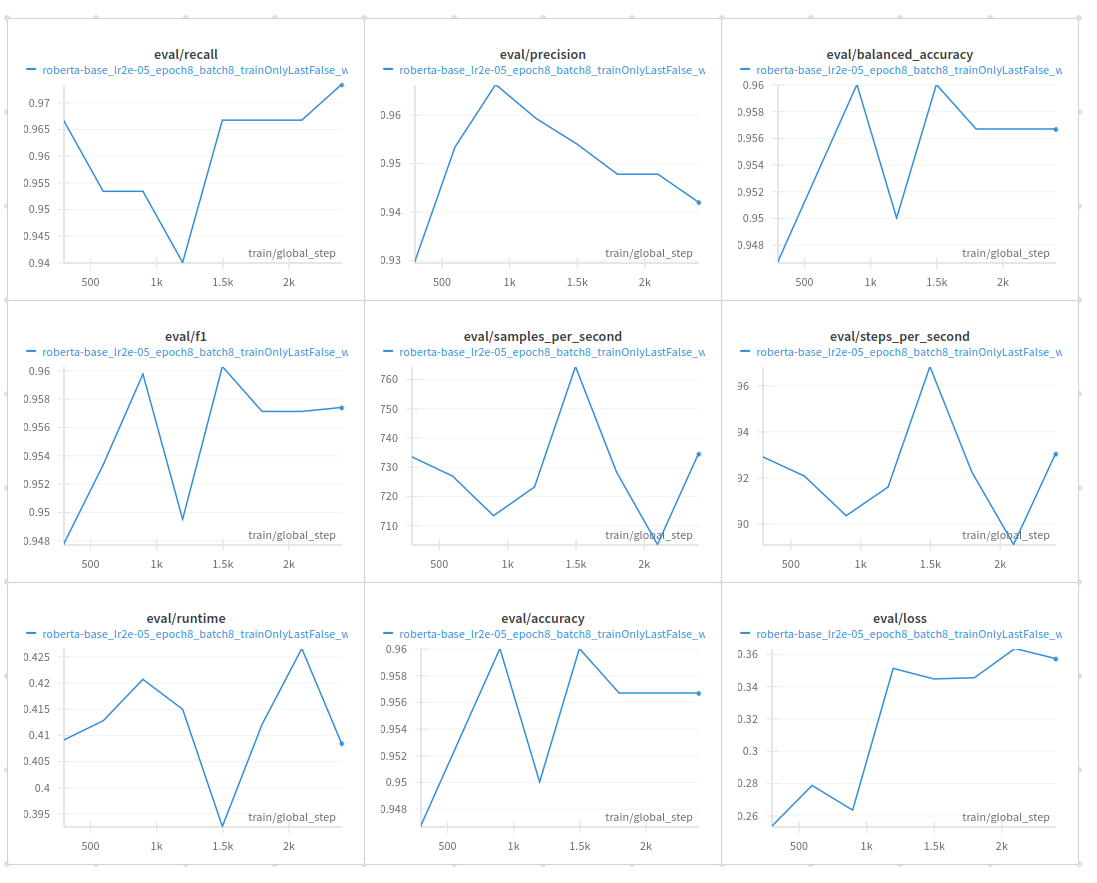
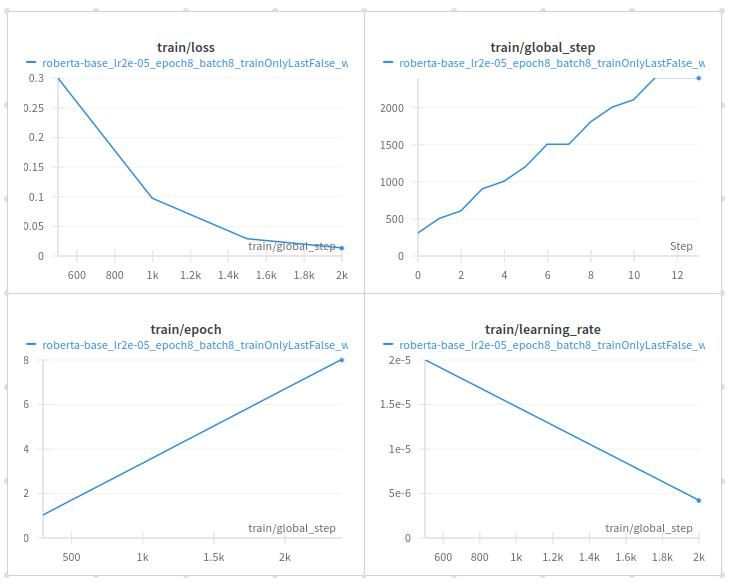